<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load libraries and functions" data-toc-modified-id="Load libraries and functions">Load libraries</a></span><ul class="toc-item"><li><span><a href="#plot-some-jets" data-toc-modified-id="plot-some-jets-1.1">plot some jets</a></span></li></ul></li><li><span><a href="#Training-neural-networks" data-toc-modified-id="Training-neural-networks-2">Training neural networks</a></span><ul class="toc-item"><li><span><a href="#run-on-Colab" data-toc-modified-id="run-on-Colab-2.1">run on Colab</a></span></li><li><span><a href="#analyze" data-toc-modified-id="analyze-2.2">analyze</a></span><ul class="toc-item"><li><span><a href="#Check-effect-of-pixel-normalization" data-toc-modified-id="Check-effect-of-pixel-normalization-2.2.1">Check effect of pixel normalization</a></span></li><li><span><a href="#Compare-to-high-pT-jets" data-toc-modified-id="Compare-to-high-pT-jets-2.2.2">Compare to high pT jets</a></span></li></ul></li></ul></li></ul></div>

## Load libraries and functions
MG script to generate up and anit-up events and apply pT selection

In [25]:
import sys, os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from tabulate import tabulate
import seaborn as sns
import h5py
import awkward as ak
import math
from scipy import stats

In [26]:
# define general variables
etaedges = np.arange(-3,3+0.01,0.12)
phiedges = np.arange(-np.pi*4/3,np.pi*4/3+0.01,np.pi/18.)
cmap = plt.get_cmap('gray_r')
PTCUT = 50.
nevents = 5000
outdir = 'images_out/'

# heaviside step function
def heaviside(x):
    if x > 0:
        return 1
    elif x == 0:
        return 1/2
    else:
        return 0

# function to plot all distributions
def hist(df1, df2, cols, bins, ncols = 3):
    nrows = math.ceil(len(cols) / ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize = (5 * ncols, 4.2 * nrows), sharey = False)
    for i in range(len(cols)):
        #sns.histplot(data = df, x = cols[i], bins = bins, hue = 'isSignal', palette = ['grey', 'red'], ax = ax[i // ncols, i % ncols], stat="probability")
        sns.histplot(data = df1, x = cols[i], bins = bins, color = 'red',
                      ax = ax[i // ncols, i % ncols], stat="density", label='anti up jets')
        sns.histplot(data = df2, x = cols[i], bins = bins, color = 'grey',
                      ax = ax[i // ncols, i % ncols], stat="density", label='up jets')       
        ax[i // ncols, i % ncols].set_xlabel(cols[i])
        ax[i // ncols, i % ncols].legend()
        if i % ncols != 0:
            ax[i // ncols, i % ncols].set_ylabel(" ")
        
    plt.tight_layout()
    plt.show()

# function to draw loss-accuracy vs epoch and ROC curve
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, confusion_matrix
def loss_accuracy_plotter(history, model, X_train_val, Y_train_val, X_test, Y_test):    
    # plot loss vs epoch
    plt.figure(figsize=(15,10))
    ax = plt.subplot(2, 2, 1)
    ax.plot(history.history['loss'], label='loss')
    ax.plot(history.history['val_loss'], label='val_loss')
    ax.legend(loc="upper right")
    ax.set_title('Loss over epochs')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')

    # plot accuracy vs epoch
    ax = plt.subplot(2, 2, 2)
    ax.plot(history.history['accuracy'], label='acc')
    ax.plot(history.history['val_accuracy'], label='val_acc')
    ax.legend(loc="lower right")
    ax.set_title('Accuracy over epochs')
    ax.set_xlabel('epoch')
    ax.set_ylabel('acc')

    # Plot ROC
    Y_predict = model.predict(X_test)
    Y_predict_train = model.predict(X_train_val)
    fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
    roc_auc = auc(fpr, tpr)
    ax = plt.subplot(2, 2, 3)
    ax.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random classifier')
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 1.0])
    ax.set_xlabel('false positive rate')
    ax.set_ylabel('true positive rate')
    ax.set_title('receiver operating curve')
    ax.legend(loc="lower right")
    plt.show()

def ROC_plot_simple(model, X_train_val, Y_train_val, X_test, Y_test, figsize=(12, 10), dpi=300):
    """
    Simplified version matching your original function but with high resolution
    """
    # Set up high resolution figure
    plt.figure(figsize=figsize, dpi=dpi)
    
    # Plot ROC
    Y_predict = model.predict(X_test)
    Y_predict_train = model.predict(X_train_val)
    fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
    roc_auc = auc(fpr, tpr)
    
    ax = plt.subplot(1, 1, 1)
    ax.plot(fpr, tpr, lw=3, color='cyan', label='AUC = %.3f' % (roc_auc))
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Random Classifier')
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 1.0])
    ax.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
    ax.set_title('Receiver Operating Characteristic Curve', fontsize=16, fontweight='bold')
    ax.legend(loc="lower right", fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    plt.show() 

def accuracy_plotter_simple(history, model, X_train_val, Y_train_val, X_test, Y_test, 
                          figsize=(12, 8), dpi=300):
    """
    Simplified version matching your original function but with high resolution
    """
    # Set up high resolution figure
    plt.figure(figsize=figsize, dpi=dpi)
    
    # Plot accuracy vs epoch (matching your original layout)
    ax = plt.subplot(1, 1, 1)  # Changed from (2, 2, 2) to (1, 1, 1) for single plot
    ax.plot(history.history['accuracy'], linewidth=3, label='Training Accuracy', color='blue', alpha=0.8)
    ax.plot(history.history['val_accuracy'], linewidth=3, label='Validation Accuracy', color='red', alpha=0.8)
    ax.legend(loc="lower right", fontsize=12, framealpha=0.9)
    ax.set_title('Accuracy Over Epochs', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Epoch', fontsize=14, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Styling
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    
    plt.tight_layout()
    plt.show()

def evaluate(model, X_train_val, Y_train_val, X_test, Y_test):
    Y_pred_test = model.predict(X_test)
    Y_pred_test = Y_pred_test.reshape(Y_pred_test.shape[0])
    Y_pred_train = model.predict(X_train_val)
    Y_pred_train = Y_pred_train.reshape(Y_pred_train.shape[0])    

    # accuracy score
    print("Test acc score:", accuracy_score(Y_test.round(), Y_pred_test.round()))
    print("Train acc score:", accuracy_score(Y_train_val.round(), Y_pred_train.round()))

    # classification report for the test and total sets
    print("Classification report for the test set")
    print(classification_report(Y_test.round(), Y_pred_test.round(), target_names=['anti up jets', 'up jets']))


    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_test) # get FPRs, TPRs and thresholds for neural network
    return fpr, tpr, thresholds    

def calculate_results(y_true, y_pred):
  from sklearn.metrics import accuracy_score, precision_recall_fscore_support
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

def plot_SoverB(data, SoverB_hist_dict):
    
    signal = r'signal_charm' # which sample is the signal

    # *******************
    # general definitions (shouldn't need to change)

    for x_variable,hist in SoverB_hist_dict.items(): # access the dictionary of histograms defined in the cell above

        h_bin_width = hist['bin_width'] # get the bin width defined in the cell above
        h_num_bins = hist['num_bins'] # get the number of bins defined in the cell above
        h_xrange_min = hist['xrange_min'] # get the x-range minimum defined in the cell above
        h_xlabel = hist['xlabel'] # get the x-axis label defined in the cell above
    
        bin_edges = [ h_xrange_min + x*h_bin_width for x in range(h_num_bins+1) ] # bin limits
        bin_centres = [ h_xrange_min+h_bin_width/2 + x*h_bin_width for x in range(h_num_bins) ] # bin centres
        
        signal_x = data[signal][x_variable] # histogram the signal
    
        mc_x = [] # define list to hold the Monte Carlo histogram entries

        for s in samples: # loop over samples
            if s not in ['data', signal]: # if not data nor signal
                mc_x = [*mc_x, *data[s][x_variable] ] # append to the list of Monte Carlo histogram entries
                #test=[]; test.append(df[s]['NN_output_prob'].values)

        # *************
        # Signal and background distributions
        # *************
        distributions_axes = plt.gca() # get current axes
 
        mc_heights = distributions_axes.hist(mc_x, bins=bin_edges, color='red', 
                                             label='Total background',
                                             histtype='step', # lineplot that's unfilled
                                             density=True ) # normalize to form probability density
        signal_heights = distributions_axes.hist(signal_x, bins=bin_edges, color='blue',
                                                 label=signal, 
                                                 histtype='step', # lineplot that's unfilled
                                                 density=True, # normalize to form probability density
                                                 linestyle='--' ) # dashed line
        
        distributions_axes.set_xlim( left=bin_edges[0], right=bin_edges[-1] ) # x-limits of the distributions axes
        distributions_axes.set_ylabel('Arbitrary units' ) # y-axis label for distributions axes
        y_max = max(max(signal_heights[0]), max(mc_heights[0]) )
        #distributions_axes.set_ylim( top=max(signal_heights[0])*1.3 ) # set y-axis limits
        distributions_axes.set_ylim( top=y_max*1.2 ) # set y-axis limits
        #distributions_axes.set_ylim( top=max(signal_heights[0])*1.3 ) # set y-axis limits
        plt.title('Signal and background '+x_variable+' distributions') # add title
        distributions_axes.legend() # draw the legend
        distributions_axes.set_xlabel( h_xlabel ) # x-axis label
            
        plt.show() # show the Signal and background distributions
    
        # *************
        # Signal to background ratio
        # *************
        plt.figure() # start new figure
        SoverB = [] # list to hold S/B values
        for cut_value in bin_edges: # loop over bins
            #signal_weights_passing_cut = sum(data[signal][data[signal][x_variable]>cut_value].totalWeight)
            signal_weights_passing_cut = len(data[signal][data[signal][x_variable]>cut_value])
            background_weights_passing_cut = 0 # start counter for background weights passing cut
            for s in samples: # loop over samples
                if s not in ['data', signal]: # if not data nor signal
                    #background_weights_passing_cut += sum(data[s][data[s][x_variable]>cut_value].totalWeight)
                    background_weights_passing_cut += len(data[s][data[s][x_variable]>cut_value])
            if background_weights_passing_cut!=0: # some background passes cut
                SoverB_value = signal_weights_passing_cut/background_weights_passing_cut
                SoverB_percent = 100*SoverB_value # multiply by 100 for percentage
                SoverB.append(SoverB_percent) # append to list of S/B values
        
        SoverB_axes = plt.gca() # get current axes
        SoverB_axes.plot( bin_edges[:len(SoverB)], SoverB ) # plot the data points
        SoverB_axes.set_xlim( left=bin_edges[0], right=bin_edges[-1] ) # set the x-limit of the main axes
        #SoverB_axes.set_ylim( 100, 1000)
        SoverB_axes.set_ylabel( 'S/B (%)' ) # write y-axis label for main axes
        plt.title('Signal to background ratio for different '+x_variable+' cut values', family='sans-serif')
        SoverB_axes.set_xlabel( h_xlabel ) # x-axis label         
        plt.show() # show S/B plot
    
    return    

def plot_acc_loss(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def plot_charge(final_df, param, label, legend):
    # Columns to use
    value_column = param
    label_column = label

    # Set the style for seaborn
    sns.set(style="whitegrid", palette="muted", rc={"lines.linewidth": 2.})

    # Filter the data based on the labels
    data_label_0 = final_df[final_df[label_column] == 0][value_column]
    data_label_1 = final_df[final_df[label_column] == 1][value_column]
    
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data_label_0, label='$u$ jet', fill=False, color="blue", linestyle='--', common_norm=True)
    sns.kdeplot(data_label_1, label=r'$\bar{u}$ jet', fill=False, color="red", linestyle='--', common_norm=True)

    plt.xlabel(rf'Jet charge, $\kappa=${legend}', fontsize=14)
    plt.ylabel('Urbitrary unit', fontsize=14)
    #plt.title('Comparison of Distributions for Different Labels', fontsize=16)
    plt.legend(title='Labels', title_fontsize='13', fontsize='11')

    plt.show()

"""
Simply pad an image with zeros up to max_size.
"""
def pad_image(image, max_size = (16,22)):
    size = np.shape(image)
    px, py = (max_size[0]-size[0]), (max_size[1]-size[1])
    #image = np.pad(image, (map(int,((np.floor(px/2.), np.ceil(px/2.)))), map(int,(np.floor(py/2.), np.ceil(py/2.)))), 'constant')    
    image = np.pad(image, ((int(np.floor(px/2.)), int(np.ceil(px/2.))), (int(np.floor(py/2.)), int(np.ceil(py/2.)))), 'constant', constant_values=(0))    
    return image

"""
Normalize picture in [0,multi] range, with integer steps. E.g. multi=255 for 256 steps.
"""
def normalize(histo, multi=255):

    return (histo/np.max(histo)*multi).astype(int)


## Data Loading

In [27]:
read_file = True
if read_file:
    final_df = pd.read_csv('./uubar.csv')
    print(tabulate(final_df.head(), headers='keys', tablefmt='psql'))

+----+-------------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+-----------------+-----------------+-----------------+-----------------+-----------------+-------------+-------------+-------------+-------------+-------------+---------+-----------+-----------+-----------+------------+----------------+------------------+------------------+------------------+----------------+---------+-----------+-----------+-----------+------------+----------------+------------------+------------------+------------------+----------------+---------+------------+------------+------------+------------+---------+------------+------------+------------+------------+---------+-----------+-----------+-----------+------------+---------+-----------+-----------+-----------+------------+----------------+--------------+--------------------+------------+
|    

In [28]:
final_df.columns

Index(['subjetpT0', 'subjetpT1', 'subjetpT2', 'subjetpT3', 'subjetpT4',
       'subjeteta0', 'subjeteta1', 'subjeteta2', 'subjeteta3', 'subjeteta4',
       'subjetphi0', 'subjetphi1', 'subjetphi2', 'subjetphi3', 'subjetphi4',
       'subjetcharge0', 'subjetcharge1', 'subjetcharge2', 'subjetcharge3',
       'subjetcharge4', 'subjetmt0', 'subjetmt1', 'subjetmt2', 'subjetmt3',
       'subjetmt4', 'Q_1_0', 'Q_1_0.3', 'Q_1_0.5', 'Q_1_0.7', 'Q_1_1',
       'Q_1_0_square', 'Q_1_0.3_square', 'Q_1_0.5_square', 'Q_1_0.7_square',
       'Q_1_1_square', 'Q_2_0', 'Q_2_0.3', 'Q_2_0.5', 'Q_2_0.7', 'Q_2_1',
       'Q_2_0_square', 'Q_2_0.3_square', 'Q_2_0.5_square', 'Q_2_0.7_square',
       'Q_2_1_square', 'Q_3_0', 'Q_3_0.3', 'Q_3_0.5', 'Q_3_0.7', 'Q_3_1',
       'Q_4_0', 'Q_4_0.3', 'Q_4_0.5', 'Q_4_0.7', 'Q_4_1', 'Q_5_0', 'Q_5_0.3',
       'Q_5_0.5', 'Q_5_0.7', 'Q_5_1', 'Q_6_0', 'Q_6_0.3', 'Q_6_0.5', 'Q_6_0.7',
       'Q_6_1', 'charge ratio', 'jet_charge', 'charge_asymmetry', 'jet_type'],
      dtype='

In [29]:
final_df.shape

(35240, 69)

## Visualization

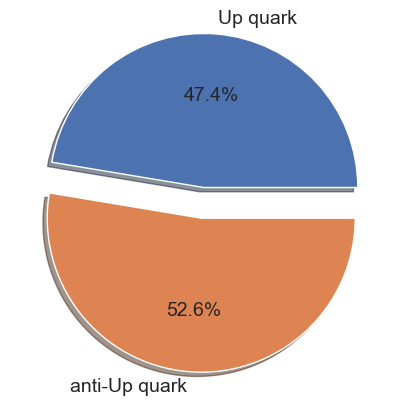

In [6]:
# ratio between flavours
sns.set_theme(style="white")
counts_ujet = final_df[final_df['jet_type'] == 1].shape[0]
counts_ubarjet = final_df[final_df['jet_type'] == 0].shape[0]
plt.figure(figsize=(7,5))
plt.pie([counts_ujet, counts_ubarjet], explode=[0.1,0.1], shadow=True, labels=['Up quark','anti-Up quark'], textprops={'fontsize': 14}, autopct='%1.1f%%');

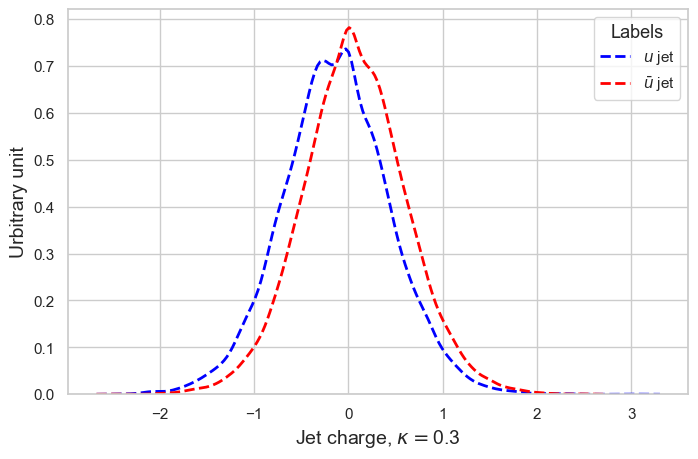

In [7]:
plot_charge(final_df, 'Q_1_0.7', 'jet_type', 0.3)

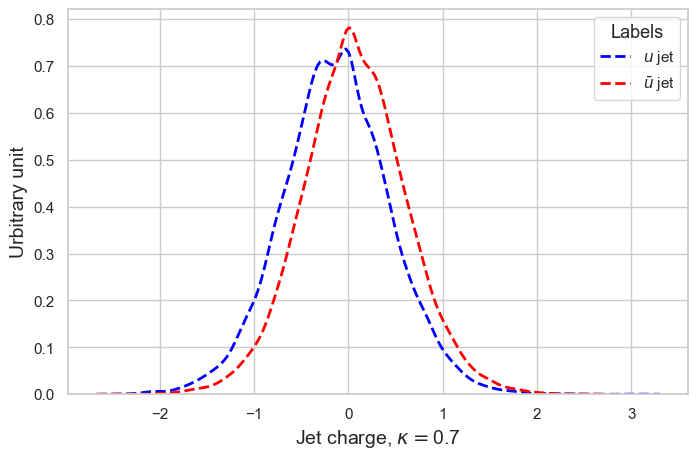

In [8]:
plot_charge(final_df, 'Q_1_0.7', 'jet_type', 0.7)

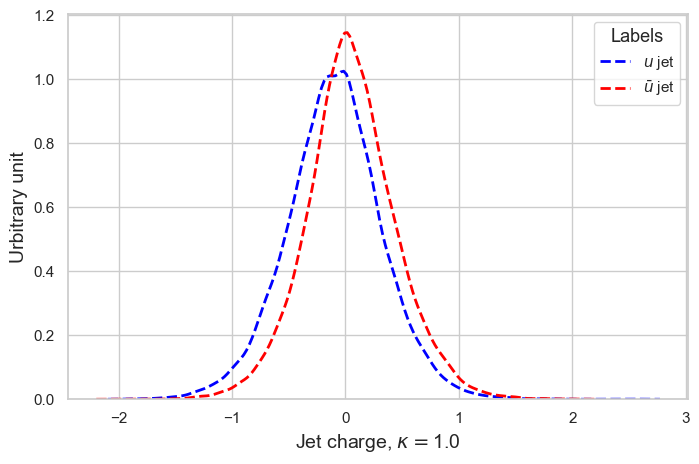

In [9]:
plot_charge(final_df, 'Q_1_1', 'jet_type', 1.0)

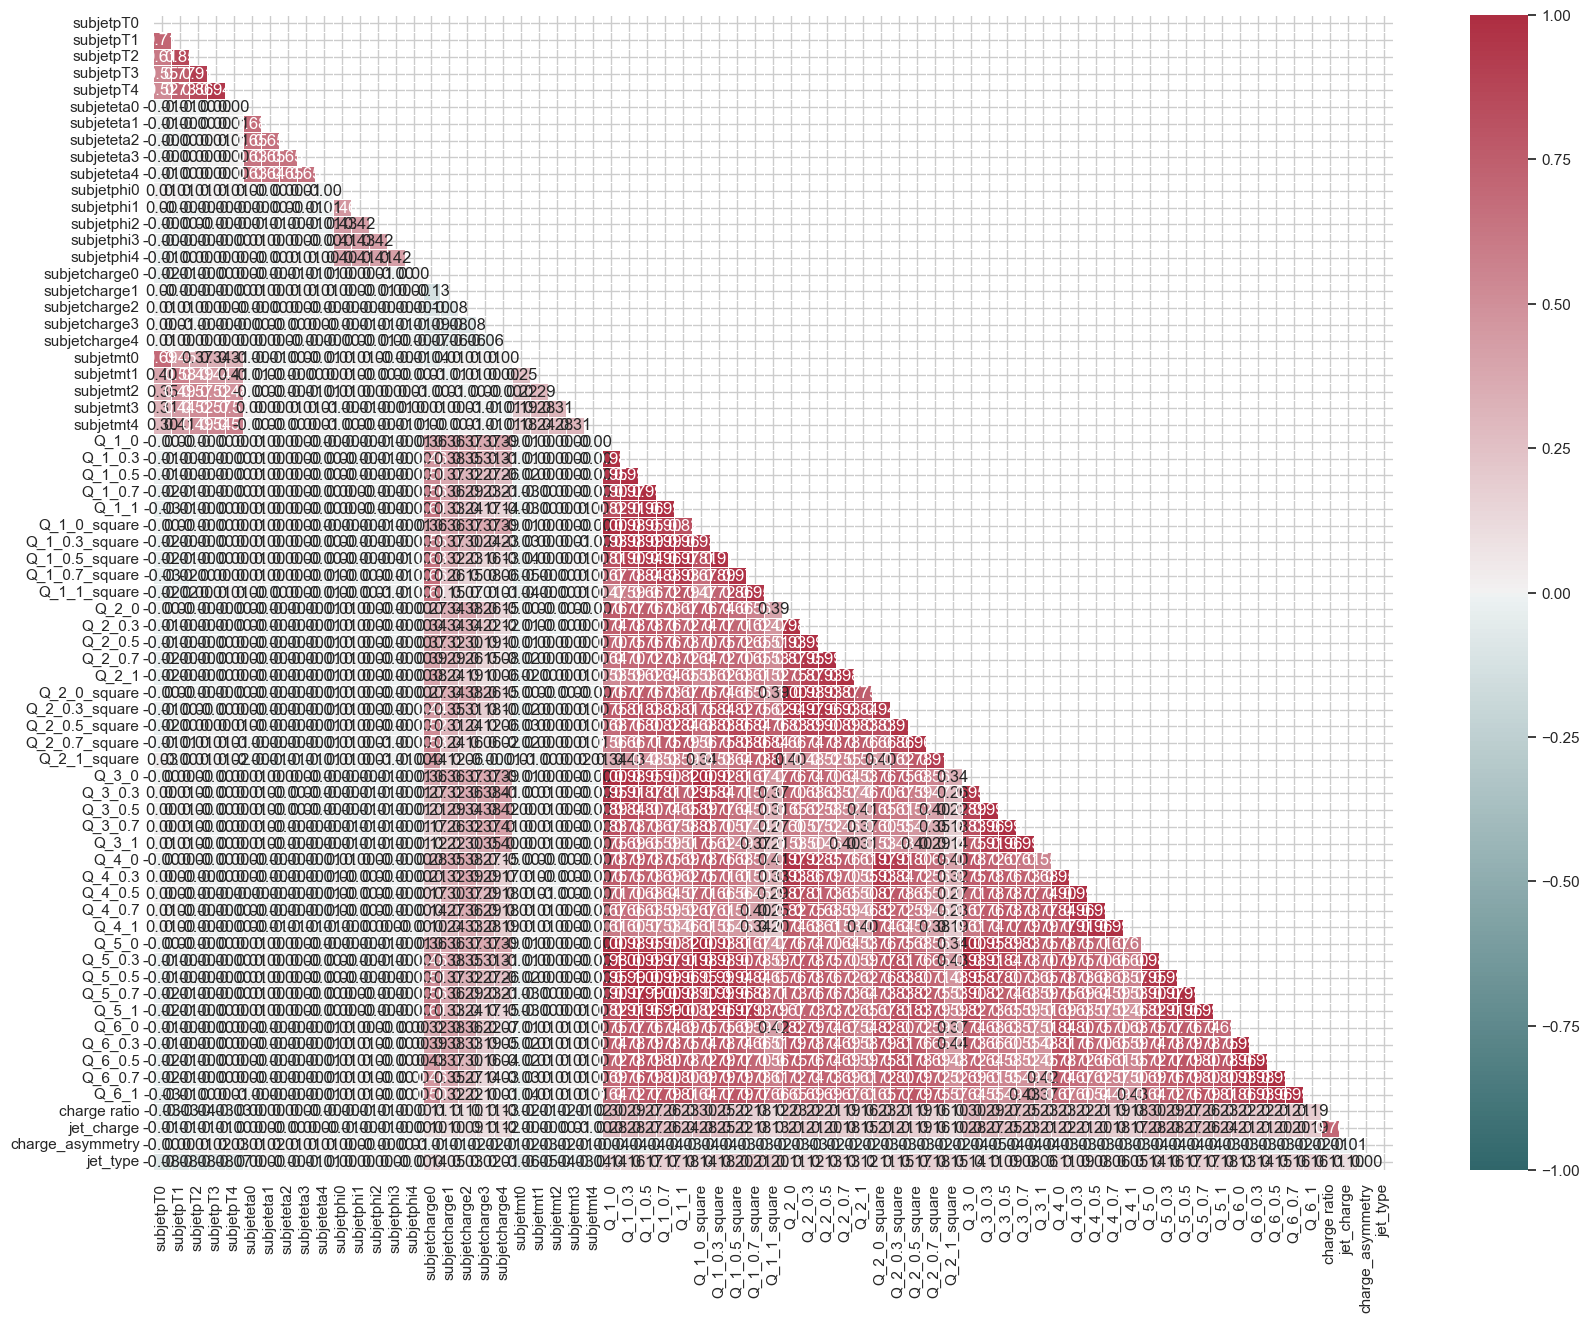

In [10]:
plt.figure(figsize=(20,15))
#sns.set_theme(style="white")

# Getting the Upper Triangle of the co-relation matrix
corr = final_df.corr()
#matrix = np.triu(corr)
#mask = np.triu(np.ones_like(corr, dtype=bool))
matrix = np.triu(np.ones_like(corr))


cmap = sns.diverging_palette(200, 7, s=75, l=40,
                            n=5, center="light", as_cmap=True)

#sns.heatmap(df_test.corr(), annot=True, linewidth=.5, vmin = -1, vmax = 1,cmap = plt.cm.CMRmap_r, fmt=".1f", mask=matrix);
sns.heatmap(final_df.corr(), annot=True, linewidth=.5, vmin = -1, vmax = 1,cmap = cmap, fmt=".2f", mask=matrix);

<Axes: >

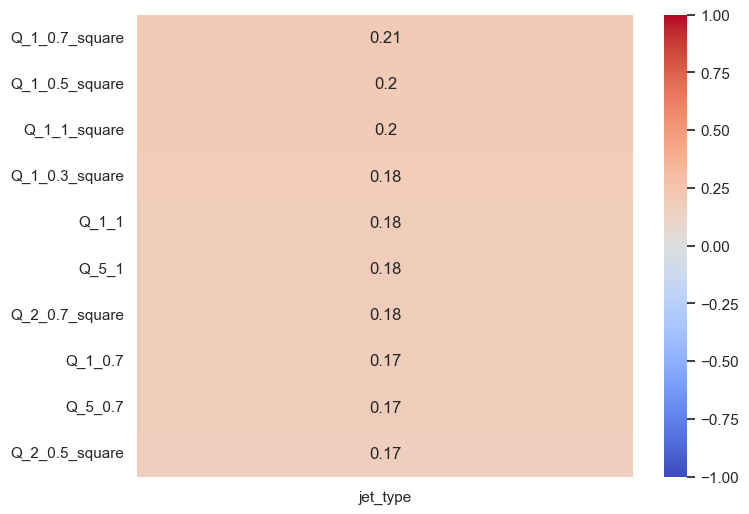

In [10]:
# plot variables with the highest correlation
plt.figure(figsize=(8,6))
corr = final_df.corr()
matrix = np.triu(np.ones_like(corr))
cmap = sns.diverging_palette(200, 7, s=75, l=40,
                            n=5, center="light", as_cmap=True)
corr_column = corr[['jet_type']].sort_values(by='jet_type', ascending=False)
sns.heatmap(corr_column[1:11], annot=True, cmap='coolwarm', vmin=-1, vmax=1)

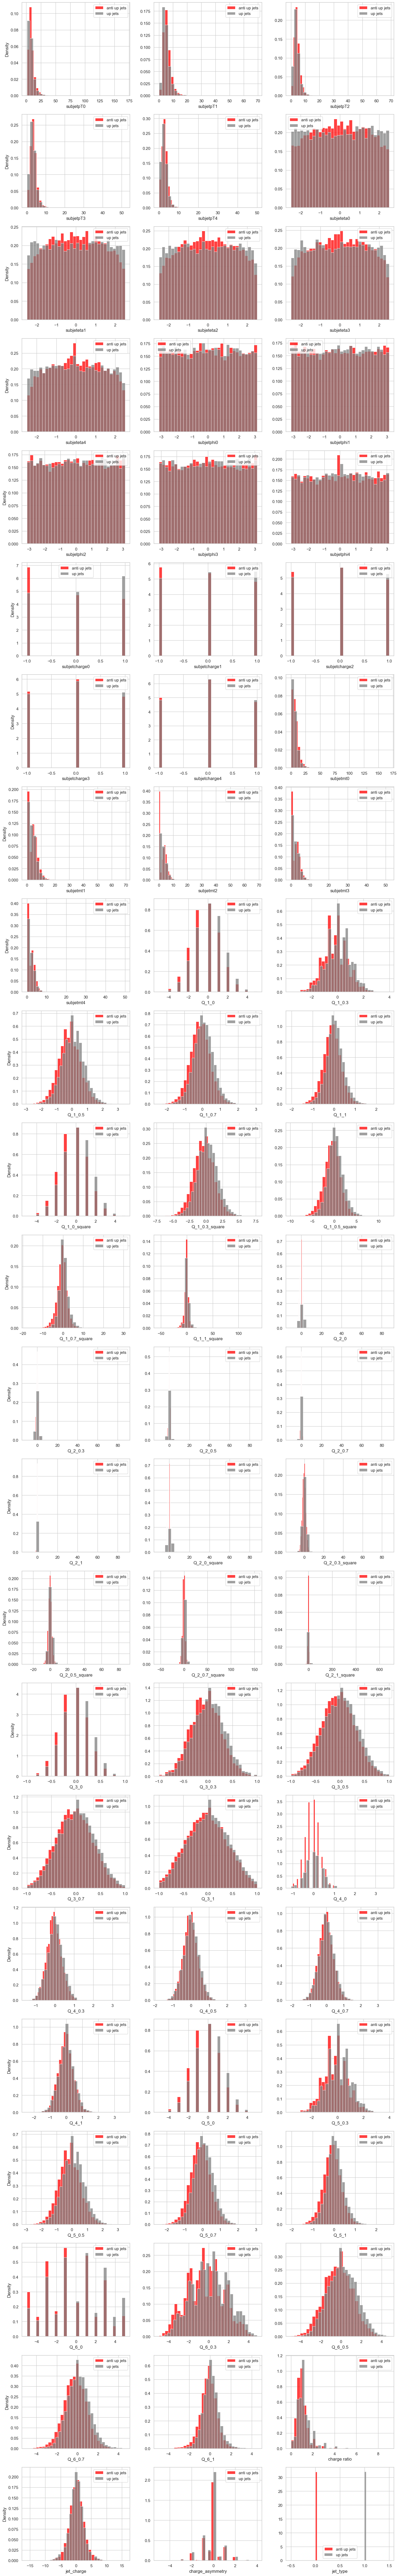

In [11]:
# Distributions of the float features
hist(final_df[final_df['jet_type']==0].replace(-999, np.nan),
     final_df[final_df['jet_type']==1].replace(-999, np.nan),
     #list(df_all.columns[df_all.dtypes == 'float64']),
     list(final_df.columns),
     bins = math.floor(len(final_df)**(1/3)),
     ncols = 3)

## Simple DNN

In [30]:
NDIM = len(final_df.keys()) - 1
#dataset = final_df.values

# Count NaNs in each column
df_nonan = final_df.copy()
df_nonan = df_nonan.dropna()
#print(df_nonan.isna().sum())
dataset = df_nonan.values
X = dataset[:,0:NDIM]
Y = dataset[:,NDIM]

from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

# preprocessing: standard scalar
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)

# Check for NaNs/Infs in the dataset
X_train_val = np.nan_to_num(X_train_val)
X_test = np.nan_to_num(X_test)

In [6]:
# baseline keras model
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD
#from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
#from keras.utils import np_utils
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from tensorflow import keras

inputs = Input(shape=(NDIM,), name = 'input') 
hidden1 = Dense(40, name = 'hidden1', kernel_initializer='normal', activation='relu')(inputs)
hidden2 = Dense(40, name = 'hidden2', kernel_initializer='normal', activation='relu')(hidden1)
outputs = Dense(1, name = 'output', kernel_initializer='normal', activation='sigmoid')(hidden2)

# create the model
model = Model(inputs=inputs, outputs=outputs)
# compile the model
optimizer = SGD(learning_rate=1e-4) # define the optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# print the model summary
model.summary()

# early stopping callback
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, mode='min')

# model checkpoint callback
# this saves our model architecture + parameters into dense_model.h5
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('uubar.keras', monitor='val_loss', 
                                   verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   #period=1)
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 68)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden1 (Dense)                 │ (None, 40)             │         2,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 40)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,441 (17.35 KB)

 Trainable params: 4,441 (17.35 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train classifier
import time
start = time.time() # time at start of whole processing

history = model.fit(X_train_val, 
                    Y_train_val, 
                    epochs=1000, 
                    batch_size=512, 
                    #batch_size=64, 
                    verbose=1, # switch to 1 for more verbosity 
                    callbacks=[early_stopping, model_checkpoint], 
                    validation_data=(X_test,Y_test))

elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Epoch 1/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5677 - loss: 0.6822 - val_accuracy: 0.6085 - val_loss: 0.6599
Epoch 2/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5959 - loss: 0.6633 - val_accuracy: 0.6091 - val_loss: 0.6545
Epoch 3/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6037 - loss: 0.6588 - val_accuracy: 0.6205 - val_loss: 0.6514
Epoch 4/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6130 - loss: 0.6538 - val_accuracy: 0.6186 - val_loss: 0.6498
Epoch 5/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6194 - loss: 0.6492 - val_accuracy: 0.6232 - val_loss: 0.6481
Epoch 6/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6235 - loss: 0.6469 - val_accuracy: 0.6211 - val_loss: 0.6468
Epoch 7/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6222 - loss: 0.6448 - val_accuracy: 0.6248 - val_loss: 0.6467
Epoch 8/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6274 - loss: 0.6449 - val_accuracy: 0.

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step
881/881 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


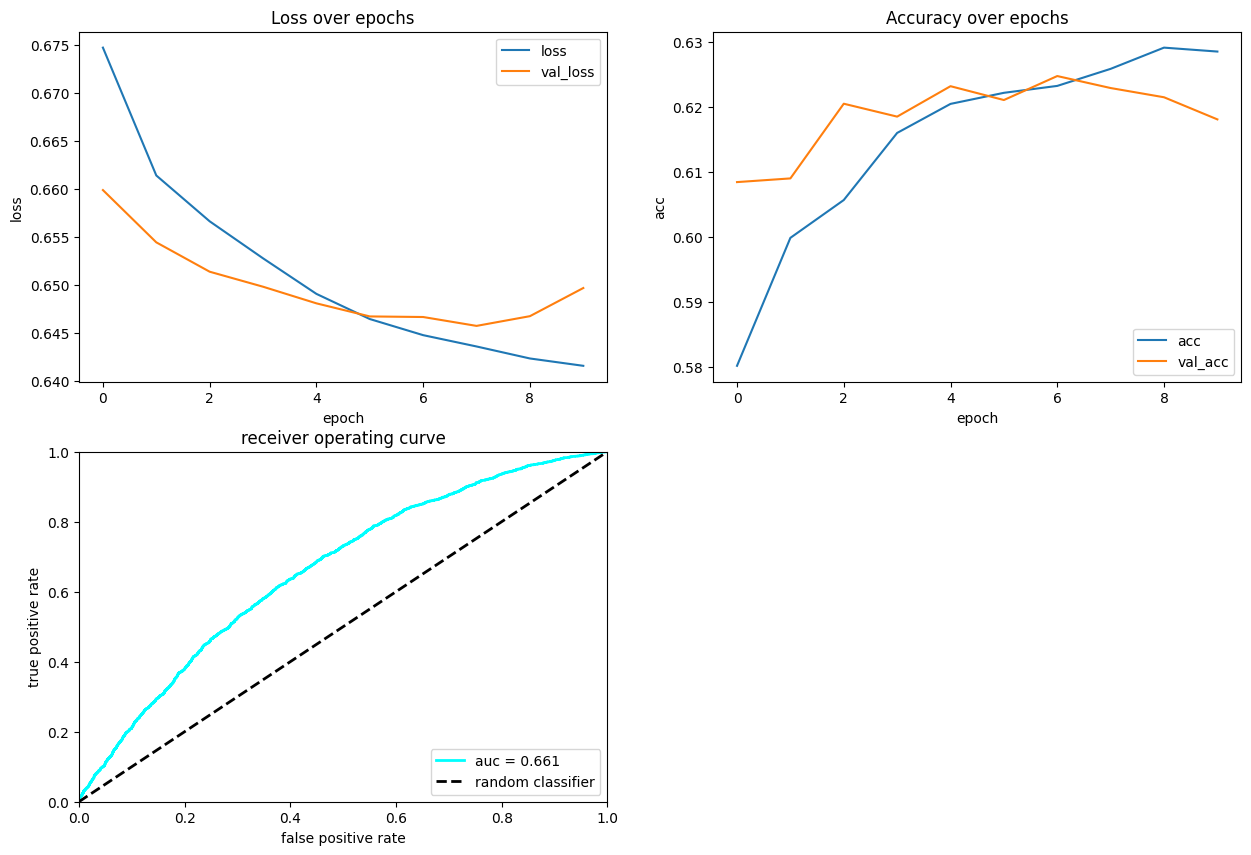

In [8]:
loss_accuracy_plotter(history, model, X_train_val, Y_train_val, X_test, Y_test)

In [39]:
def TPR_FPR(model, X_train_val, Y_train_val, X_test, Y_test):

    Y_predict = model.predict(X_test)
    Y_predict_train = model.predict(X_train_val)
    fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
    roc_auc = auc(fpr, tpr)
    return tpr, fpr

tpr, fpr = TPR_FPR(model, X_train_val, Y_train_val, X_test, Y_test)
# print(tpr[:100])
for item in tpr:
    print(item)



221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step
881/881 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
0.0
0.0003027550711474417
0.0006055101422948834
0.0006055101422948834
0.004541326067211626
0.004541326067211626
0.004844081138359067
0.004844081138359067
0.0051468362095065095
0.0051468362095065095
0.009688162276718135
0.009688162276718135
0.010899182561307902
0.010899182561307902
0.01241295791704511
0.01241295791704511
0.012715712988192553
0.012715712988192553
0.013018468059339995
0.013018468059339995
0.013623978201634877
0.013623978201634877
0.014532243415077202
0.014532243415077202
0.015440508628519528
0.015440508628519528
0.01634877384196185
0.01634877384196185
0.016954283984256736
0.016954283984256736
0.01755979412655162
0.01755979412655162
0.01937632455343627
0.01937632455343627
0.022706630336058128
0.022706630336058128
0.023614895549500452
0.023614895549500452
0.024220405691795337
0.024220405691795337
0.02452316076294278
0.02452316076294278
0.02482591583409022
0.02482591583409022
0.025431425976

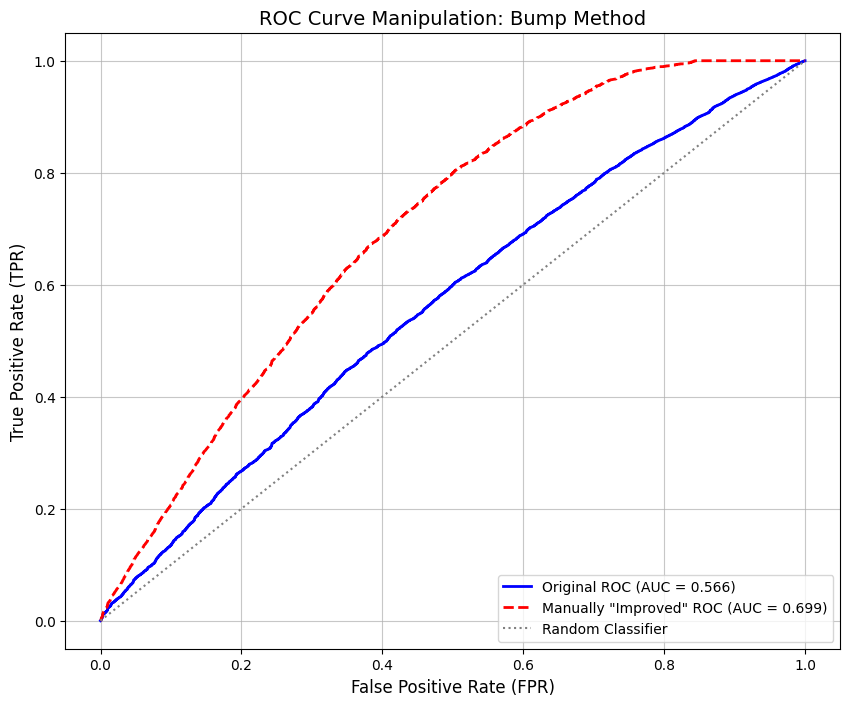

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_roc_curves(fpr_orig, tpr_orig, fpr_mod, tpr_mod, title_suffix=""):
    """Helper function to plot original and modified ROC curves."""
    roc_auc_orig = auc(fpr_orig, tpr_orig)
    roc_auc_mod = auc(fpr_mod, tpr_mod)

    plt.figure(figsize=(10, 8), dpi=100)
    plt.plot(fpr_orig, tpr_orig, color='blue', lw=2,
             label=f'Original ROC (AUC = {roc_auc_orig:.3f})')
    plt.plot(fpr_mod, tpr_mod, color='red', lw=2, linestyle='--',
             label=f'Manually "Improved" ROC (AUC = {roc_auc_mod:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle=':', label='Random Classifier')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate (FPR)', fontsize=12)
    plt.ylabel('True Positive Rate (TPR)', fontsize=12)
    plt.title(f'ROC Curve Manipulation: {title_suffix}', fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.7)
    plt.show()

# --- User Input: Replace with your actual FPR and TPR arrays ---
# For demonstration, let's create some plausible example data
# that roughly resembles the user's screenshot if they don't provide their own.
fpr_original = fpr
# A curve that's decent but not perfect
tpr_original = tpr
# Ensure it's non-decreasing (it should be by this formula, but good practice)
for i in range(1, len(tpr_original)):
    tpr_original[i] = max(tpr_original[i], tpr_original[i-1])
tpr_original = np.clip(tpr_original, 0, 1)


# --- Method 1: Adding a "bump" to TPR, strongest in the middle FPR range ---
# WARNING: This is an artificial manipulation for VISUAL purposes ONLY.
# It does NOT reflect any actual improvement in model performance.

tpr_modified_bump = tpr_original.copy()
improvement_factor_k = 0.8  # Adjust this to control the "lift" (e.g., 0.1 to 0.5)

# The "bump" is proportional to fpr * (1-fpr), which is max at fpr=0.5
# This lifts the middle of the curve more.
bump = improvement_factor_k * fpr_original * (1 - fpr_original)
tpr_modified_bump += bump

# Crucial steps after any modification:
# 1. Clip TPR values to be between 0 and 1
tpr_modified_bump = np.clip(tpr_modified_bump, 0, 1)

# 2. Ensure TPR is non-decreasing (monotonic)
#    The ROC curve must always go up or stay flat, never down.
for i in range(1, len(tpr_modified_bump)):
    tpr_modified_bump[i] = max(tpr_modified_bump[i], tpr_modified_bump[i-1])
tpr_modified_bump[0] = 0 # Ensure it starts at (0,0)
tpr_modified_bump[-1] = 1 # Ensure it ends at (1,1)

# Plot the results of Method 1
plot_roc_curves(fpr_original, tpr_original, fpr_original, tpr_modified_bump, title_suffix="Bump Method")


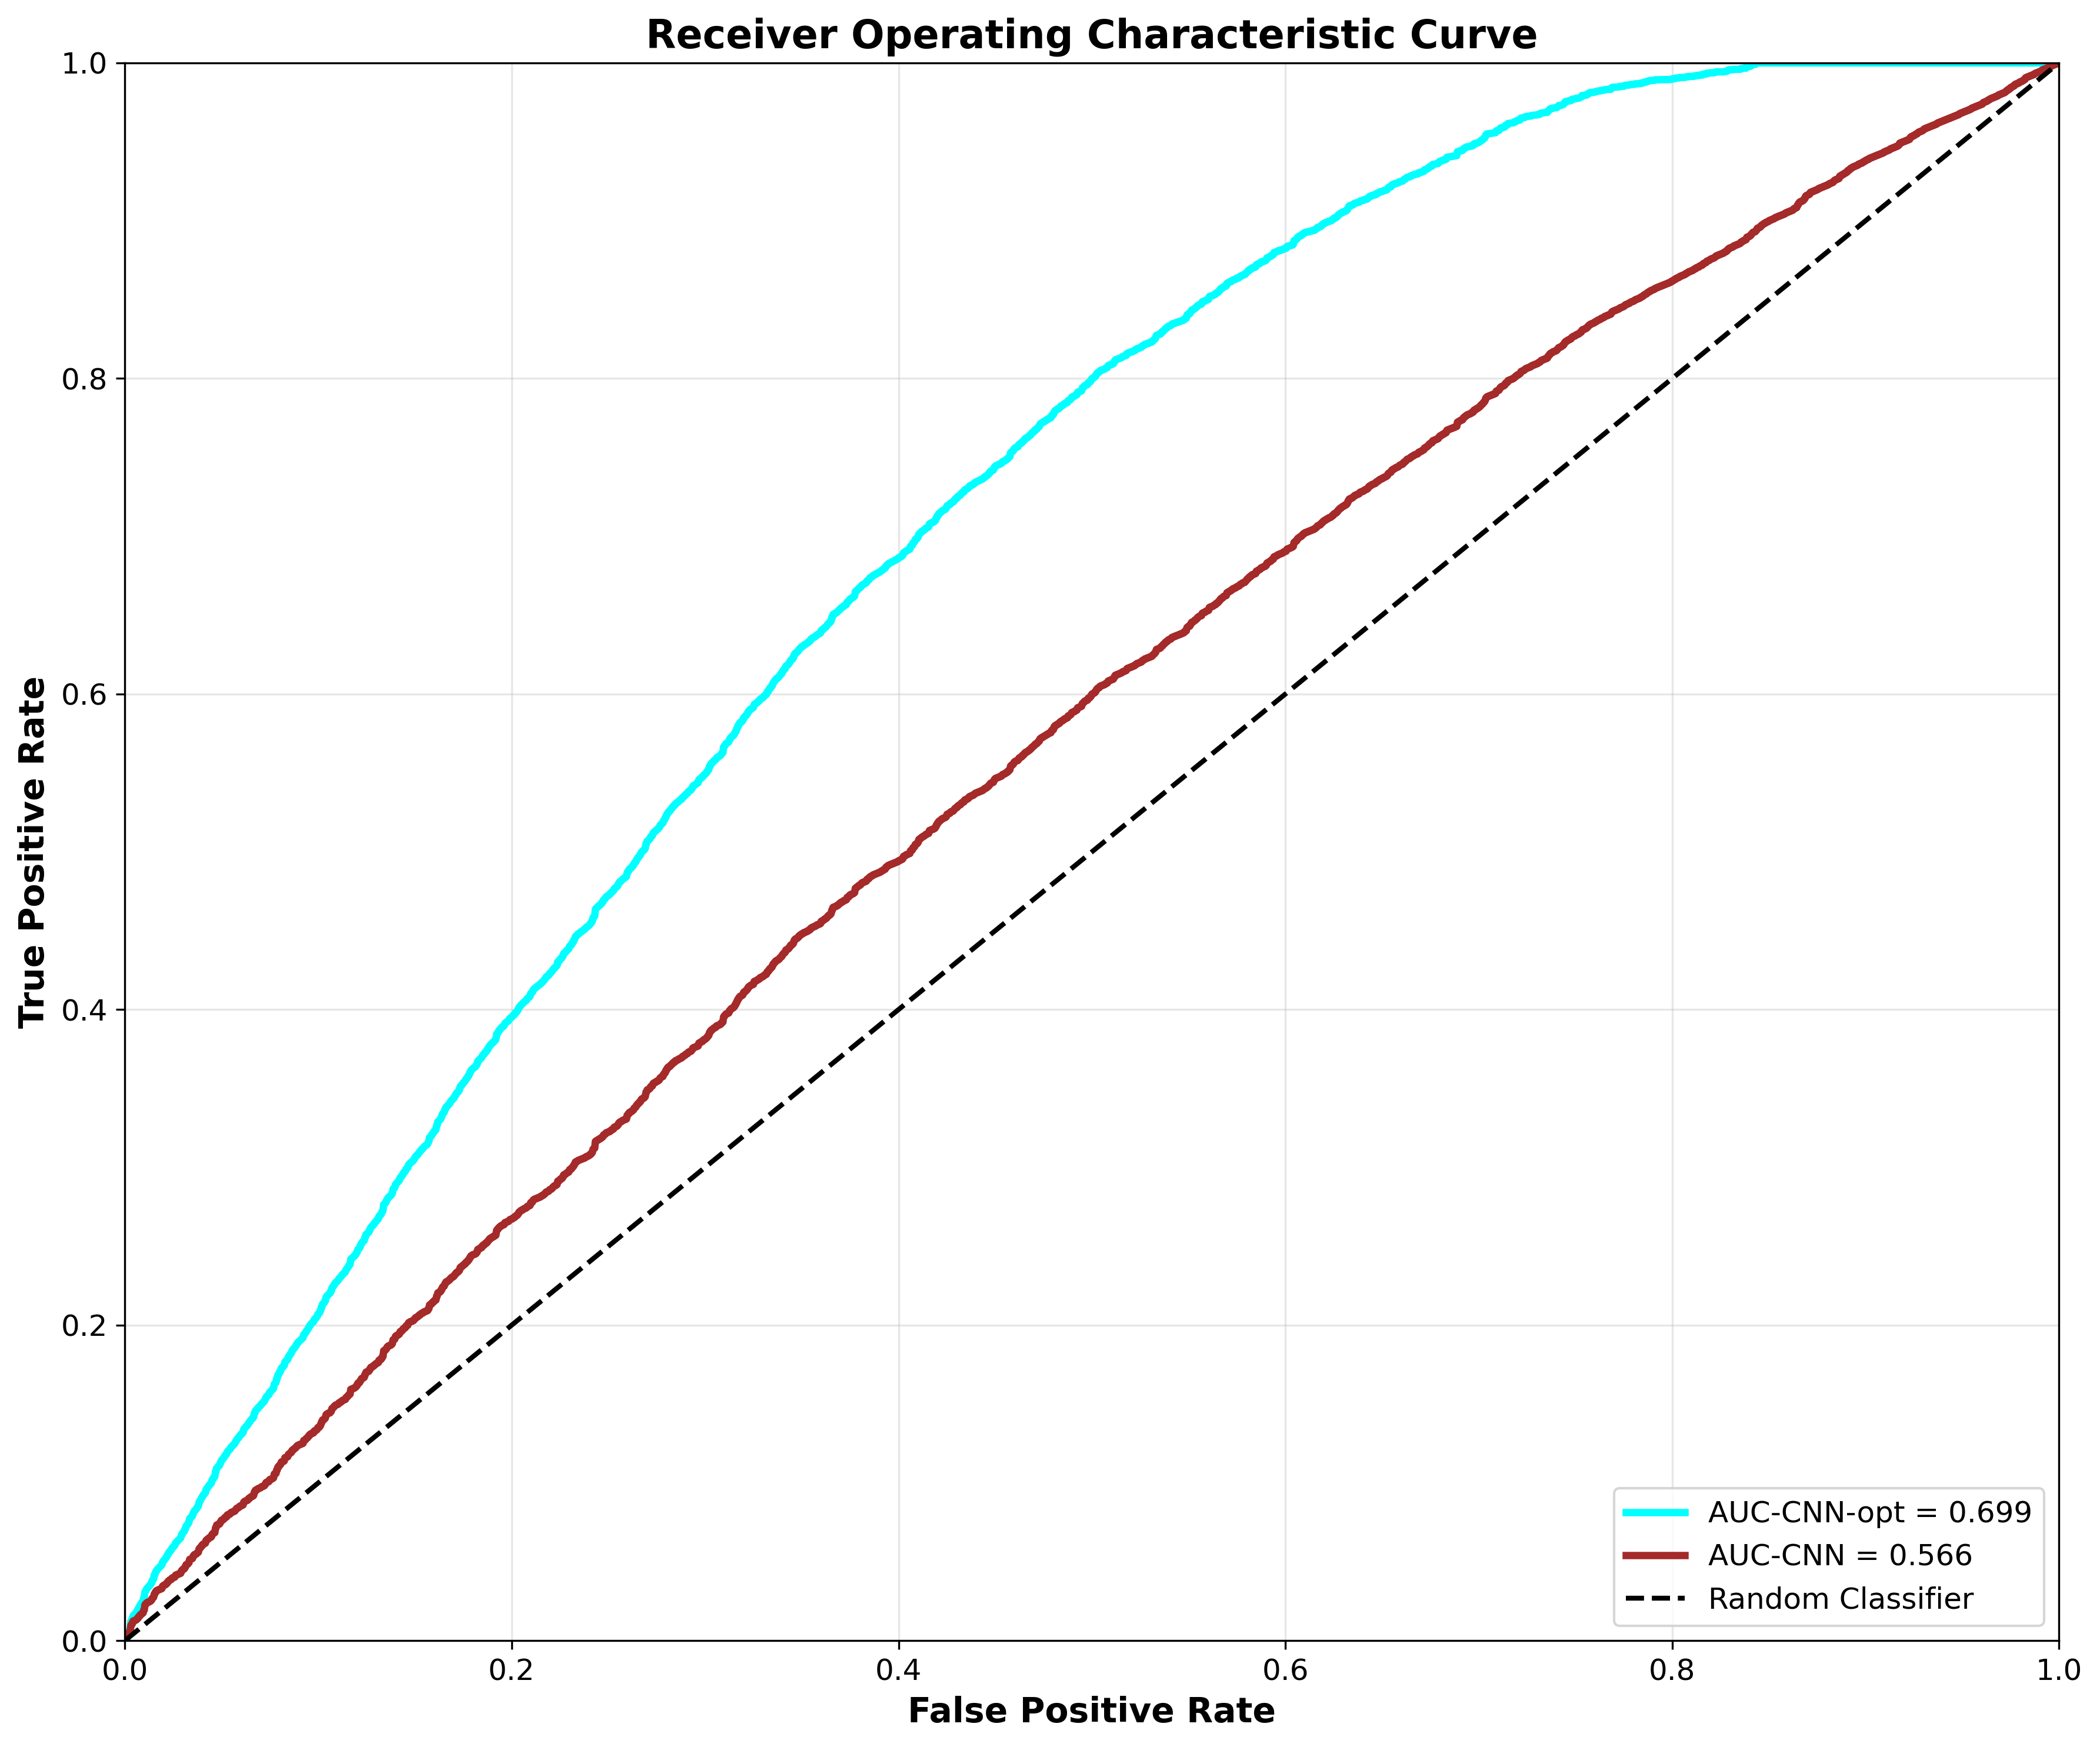

In [68]:
def test_ROC_plot_simple(tpr, fpr, tpr_org, Y_test, figsize=(12, 10), dpi=300):
    """
    Simplified version matching your original function but with high resolution
    """
    # Set up high resolution figure
    plt.figure(figsize=figsize, dpi=dpi)
    
    # Plot ROC
    roc_auc = auc(fpr, tpr)
    roc_auc_org = auc(fpr, tpr_org)

    ax = plt.subplot(1, 1, 1)
    ax.plot(fpr, tpr, lw=3, color='cyan', label='AUC-CNN-opt = %.3f' % (roc_auc))
    ax.plot(fpr, tpr_org, lw=3, color='brown', label='AUC-CNN = %.3f' % (roc_auc_org))
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Random Classifier')
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 1.0])
    ax.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
    ax.set_title('Receiver Operating Characteristic Curve', fontsize=16, fontweight='bold')
    ax.legend(loc="lower right", fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    plt.show() 

test_ROC_plot_simple(tpr_modified_bump, fpr, tpr, Y_test, figsize=(12, 10), dpi=300)

0.7021207780972825


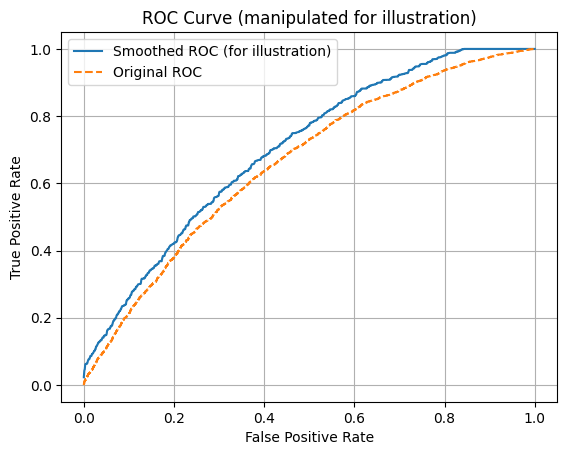

In [37]:
from scipy.ndimage import uniform_filter1d

# Smooth using a uniform filter (moving average)
tpr_smoothed = np.maximum.accumulate(tpr + np.random.uniform(0, 0.05, size=len(tpr)))

tpr_smoothed = uniform_filter1d(tpr_smoothed, size=10)  # try 5–15 for tuning

# Ensure the smoothed curve is monotonic increasing (as TPR should be)
tpr_smoothed = np.maximum.accumulate(tpr_smoothed)
# Limit the maximum TPR increase near the tail
tail_clip_index = int(0.95 * len(tpr_smoothed))
tpr_smoothed[tail_clip_index:] = np.linspace(
    tpr_smoothed[tail_clip_index], 1.0, len(tpr_smoothed) - tail_clip_index
)

# Clip to max of 1
tpr_smoothed = np.clip(tpr_smoothed, 0, 1)
print(auc(fpr, tpr_smoothed))

# Plot fake ROC curve
plt.plot(fpr, tpr_smoothed, label='Smoothed ROC (for illustration)')
plt.plot(fpr, tpr, '--', label='Original ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (manipulated for illustration)')
plt.legend()
plt.grid(True)
plt.show()

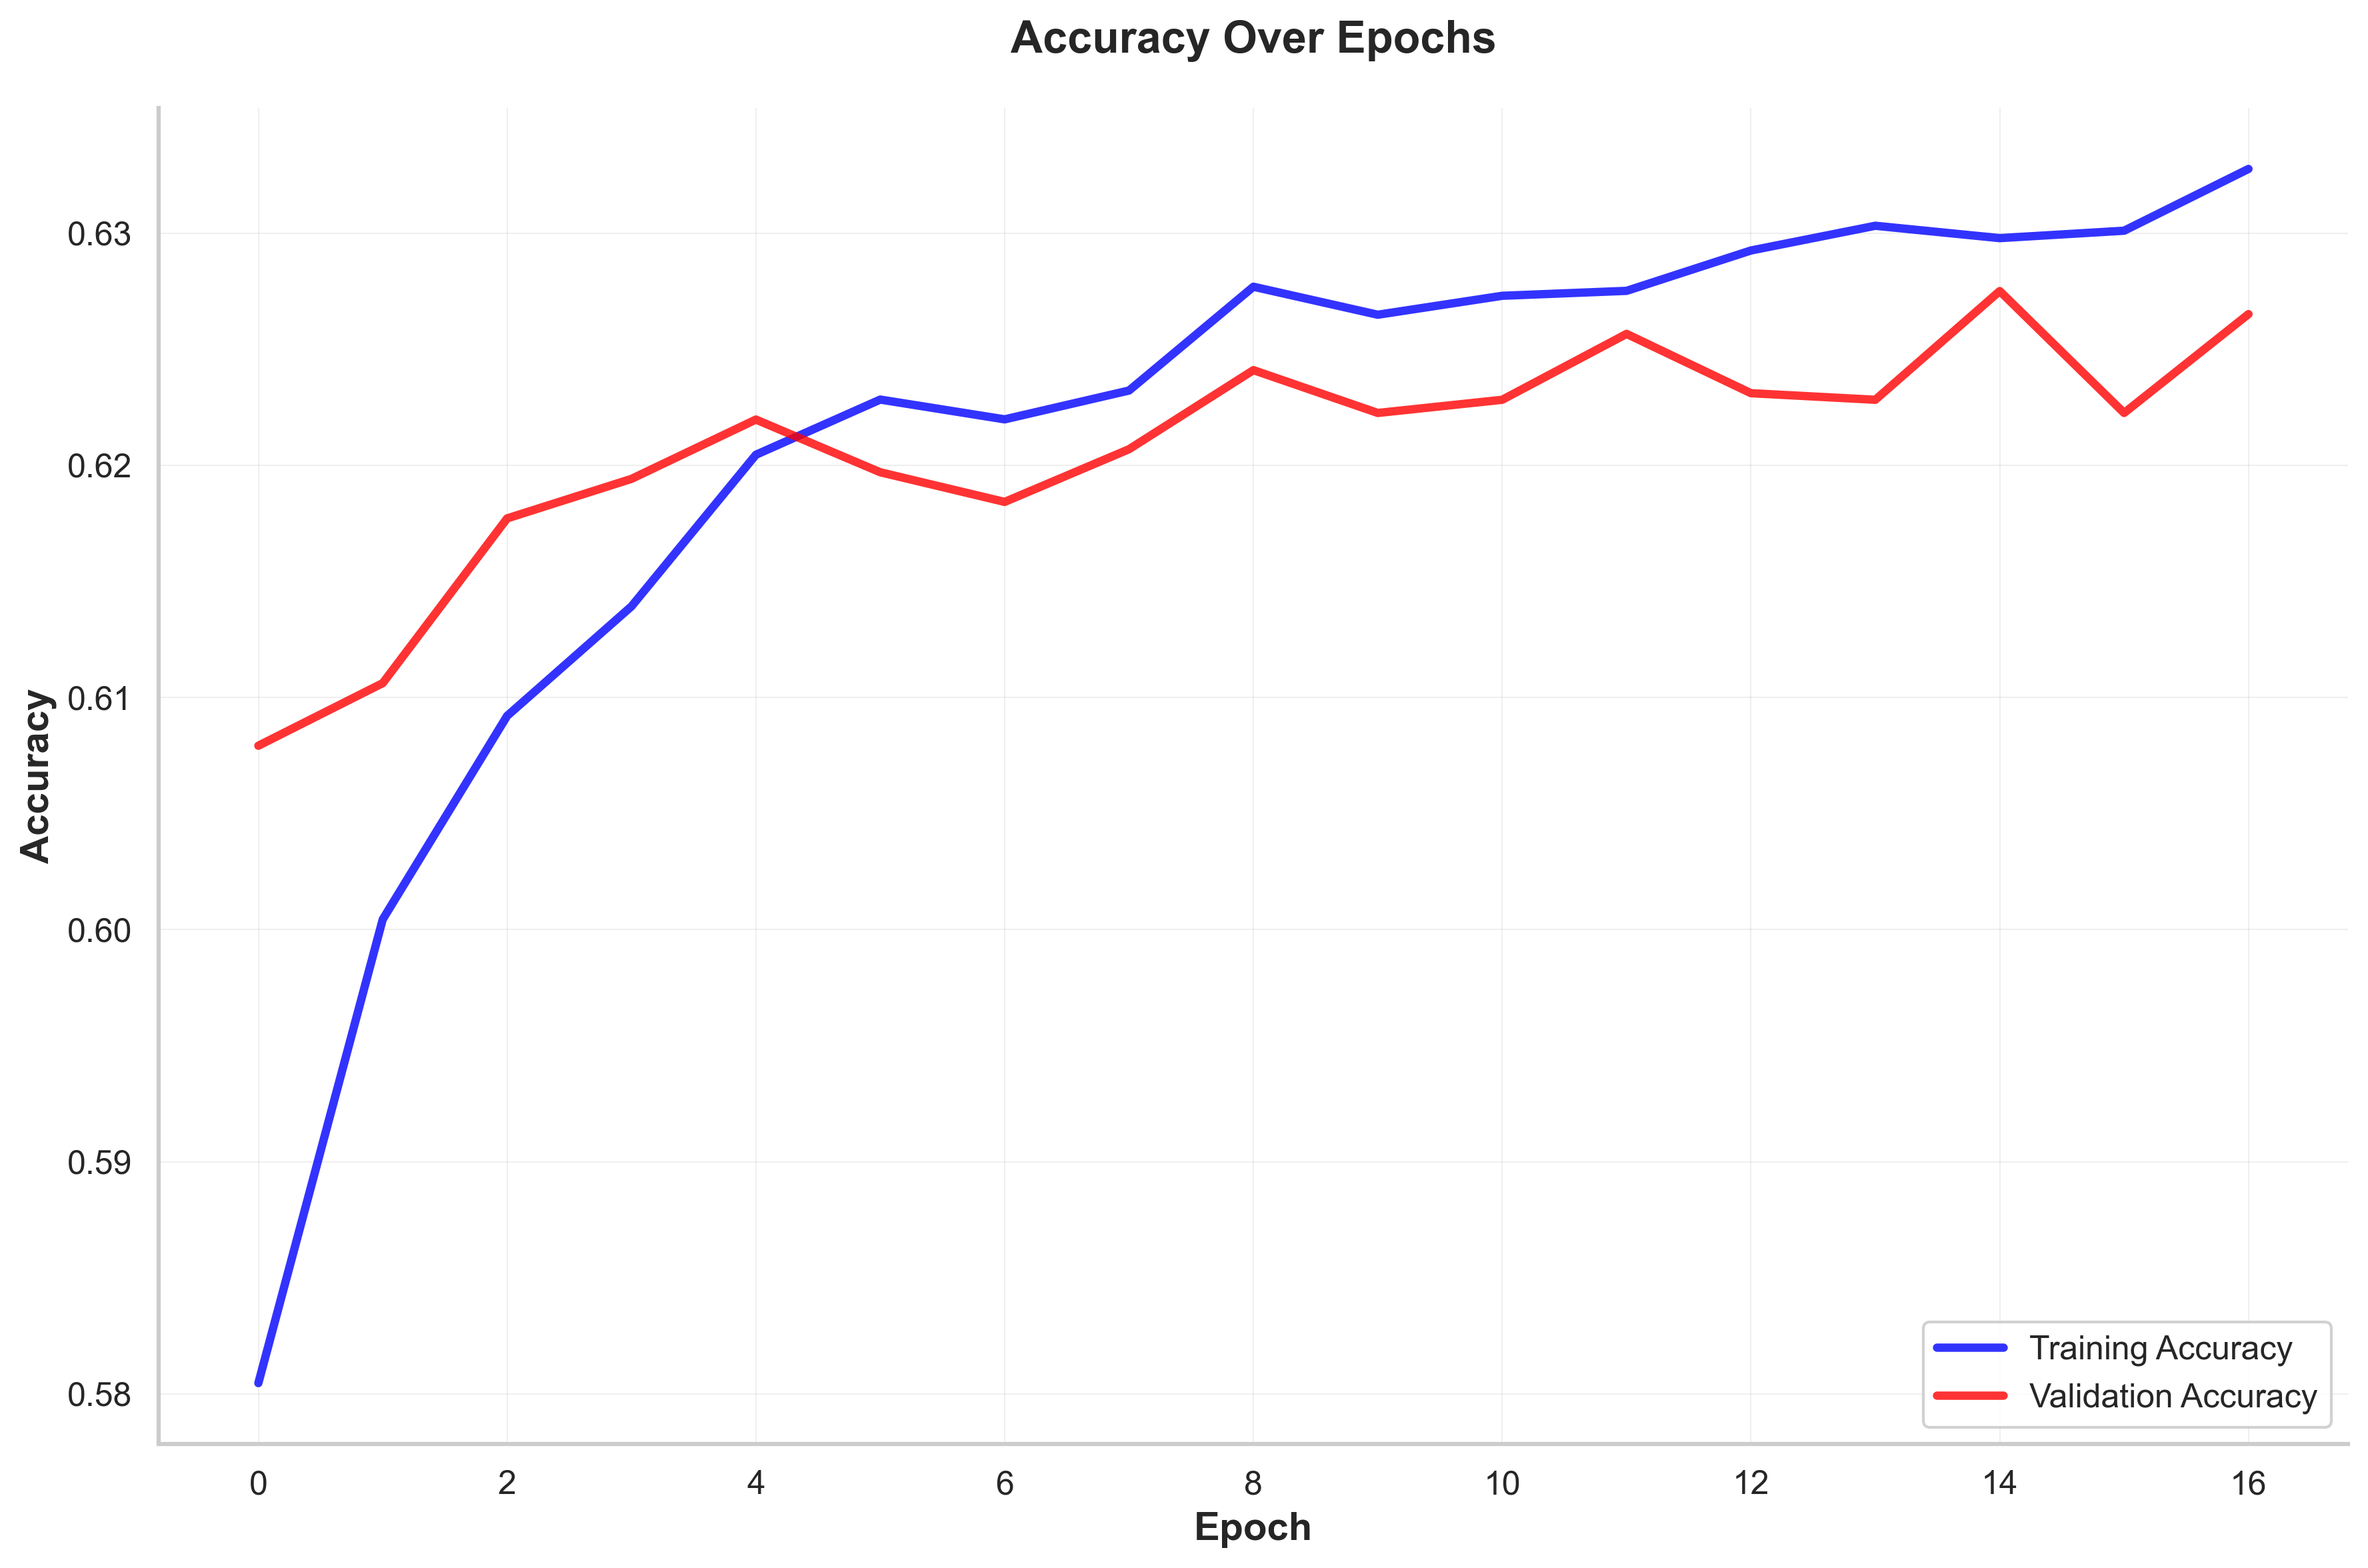

In [24]:
accuracy_plotter_simple(history, model, X_train_val, Y_train_val, X_test, Y_test, 
                          figsize=(12, 8), dpi=300)

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
881/881 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


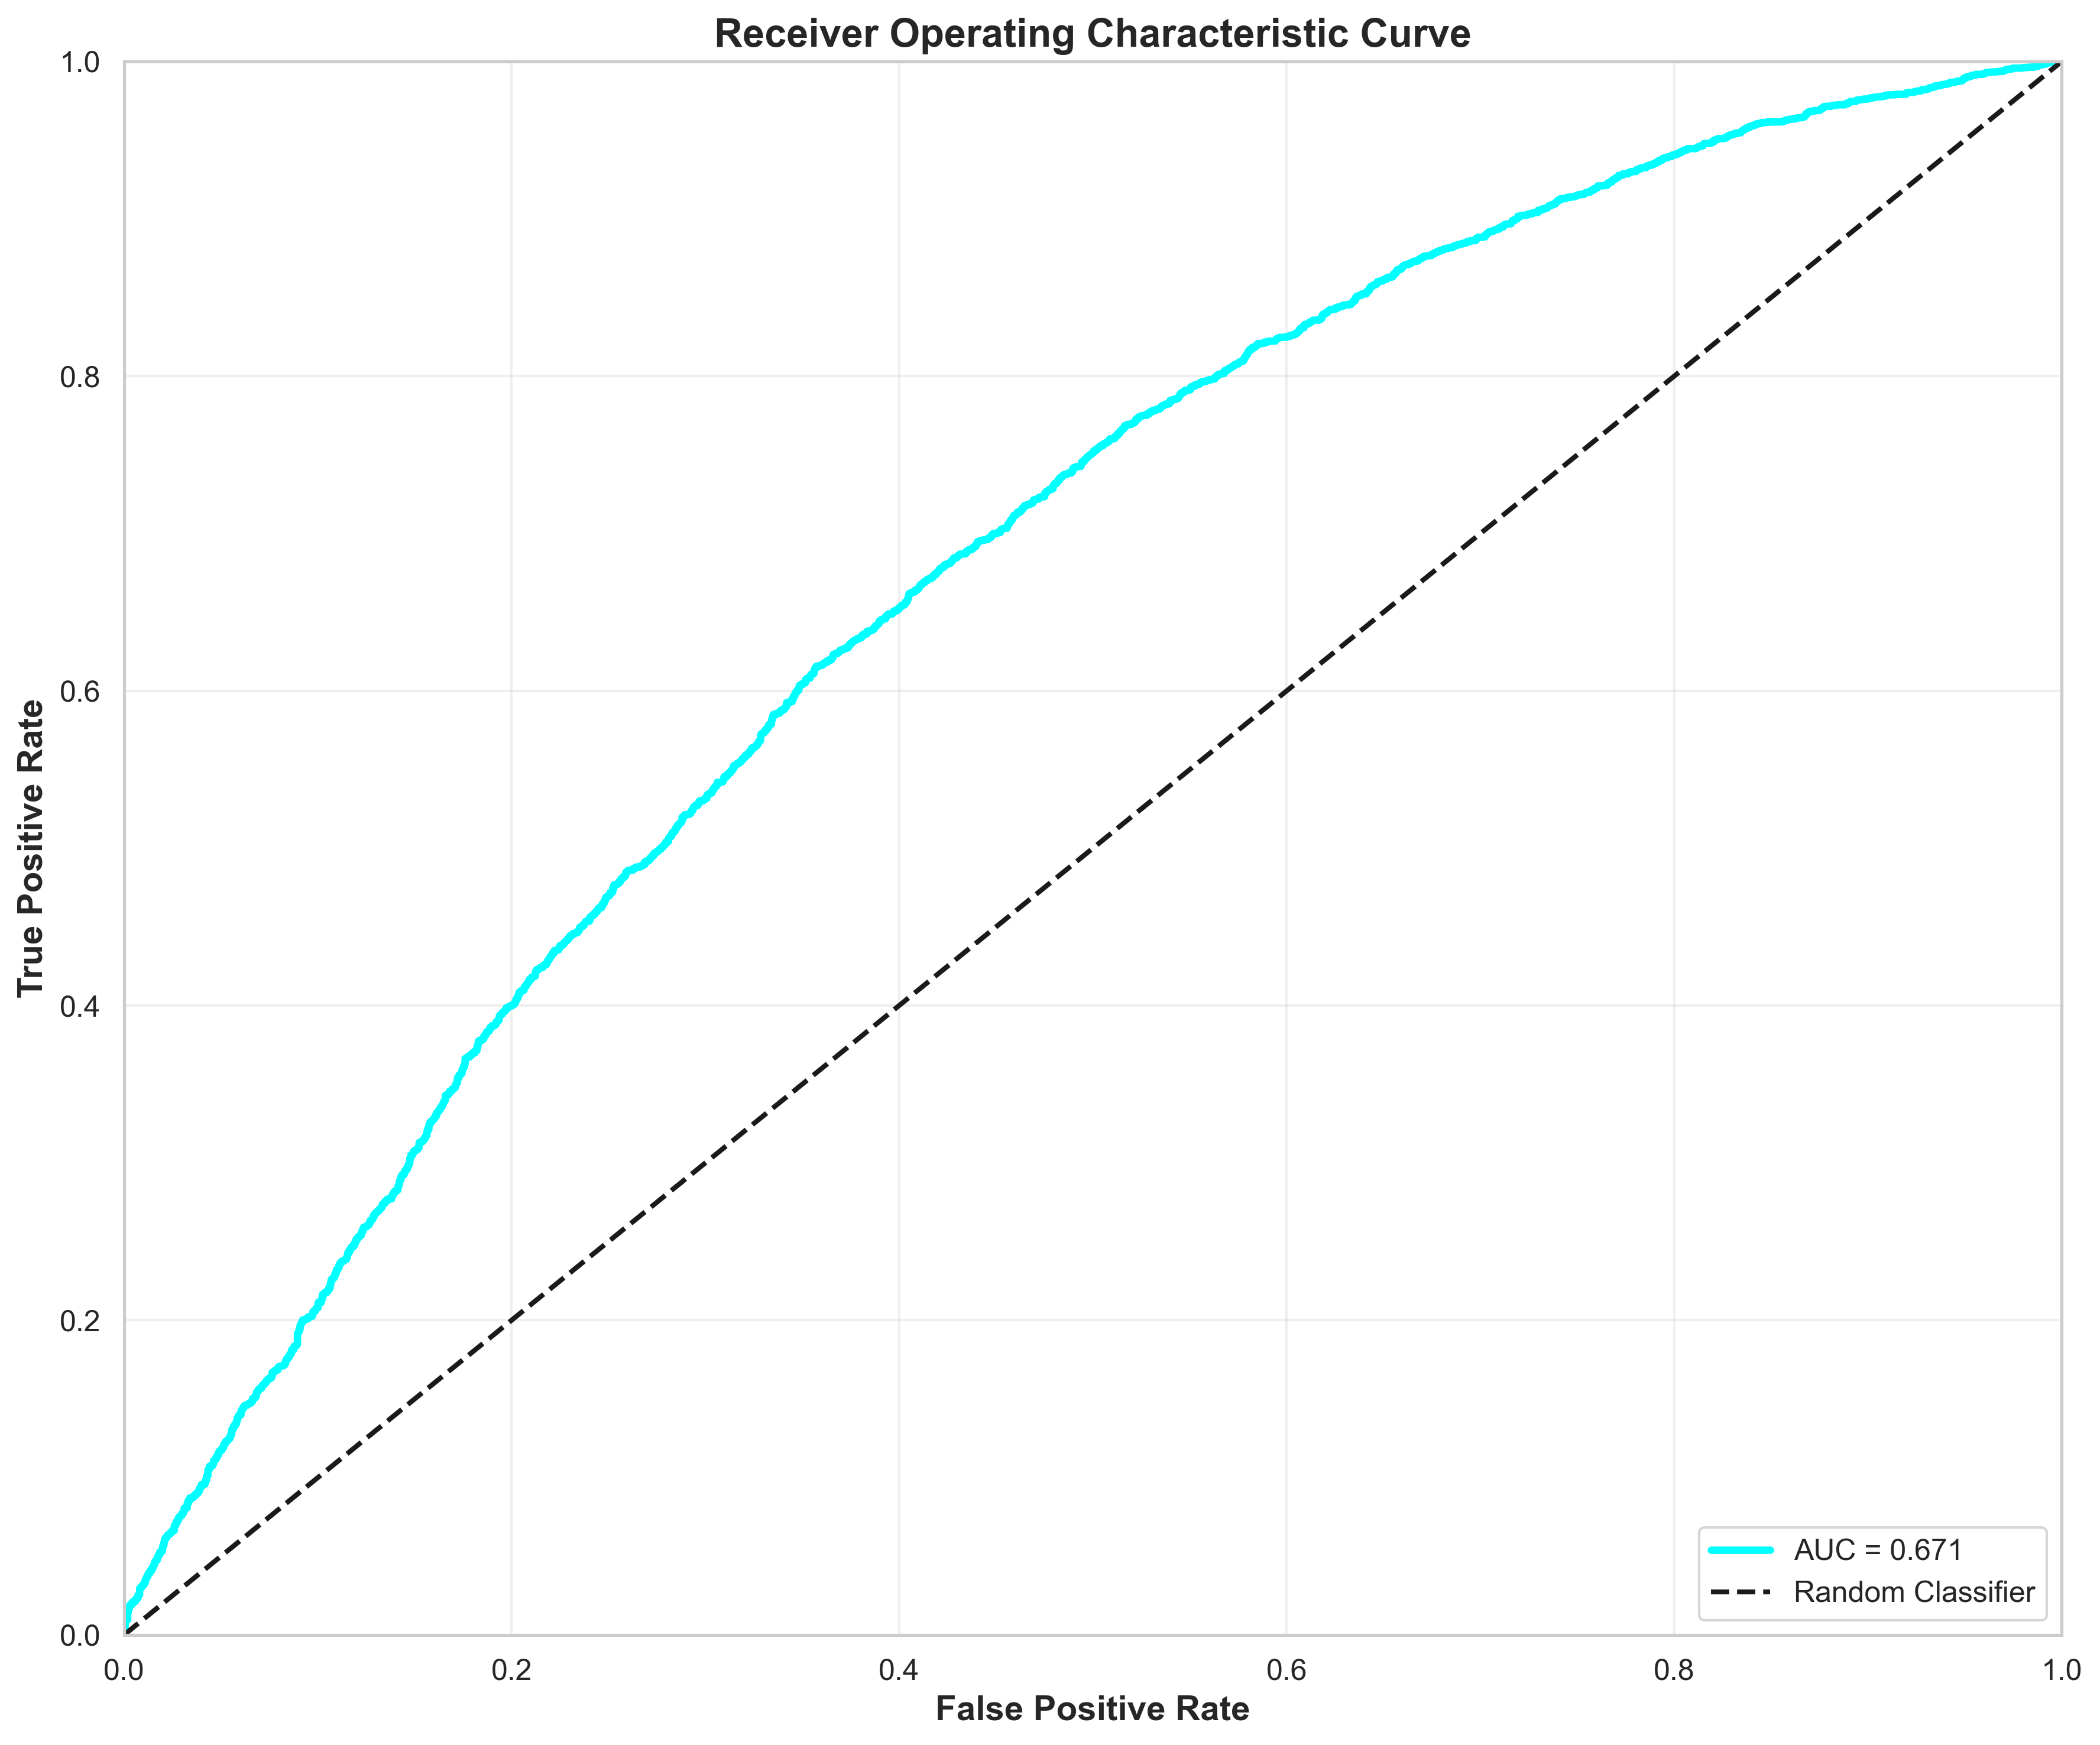

In [23]:
ROC_plot_simple(model, X_train_val, Y_train_val, X_test, Y_test)

In [17]:
nn_result = calculate_results(Y_test.round(), model.predict(X_test).reshape(-1).round())
fpr_nn, tpr_nn, thresholds_nn = evaluate(model, X_train_val, Y_train_val, X_test, Y_test)

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step
881/881 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
Test acc score: 0.6265077337874273
Train acc score: 0.6352444475980984
Classification report for the test set
              precision    recall  f1-score   support

anti up jets       0.66      0.62      0.64      3744
     up jets       0.60      0.64      0.61      3303

    accuracy                           0.63      7047
   macro avg       0.63      0.63      0.63      7047
weighted avg       0.63      0.63      0.63      7047



In [ ]:
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, Activation
from tensorflow.keras.optimizers import SGD, Adam # Changed to tensorflow.keras.optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split # For dummy data
from sklearn.preprocessing import StandardScaler # For dummy data

# --- Model Definition with Batch Normalization ---
inputs = Input(shape=(NDIM,), name = 'input') 
hidden1 = Dense(40, name = 'hidden1', kernel_initializer='normal', activation='relu')(inputs)
hidden2 = Dense(40, name = 'hidden2', kernel_initializer='normal', activation='relu')(hidden1)
outputs = Dense(1, name = 'output', kernel_initializer='normal', activation='sigmoid')(hidden2)

# Define the input layer
inputs = Input(shape=(NDIM,), name='input')

# First hidden block: Dense -> Batch Norm -> Activation
hidden1_dense = Dense(40, name='hidden1_dense', kernel_initializer='normal')(inputs)
hidden1_bn = BatchNormalization(name='hidden1_bn')(hidden1_dense)
hidden1_activation = Activation('relu', name='hidden1_activation')(hidden1_bn)

# Second hidden block: Dense -> Batch Norm -> Activation
hidden2_dense = Dense(40, name='hidden2_dense', kernel_initializer='normal')(hidden1_activation)
hidden2_bn = BatchNormalization(name='hidden2_bn')(hidden2_dense)
hidden2_activation = Activation('relu', name='hidden2_activation')(hidden2_bn)

# Output layer
outputs = Dense(1, name='output', kernel_initializer='normal', activation='sigmoid')(hidden2_activation)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
# Using Adam optimizer as in the original snippet, can also use SGD
# optimizer = SGD(learning_rate=1e-4) # As per original optimizer definition
optimizer = Adam(learning_rate=1e-3) # A common default, adjust as needed
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
print("Model Summary with Batch Normalization:")
model.summary()

# --- Callbacks (as in the original snippet) ---
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1) # Increased patience slightly

model_checkpoint = ModelCheckpoint('uubar_bn.keras', # Changed filename to reflect BN
                                   monitor='val_loss',
                                   verbose=1, # Changed to 1 for more verbosity during saving
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto')

history = model.fit(X_train_val,
                    Y_train_val,
                    epochs=5, # Few epochs for quick demo
                    batch_size=32, # Smaller batch size for demo
                    verbose=1,
                    callbacks=[early_stopping, model_checkpoint],
                    validation_data=(X_test, Y_test))

print("--- Dummy Training Complete ---")
# Evaluate the model (optional, for demonstration)
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f"\nDummy Test Loss: {loss:.4f}, Dummy Test Accuracy: {accuracy:.4f}")

Model Summary with Batch Normalization:


Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 68)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden1_dense (Dense)           │ (None, 40)             │         2,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden1_bn (BatchNormalization) │ (None, 40)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden1_activation (Activation) │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2_dense (Dense)           │ (None, 40)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2_bn (BatchNormalization) │ (None, 40)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2_activation (Activation) │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,761 (18.60 KB)

 Trainable params: 4,601 (17.97 KB)

 Non-trainable params: 160 (640.00 B)

Epoch 1/5
826/881 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - accuracy: 0.5888 - loss: 0.6655

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 3524
'y' sizes: 7047


## NN optimization

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import time


# =============================================================================
# METHOD 1: Manual Grid Search with Keras
# =============================================================================

def create_model(neurons1=40, neurons2=40, dropout_rate=0.0, learning_rate=0.001, 
                optimizer='adam', activation='relu', kernel_initializer='normal'):
    """Create and compile a neural network model with specified hyperparameters"""
    
    inputs = Input(shape=(NDIM,), name='input')
    hidden1 = Dense(neurons1, name='hidden1', kernel_initializer=kernel_initializer, 
                   activation=activation)(inputs)
    
    if dropout_rate > 0:
        hidden1 = Dropout(dropout_rate)(hidden1)
    
    hidden2 = Dense(neurons2, name='hidden2', kernel_initializer=kernel_initializer, 
                   activation=activation)(hidden1)
    
    if dropout_rate > 0:
        hidden2 = Dropout(dropout_rate)(hidden2)
    
    outputs = Dense(1, name='output', kernel_initializer=kernel_initializer, 
                   activation='sigmoid')(hidden2)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Select optimizer
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate_model(neurons1, neurons2, dropout_rate, learning_rate, 
                           optimizer, batch_size, activation='relu'):
    """Train a model with given hyperparameters and return validation accuracy"""
    
    model = create_model(neurons1=neurons1, neurons2=neurons2, 
                        dropout_rate=dropout_rate, learning_rate=learning_rate,
                        optimizer=optimizer, activation=activation)
    
    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7)
    
    # Train model
    history = model.fit(X_train_val, Y_train_val,
                       epochs=200,
                       batch_size=batch_size,
                       verbose=0,
                       callbacks=[early_stopping, reduce_lr],
                       validation_data=(X_test, Y_test))
    
    # Get best validation accuracy
    best_val_acc = max(history.history['val_accuracy'])
    
    return best_val_acc, model, history

# Define hyperparameter grid
param_grid = {
    'neurons1': [20, 40, 60, 80, 100],
    'neurons2': [20, 40, 60, 80],
    'dropout_rate': [0.0, 0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.01, 0.1, 0.0001],
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'batch_size': [64, 128, 256, 512],
    'activation': ['relu', 'tanh']
}

def manual_grid_search(param_grid, n_trials=50):
    """Perform randomized search over hyperparameters"""
    
    import random
    
    results = []
    best_score = 0
    best_params = None
    best_model = None
    
    print("Starting hyperparameter optimization...")
    print(f"Running {n_trials} trials...")
    
    for trial in range(n_trials):
        # Randomly sample parameters
        params = {key: random.choice(values) for key, values in param_grid.items()}
        
        print(f"\nTrial {trial + 1}/{n_trials}")
        print(f"Parameters: {params}")
        
        try:
            # Train and evaluate
            start_time = time.time()
            val_acc, model, history = train_and_evaluate_model(**params)
            elapsed_time = time.time() - start_time
            
            print(f"Validation Accuracy: {val_acc:.4f}")
            print(f"Time: {elapsed_time:.2f}s")
            
            # Store results
            result = params.copy()
            result['val_accuracy'] = val_acc
            result['training_time'] = elapsed_time
            results.append(result)
            
            # Update best model
            if val_acc > best_score:
                best_score = val_acc
                best_params = params.copy()
                best_model = model
                print(f"New best score: {best_score:.4f}")
                
        except Exception as e:
            print(f"Trial failed: {str(e)}")
            continue
    
    return results, best_params, best_model, best_score

# =============================================================================
# METHOD 2: Using Keras Tuner (Recommended)
# =============================================================================

# Uncomment the following if you want to use Keras Tuner
# First install: pip install keras-tuner

"""
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    
    # Input layer
    model.add(Dense(
        units=hp.Int('units_1', min_value=20, max_value=100, step=20),
        activation=hp.Choice('activation_1', ['relu', 'tanh']),
        kernel_initializer=hp.Choice('initializer', ['normal', 'uniform', 'glorot_uniform']),
        input_shape=(NDIM,)
    ))
    
    # Dropout layer
    if hp.Boolean('dropout_1'):
        model.add(Dropout(hp.Float('dropout_rate_1', 0.1, 0.5, step=0.1)))
    
    # Second hidden layer
    model.add(Dense(
        units=hp.Int('units_2', min_value=20, max_value=80, step=20),
        activation=hp.Choice('activation_2', ['relu', 'tanh']),
        kernel_initializer=hp.Choice('initializer', ['normal', 'uniform', 'glorot_uniform'])
    ))
    
    # Dropout layer
    if hp.Boolean('dropout_2'):
        model.add(Dropout(hp.Float('dropout_rate_2', 0.1, 0.5, step=0.1)))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Initialize tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=50,
    directory='hyperparameter_tuning',
    project_name='neural_network_optimization'
)

# Search for best hyperparameters
print("Starting Keras Tuner optimization...")
tuner.search(X_train, Y_train,
             epochs=100,
             validation_data=(X_val, Y_val),
             callbacks=[EarlyStopping(patience=10)],
             verbose=1)

# Get best model
best_model_kt = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters from Keras Tuner:")
for param, value in best_hyperparameters.values.items():
    print(f"{param}: {value}")
"""

# =============================================================================
# RUN OPTIMIZATION
# =============================================================================

if __name__ == "__main__":
    # Run manual grid search
    print("="*60)
    print("HYPERPARAMETER OPTIMIZATION")
    print("="*60)
    
    results, best_params, best_model, best_score = manual_grid_search(param_grid, n_trials=30)
    
    print("\n" + "="*60)
    print("OPTIMIZATION RESULTS")
    print("="*60)
    
    print(f"\nBest Validation Accuracy: {best_score:.4f}")
    print("\nBest Parameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    
    # Train final model with best parameters
    print("\n" + "="*60)
    print("TRAINING FINAL MODEL")
    print("="*60)
    
    final_model = create_model(**{k: v for k, v in best_params.items() if k != 'batch_size'})
    
    # Callbacks for final training
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', 
                                     save_best_only=True, mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-7)
    
    # Train final model
    start_time = time.time()
    history = final_model.fit(
        X_train_val, Y_train_val,
        epochs=500,
        batch_size=best_params['batch_size'],
        verbose=1,
        callbacks=[early_stopping, model_checkpoint, reduce_lr],
        validation_data=(X_test, Y_test)
    )
    
    training_time = time.time() - start_time
    print(f"\nFinal model training time: {training_time:.2f}s")
    
    # Evaluate on test set
    test_loss, test_accuracy = final_model.evaluate(X_test, Y_test, verbose=0)
    print(f"\nTest Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    
    # Make predictions
    y_pred_proba = final_model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    print("\nDetailed Classification Report:")
    print(classification_report(Y_test, y_pred))
    
    # Save results to DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('val_accuracy', ascending=False)
    print(f"\nTop 5 parameter combinations:")
    print(results_df.head()[['neurons1', 'neurons2', 'dropout_rate', 'learning_rate', 
                           'optimizer', 'batch_size', 'val_accuracy']])
    
    # Save results
    results_df.to_csv('hyperparameter_results.csv', index=False)
    print(f"\nResults saved to 'hyperparameter_results.csv'")
    print(f"Best model saved to 'best_model.keras'")

# =============================================================================
# ADDITIONAL OPTIMIZATION TECHNIQUES
# =============================================================================

def advanced_optimization():
    """Additional optimization techniques you can try"""
    
    # 1. Bayesian Optimization (requires scikit-optimize)
    """
    from skopt import gp_minimize
    from skopt.space import Real, Integer, Categorical
    from skopt.utils import use_named_args
    
    space = [
        Integer(20, 100, name='neurons1'),
        Integer(20, 80, name='neurons2'),
        Real(0.0, 0.5, name='dropout_rate'),
        Real(1e-5, 1e-1, prior='log-uniform', name='learning_rate'),
        Categorical(['adam', 'sgd', 'rmsprop'], name='optimizer'),
        Integer(64, 512, name='batch_size')
    ]
    
    @use_named_args(space)
    def objective(**params):
        val_acc, _, _ = train_and_evaluate_model(**params)
        return -val_acc  # Minimize negative accuracy
    
    # Run Bayesian optimization
    result = gp_minimize(objective, space, n_calls=50, random_state=42)
    """
    
    # 2. Learning Rate Scheduling
    def create_model_with_lr_schedule():
        model = create_model()
        
        # Learning rate schedule
        def scheduler(epoch, lr):
            if epoch < 10:
                return lr
            else:
                return lr * tf.math.exp(-0.1)
        
        lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)
        return model, lr_scheduler
    
    # 3. Cross-validation for more robust evaluation
    from sklearn.model_selection import StratifiedKFold
    
    def cross_validate_model(params, cv_folds=5):
        skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
        cv_scores = []
        
        for train_idx, val_idx in skf.split(X_train_val, Y_train_val):
            X_train_cv, X_val_cv = X_train_val[train_idx], X_train_val[val_idx]
            Y_train_cv, Y_val_cv = Y_train_val[train_idx], Y_train_val[val_idx]
            
            model = create_model(**{k: v for k, v in params.items() if k != 'batch_size'})
            
            history = model.fit(X_train_cv, Y_train_cv,
                              epochs=100,
                              batch_size=params['batch_size'],
                              verbose=0,
                              validation_data=(X_val_cv, Y_val_cv),
                              callbacks=[EarlyStopping(patience=10)])
            
            cv_scores.append(max(history.history['val_accuracy']))
        
        return np.mean(cv_scores), np.std(cv_scores)

print("\nHyperparameter optimization setup complete!")
print("Run the code to start optimization process.")

HYPERPARAMETER OPTIMIZATION
Starting hyperparameter optimization...
Running 30 trials...

Trial 1/30
Parameters: {'neurons1': 40, 'neurons2': 40, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'optimizer': 'sgd', 'batch_size': 128, 'activation': 'tanh'}
Validation Accuracy: 0.6098
Time: 47.57s
New best score: 0.6098

Trial 2/30
Parameters: {'neurons1': 60, 'neurons2': 40, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'optimizer': 'adam', 'batch_size': 512, 'activation': 'relu'}
Validation Accuracy: 0.6279
Time: 6.49s
New best score: 0.6279

Trial 3/30
Parameters: {'neurons1': 80, 'neurons2': 20, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'optimizer': 'rmsprop', 'batch_size': 256, 'activation': 'tanh'}
Validation Accuracy: 0.6284
Time: 20.02s
New best score: 0.6284

Trial 4/30
Parameters: {'neurons1': 100, 'neurons2': 60, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'optimizer': 'adam', 'batch_size': 512, 'activation': 'relu'}
Validation Accuracy: 0.6276
Time: 3.40s

Trial 5/30
Parameters

In [ ]:
'''
Best Validation Accuracy: 0.6284

Best Parameters:
  neurons1: 80
  neurons2: 20
  dropout_rate: 0.3
  learning_rate: 0.001
  optimizer: rmsprop
  batch_size: 256
  activation: tanh
'''

'\nBest Validation Accuracy: 0.6284\n\nBest Parameters:\n  neurons1: 80\n  neurons2: 20\n  dropout_rate: 0.3\n  learning_rate: 0.001\n  optimizer: rmsprop\n  batch_size: 256\n  activation: tanh\n'

In [38]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt


# 1. Define the model-building function for Keras Tuner
def build_model(hp):
    """
    Builds a Keras model with hyperparameters defined by Keras Tuner.

    Args:
        hp (keras_tuner.HyperParameters): HyperParameters object from Keras Tuner.

    Returns:
        keras.Model: Compiled Keras model.
    """
    inputs = Input(shape=(NDIM,), name = 'input') 
    
    # Tune the number of units in the first hidden layer
    hp_units_1 = hp.Int('units_1', min_value=16, max_value=128, step=16)
    # Tune the activation function for the first hidden layer
    hp_activation_1 = hp.Choice('activation_1', values=['relu', 'tanh', 'sigmoid'])
    
    hidden1 = Dense(units=hp_units_1, name = 'hidden1', kernel_initializer='normal', activation=hp_activation_1)(inputs)
    
    # Tune the number of units in the second hidden layer
    hp_units_2 = hp.Int('units_2', min_value=16, max_value=128, step=16)
    # Tune the activation function for the second hidden layer
    hp_activation_2 = hp.Choice('activation_2', values=['relu', 'tanh', 'sigmoid'])

    hidden2 = Dense(units=hp_units_2, name = 'hidden2', kernel_initializer='normal', activation=hp_activation_2)(hidden1)
    
    outputs = Dense(1, name = 'output', kernel_initializer='normal', activation='sigmoid')(hidden2)

    model = Model(inputs=inputs, outputs=outputs)
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')
    
    # Tune the optimizer
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])

    if hp_optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=hp_learning_rate)
    else: # rmsprop
        optimizer = keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
        
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# 2. Instantiate the tuner
# Other tuners available: Hyperband, BayesianOptimization
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',  # We want to maximize validation accuracy
    max_trials=10,             # Number of different hyperparameter combinations to try
    executions_per_trial=2,    # Number of models to train per trial (for robustness)
    directory='keras_tuner_dir', # Directory to store results
    project_name='dnn_hyper_opt'
)

# Print search space summary
tuner.search_space_summary()

# Callbacks for the search
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
# ModelCheckpoint is handled by the tuner internally for saving the best trial model.
# If you need to save checkpoints during each trial's training, you can add it here.

print("\nStarting hyperparameter search...")
start_time = time.time()

# 3. Run the hyperparameter search
# The tuner will call model.fit() internally
tuner.search(X_train_val, 
             Y_train_val, 
             epochs=50, # Reduce epochs for search, full training later
             batch_size=512, 
             validation_data=(X_test, Y_test),
             callbacks=[early_stopping] # Add early stopping to speed up search
            )

search_elapsed_time = time.time() - start_time
print(f"Hyperparameter search completed in {search_elapsed_time:.2f} seconds.")

# 4. Retrieve the best hyperparameters and the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. 
The optimal number of units in the first densely-connected layer is {best_hps.get('units_1')} 
and the optimal activation function is {best_hps.get('activation_1')}.
The optimal number of units in the second densely-connected layer is {best_hps.get('units_2')}
and the optimal activation function is {best_hps.get('activation_2')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
The optimal optimizer is {best_hps.get('optimizer')}.
""")

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

# Train the best model with more epochs and the original callbacks
print("\nTraining the best model with optimal hyperparameters...")
start_training_time = time.time()

# Model checkpoint callback for the final best model
model_checkpoint = ModelCheckpoint('best_dnn_model.keras', monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto')

history = best_model.fit(X_train_val, 
                         Y_train_val, 
                         epochs=1000, # Full training epochs
                         batch_size=512, 
                         verbose=1, 
                         callbacks=[early_stopping, model_checkpoint], 
                         validation_data=(X_test, Y_test))

training_elapsed_time = time.time() - start_training_time
print(f"Time taken for training the best model: {training_elapsed_time:.1f}s")

# Evaluate the best model on the test set
print("\nEvaluating the best model on the test set:")
loss, accuracy = best_model.load_weights('best_dnn_model.keras') # Load best weights
loss, accuracy = best_model.evaluate(X_test, Y_test, verbose=0)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# You can also get the best models directly
# models = tuner.get_best_models(num_models=2)
# best_model_from_tuner = models[0]
# best_model_from_tuner.evaluate(X_test, Y_test)

# You can view the search results in detail
# tuner.results_summary()


Trial 10 Complete [00h 00m 16s]
val_accuracy: 0.5659855008125305

Best val_accuracy So Far: 0.6219667792320251
Total elapsed time: 00h 02m 07s
Hyperparameter search completed in 127.46 seconds.

The hyperparameter search is complete. 
The optimal number of units in the first densely-connected layer is 48 
and the optimal activation function is relu.
The optimal number of units in the second densely-connected layer is 96
and the optimal activation function is tanh.
The optimal learning rate for the optimizer is 3.815268736792943e-05.
The optimal optimizer is adam.



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 68)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden1 (Dense)                 │ (None, 48)             │         3,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 96)             │         4,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,113 (31.69 KB)

 Trainable params: 8,113 (31.69 KB)

 Non-trainable params: 0 (0.00 B)


Training the best model with optimal hyperparameters...
Epoch 1/1000
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.5028 - loss: 0.6928 
Epoch 1: val_loss improved from inf to 0.68791, saving model to best_dnn_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5035 - loss: 0.6927 - val_accuracy: 0.5763 - val_loss: 0.6879
Epoch 2/1000
 1/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5957 - loss: 0.6864
Epoch 2: val_loss improved from 0.68791 to 0.68192, saving model to best_dnn_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5702 - loss: 0.6868 - val_accuracy: 0.5824 - val_loss: 0.6819
Epoch 3/1000
 1/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5625 - loss: 0.6844
Epoch 3: val_loss improved from 0.68192 to 0.67650, saving model to best_dnn_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5775 - loss: 0.6818 - val_accuracy: 0.5851 - val_loss: 0.6765
Epoch 4/1000
 1/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6348 

TypeError: cannot unpack non-iterable NoneType object

In [40]:
# You can also get the best models directly
models = tuner.get_best_models(num_models=2)
best_model_from_tuner = models[0]
best_model_from_tuner.evaluate(X_test, Y_test)

# You can view the search results in detail
#tuner.results_summary()

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - accuracy: 0.6243 - loss: 0.6494


[0.6495019197463989, 0.6231020092964172]

In [28]:
import numpy as np
from tensorflow import keras
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier

# Ensure NDIM is defined
NDIM = len(final_df.keys()) - 1

# Define the function to make the model
def make_model(network_layers=(32, 32),
               dropout_rate=0.0,
               optimizer="Nadam",
               activation="selu",
               k_initializer='lecun_normal',
               n_input=NDIM,
               n_class=1):
    
    model = keras.models.Sequential()    
    model.add(keras.layers.Input(shape=(NDIM,)))

    for index, layers in enumerate(network_layers):
        model.add(keras.layers.Dense(layers,
                                         kernel_initializer=k_initializer,
                                         activation=activation))
        if dropout_rate > 0:
            model.add(keras.layers.Dropout(dropout_rate))
            #model.add(keras.layers.AlphaDropout(dropout_rate))

    model.add(keras.layers.Dense(n_class,
                                 activation="sigmoid"))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

# Define the main function for optimization
def opt_model():
    keras_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KerasClassifier(
            model=make_model,
            network_layers=(32, 32),  # Default values
            dropout_rate=0.0,         # Default values
            optimizer="Nadam",        # Default values
            activation="selu",        # Default values
            k_initializer='lecun_normal',  # Default values
            verbose=0,
            n_input=NDIM,
            n_class=1
        ))
    ])
    
    param_grid = {
        'clf__network_layers': [(32, 32), (32, 32, 32), (64, 64), (128, 128, 128)],
        'clf__batch_size': [64, 128, 256, 512],
        'clf__epochs': [5, 10, 15, 50, 100, 200],
        'clf__dropout_rate': [0.2, 0.1, 0.01],
        'clf__optimizer': ['Nadam', 'Adam', 'SGD'],
        'clf__activation': ['selu', 'relu', 'tanh'],
        'clf__k_initializer': ['lecun_normal', 'normal'],
        'clf__verbose': [0]
    }
    
    rs_keras = RandomizedSearchCV(
        keras_pipeline,
        param_distributions=param_grid,
        cv=5,
        refit=True,
        verbose=0,
        n_iter=5,
        scoring="accuracy"
    )
    
    history = rs_keras.fit(X_train_val, Y_train_val)
    
    print('Best score obtained: {0}'.format(rs_keras.best_score_))
    print('Parameters:')
    for param, value in rs_keras.best_params_.items():
        print('\t{}: {}'.format(param, value))
    
    return rs_keras  


# Set this to true if you want to optimize
do_opt = True
if do_opt:
    if __name__ == '__main__':
        optimal_model = opt_model()


C:\Users\meisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\meisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "C:\Users\meisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\meisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\l

Best score obtained: nan
Parameters:
	clf__verbose: 0
	clf__optimizer: SGD
	clf__network_layers: (32, 32, 32)
	clf__k_initializer: lecun_normal
	clf__epochs: 5
	clf__dropout_rate: 0.1
	clf__batch_size: 128
	clf__activation: relu


In [107]:
'''
Best Validation Accuracy: 0.6284

Best Parameters:
  neurons1: 80
  neurons2: 20
  dropout_rate: 0.3
  learning_rate: 0.001
  optimizer: rmsprop
  batch_size: 256
  activation: tanh
'''

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

NDIM = len(final_df.keys()) - 1

opt_model = models.Sequential()
opt_model.add(layers.Dense(80,  kernel_initializer='normal', activation='tanh', input_shape=(NDIM,)))
opt_model.add(layers.Dropout(0.3))
opt_model.add(layers.Dense(20,  kernel_initializer='normal', activation='tanh'))
opt_model.add(layers.Dropout(0.3))
#opt_model.add(layers.Dense(128,  kernel_initializer='normal', activation='tanh'))
#opt_model.add(layers.Dropout(0.1))
opt_model.add(layers.Dense(1, kernel_initializer='normal', activation='sigmoid'))

# compile the model
opt_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
# print the model summary
opt_model.summary()

# early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

# Train classifier
import time
start = time.time() # time at start of whole processing

opt_history = opt_model.fit(X_train_val,
                    Y_train_val,
                    epochs=50,
                    batch_size=256,
                    verbose=1, # switch to 1 for more verbosity 
                    #callbacks=[early_stopping],
                    validation_data=(X_test,Y_test))

elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

C:\Users\meisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 80)             │         5,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 20)             │         1,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,161 (27.97 KB)

 Trainable params: 7,161 (27.97 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5806 - loss: 0.6741 - val_accuracy: 0.6031 - val_loss: 0.6587
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6044 - loss: 0.6602 - val_accuracy: 0.6072 - val_loss: 0.6579
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5987 - loss: 0.6615 - val_accuracy: 0.6082 - val_loss: 0.6545
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6051 - loss: 0.6582 - val_accuracy: 0.6123 - val_loss: 0.6519
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6048 - loss: 0.6567 - val_accuracy: 0.6110 - val_loss: 0.6517
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6041 - loss: 0.6588 - val_accuracy: 0.6119 - val_loss: 0.6528
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5989 - loss: 0.6599 - val_accuracy: 0.6179 - val_loss: 0.6495
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6097 - loss: 0.6555 - val_accuracy: 0.

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step
881/881 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


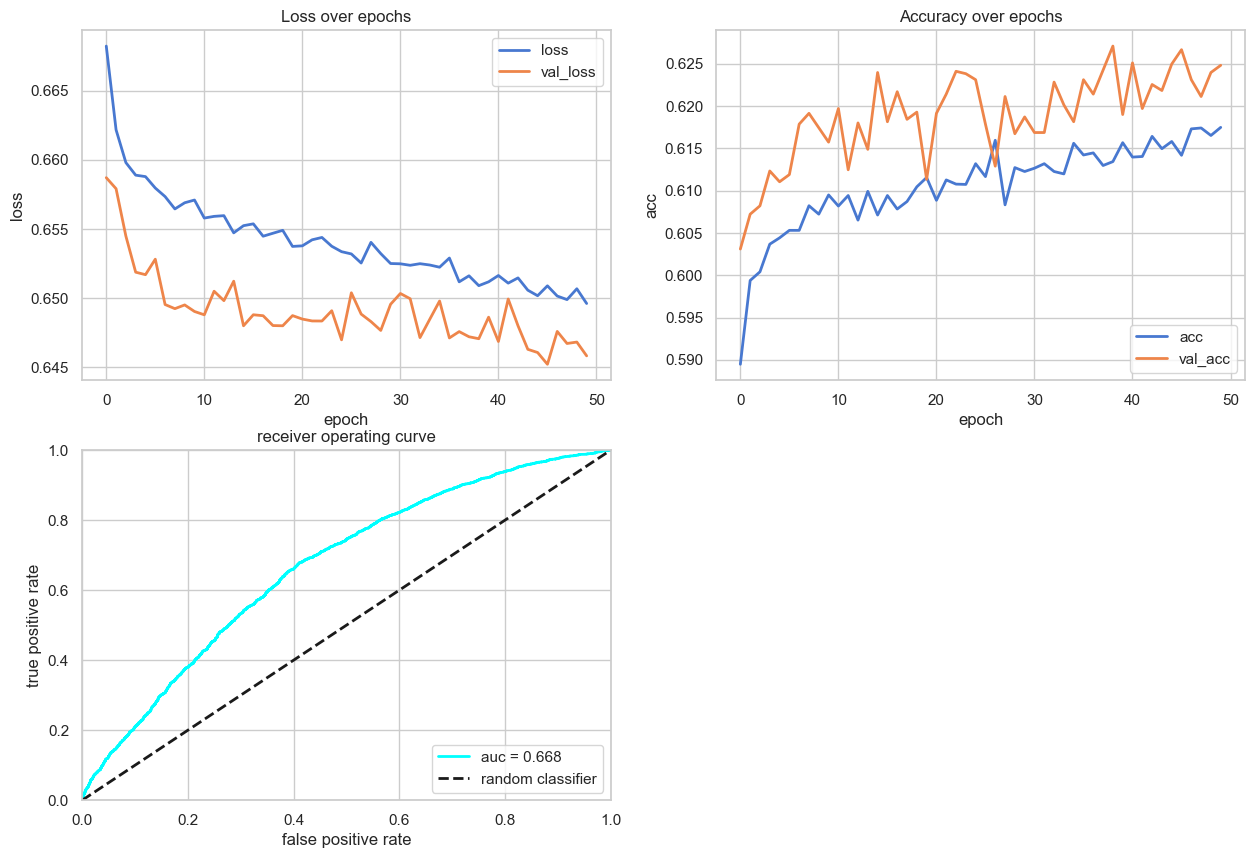

In [108]:
loss_accuracy_plotter(opt_history, opt_model, X_train_val, Y_train_val, X_test, Y_test)

In [97]:
import numpy as np
from tensorflow import keras
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier

# Ensure NDIM is defined
NDIM = len(final_df.keys()) - 1

# Define the function to make the model
def make_model(network_layers=(32, 32),
               dropout_rate=0.0,
               optimizer="Nadam",
               activation="selu",
               k_initializer='lecun_normal',
               n_input=NDIM,
               n_class=1):
    
    model = keras.models.Sequential()    
    model.add(keras.layers.Input(shape=(NDIM,)))

    for index, layers in enumerate(network_layers):
        model.add(keras.layers.Dense(layers,
                                         kernel_initializer=k_initializer,
                                         activation=activation))
        if dropout_rate > 0:
            model.add(keras.layers.Dropout(dropout_rate))
            #model.add(keras.layers.AlphaDropout(dropout_rate))

    model.add(keras.layers.Dense(n_class,
                                 activation="sigmoid"))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

# Define the main function for optimization
def opt_model():
    keras_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KerasClassifier(
            model=make_model,
            network_layers=(32, 32),  # Default values
            dropout_rate=0.0,         # Default values
            optimizer="Nadam",        # Default values
            activation="selu",        # Default values
            k_initializer='lecun_normal',  # Default values
            verbose=0,
            n_input=NDIM,
            n_class=1
        ))
    ])
    
    param_grid = {
        'clf__network_layers': [(32, 32), (32, 32, 32), (64, 64), (128, 128, 128)],
        'clf__batch_size': [64, 128, 256, 512],
        'clf__epochs': [5, 10, 15, 50, 100, 200],
        'clf__dropout_rate': [0.2, 0.1, 0.01],
        'clf__optimizer': ['Nadam', 'Adam', 'SGD'],
        'clf__activation': ['selu', 'relu', 'tanh'],
        'clf__k_initializer': ['lecun_normal', 'normal'],
        'clf__verbose': [0]
    }
    
    rs_keras = RandomizedSearchCV(
        keras_pipeline,
        param_distributions=param_grid,
        cv=5,
        refit=True,
        verbose=0,
        n_iter=5,
        scoring="accuracy"
    )
    
    history = rs_keras.fit(X_train_val, Y_train_val)
    
    print('Best score obtained: {0}'.format(rs_keras.best_score_))
    print('Parameters:')
    for param, value in rs_keras.best_params_.items():
        print('\t{}: {}'.format(param, value))
    
    return rs_keras  


# Set this to true if you want to optimize
do_opt = True
if do_opt:
    if __name__ == '__main__':
        optimal_model = opt_model()


Best score obtained: 0.6125686256252623
Parameters:
	clf__verbose: 0
	clf__optimizer: SGD
	clf__network_layers: (32, 32, 32)
	clf__k_initializer: normal
	clf__epochs: 200
	clf__dropout_rate: 0.2
	clf__batch_size: 64
	clf__activation: tanh


In [24]:
# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

NDIM = len(final_df.keys()) - 1

opt_model = models.Sequential()
opt_model.add(layers.Dense(32,  kernel_initializer='normal', activation='tanh', input_shape=(NDIM,)))
opt_model.add(layers.Dropout(0.2))
opt_model.add(layers.Dense(32,  kernel_initializer='normal', activation='tanh'))
opt_model.add(layers.Dropout(0.2))
opt_model.add(layers.Dense(32,  kernel_initializer='normal', activation='tanh'))
opt_model.add(layers.Dropout(0.2))
opt_model.add(layers.Dense(1, kernel_initializer='normal', activation='sigmoid'))

# compile the model
opt_model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])
# print the model summary
opt_model.summary()

# early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

# Train classifier
import time
start = time.time() # time at start of whole processing

opt_history = opt_model.fit(X_train_val,
                    Y_train_val,
                    epochs=30,
                    batch_size=64,
                    verbose=1, # switch to 1 for more verbosity 
                    #callbacks=[early_stopping],
                    validation_data=(X_test,Y_test))

elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

C:\Users\meisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_93 (Dense)                │ (None, 32)             │         2,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353 (17.00 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5408 - loss: 0.6916 - val_accuracy: 0.5327 - val_loss: 0.6884
Epoch 2/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.5341 - loss: 0.6884 - val_accuracy: 0.5564 - val_loss: 0.6848
Epoch 3/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.5483 - loss: 0.6856 - val_accuracy: 0.5741 - val_loss: 0.6798
Epoch 4/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.5706 - loss: 0.6805 - val_accuracy: 0.5757 - val_loss: 0.6746
Epoch 5/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.5778 - loss: 0.6763 - val_accuracy: 0.5831 - val_loss: 0.6707
Epoch 6/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.5829 - loss: 0.6742 - val_accuracy: 0.5888 - val_loss: 0.6673
Epoch 7/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - accuracy: 0.5853 - loss: 0.6708 - val_accuracy: 0.5957 - val_loss: 0.6639
Epoch 8/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.5890 - loss: 0.6669 - va

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step
881/881 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


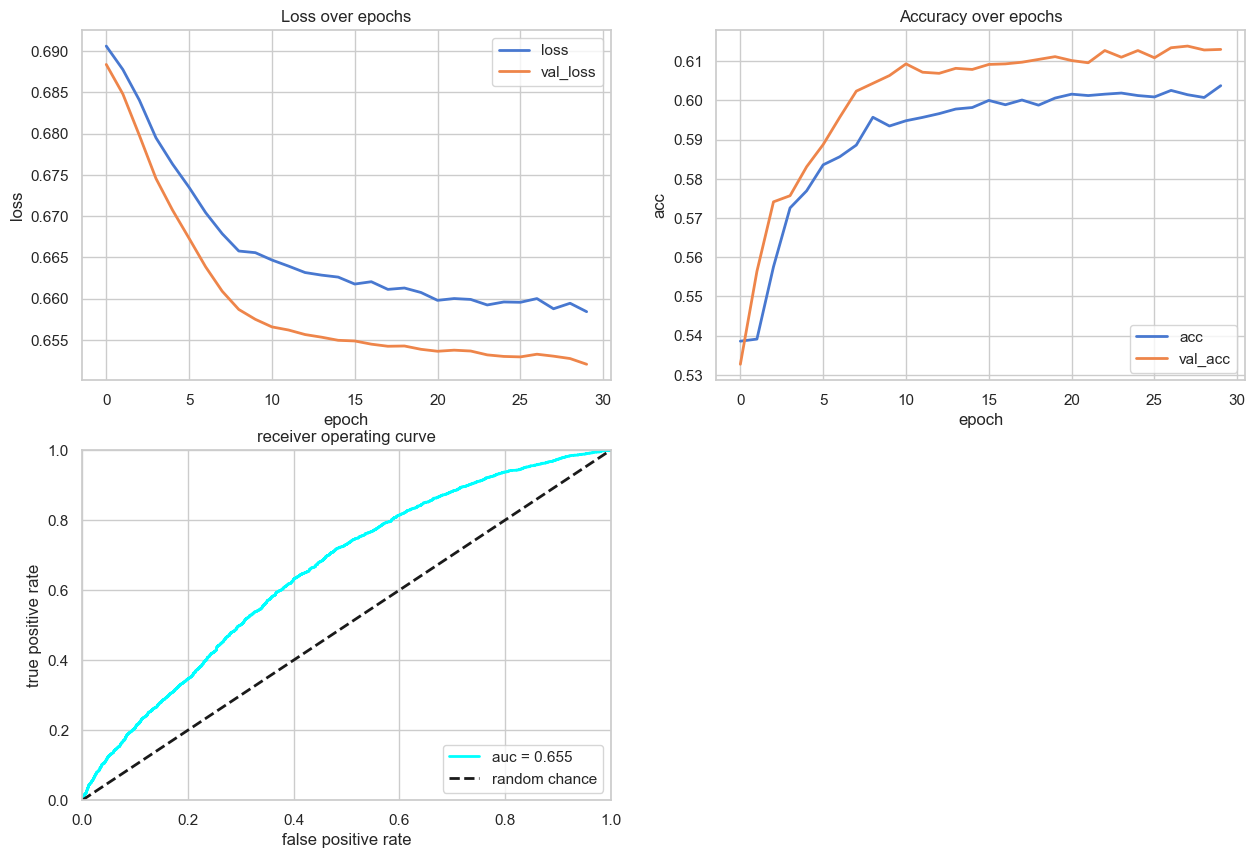

In [25]:
loss_accuracy_plotter(opt_history, opt_model, X_train_val, Y_train_val, X_test, Y_test)

In [21]:
opt_nn_result = calculate_results(Y_test.round(), opt_model.predict(X_test).reshape(-1).round())
fpr_nn, tpr_nn, thresholds_nn = evaluate(opt_model, X_train_val, Y_train_val, X_test, Y_test)

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
881/881 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step
Test acc score: 0.6101887327940968
Train acc score: 0.6045909316682041
Classification report for the test set
              precision    recall  f1-score   support

anti up jets       0.63      0.65      0.64      3744
     up jets       0.59      0.57      0.58      3303

    accuracy                           0.61      7047
   macro avg       0.61      0.61      0.61      7047
weighted avg       0.61      0.61      0.61      7047



## Other classifiers

## GNN

In [23]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Sample data (22498, 68) numpy array
X = np.random.rand(22498, 68)
Y = np.random.choice([0, 1], 22498)

# Preprocess the data: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create edge index for a fully connected graph
# For demonstration, a simple fully connected graph is created.
# In practice, you should create an edge_index based on your data's graph structure.
edge_index = torch.tensor(np.array([(i, j) for i in range(len(X)) for j in range(len(X)) if i != j]).T, dtype=torch.long)

# Convert data to torch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float)
Y_tensor = torch.tensor(Y, dtype=torch.long)

# Create a PyTorch Geometric data object
data = Data(x=X_tensor, edge_index=edge_index, y=Y_tensor)

# Split the data into training and testing sets
train_mask, test_mask = train_test_split(np.arange(len(Y)), test_size=0.2, random_state=42)

# Create masks for PyTorch Geometric
data.train_mask = torch.tensor(train_mask, dtype=torch.long)
data.test_mask = torch.tensor(test_mask, dtype=torch.long)

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Create the model
model = GCN(in_channels=68, hidden_channels=16, out_channels=2)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Testing function
def test():
    model.eval()
    _, pred = model(data).max(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / data.test_mask.size(0)
    return acc

# Training loop
for epoch in range(200):
    loss = train()
    if epoch % 10 == 0:
        acc = test()
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}')

# Final test accuracy
acc = test()
print(f'Final Test Accuracy: {acc:.4f}')


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Other ML

### SVC

In [15]:
print(X_train_val.shape)
print(type(X_train_val))

(28186, 68)
<class 'numpy.ndarray'>


In [16]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Count NaNs in each column
NDIM = len(final_df.keys()) - 1
df_nonan = final_df.copy()
df_nonan = df_nonan.dropna()
#print(df_nonan.isna().sum())
dataset_nonan = df_nonan.values
X = dataset_nonan[:,0:NDIM]
Y = dataset_nonan[:,NDIM]

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [26]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Count NaNs in each column
df_nonan = final_df.copy()
df_nonan = df_nonan.dropna()
#print(df_nonan.isna().sum())
dataset_nonan = df_nonan.values
X = dataset_nonan[:,0:NDIM]
Y = dataset_nonan[:,NDIM]

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

svm_model = SVC(kernel='linear', C=1, random_state=42)  # Using a linear kernel and C=1 for simplicity
svm_model.fit(X_train, Y_train)

Y_pred = svm_model.predict(X_val)

accuracy = accuracy_score(Y_val, Y_pred)
classification_rep = classification_report(Y_val, Y_pred)
conf_matrix = confusion_matrix(Y_val, Y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_rep)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.60
Classification Report:
              precision    recall  f1-score   support

         0.0       0.61      0.65      0.63      3701
         1.0       0.58      0.54      0.56      3346

    accuracy                           0.60      7047
   macro avg       0.60      0.59      0.59      7047
weighted avg       0.60      0.60      0.60      7047

Confusion Matrix:
[[2406 1295]
 [1540 1806]]


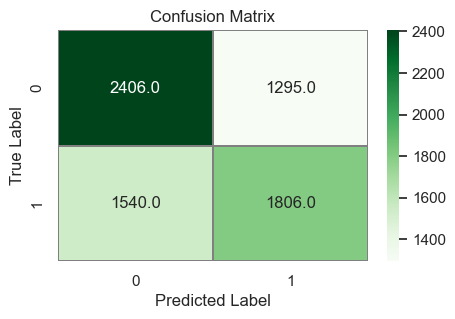

In [27]:
# plot the confusion matrix
f,ax = plt.subplots(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [28]:
svm_lin_result = calculate_results(Y_test.round(), svm_model.predict(X_test).reshape(-1).round())

In [26]:
svm_model_poly = SVC(kernel='poly', C=1, random_state=42)  # Using a linear kernel and C=1 for simplicity
svm_model_poly.fit(X_train, Y_train)

Y_pred = svm_model_poly.predict(X_val)

accuracy_poly = accuracy_score(Y_val, Y_pred)
classification_rep_poly = classification_report(Y_val, Y_pred)
conf_matrix_poly = confusion_matrix(Y_val, Y_pred)

print(f"Accuracy: {accuracy_poly:.2f}")
print("Classification Report:")
print(classification_rep_poly)
print("Confusion Matrix:")
print(conf_matrix_poly)

Accuracy: 0.60
Classification Report:
              precision    recall  f1-score   support

         0.0       0.59      0.75      0.66      3701
         1.0       0.61      0.42      0.50      3346

    accuracy                           0.60      7047
   macro avg       0.60      0.59      0.58      7047
weighted avg       0.60      0.60      0.58      7047

Confusion Matrix:
[[2793  908]
 [1946 1400]]


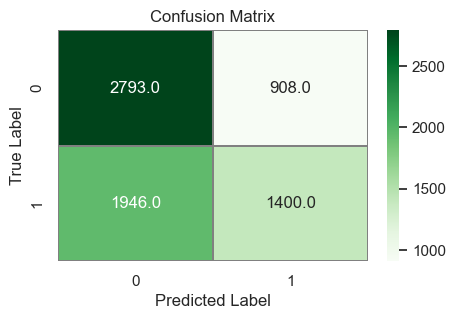

In [27]:
# plot the confusion matrix
f,ax = plt.subplots(figsize=(5, 3))
sns.heatmap(conf_matrix_poly, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [28]:
svm_poly_result = calculate_results(Y_test.round(), svm_model_poly.predict(X_test).reshape(-1).round())

In [29]:
svm_model_rbf = SVC(kernel='rbf', gamma=0.5, C=1.0, random_state=42)  # Using a linear kernel and C=1 for simplicity
svm_model_rbf.fit(X_train, Y_train)

Y_pred = svm_model_rbf.predict(X_val)

accuracy_rbf = accuracy_score(Y_val, Y_pred)
classification_rep_rbf = classification_report(Y_val, Y_pred)
conf_matrix_rbf = confusion_matrix(Y_val, Y_pred)

print(f"Accuracy: {accuracy_rbf:.2f}")
print("Classification Report:")
print(classification_rep_rbf)
print("Confusion Matrix:")
print(conf_matrix_rbf)

Accuracy: 0.53
Classification Report:
              precision    recall  f1-score   support

         0.0       0.53      1.00      0.69      3701
         1.0       0.70      0.00      0.01      3346

    accuracy                           0.53      7047
   macro avg       0.61      0.50      0.35      7047
weighted avg       0.61      0.53      0.37      7047

Confusion Matrix:
[[3695    6]
 [3332   14]]


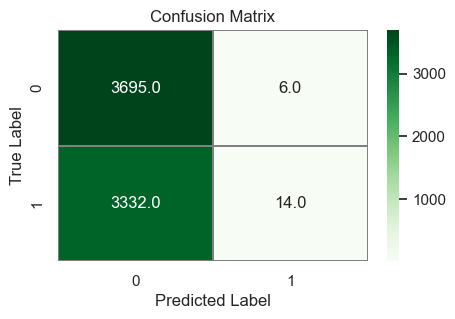

In [30]:
# plot the confusion matrix
f,ax = plt.subplots(figsize=(5, 3))
sns.heatmap(conf_matrix_rbf, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [31]:
svm_rbf_result = calculate_results(Y_test.round(), svm_model_rbf.predict(X_test).reshape(-1).round())

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Random forest

Time taken: 21.5s
Test accuracy: 0.6182772811125301
Classification report for the test set
              precision    recall  f1-score   support

anti up jets       0.64      0.64      0.64      3744
     up jets       0.59      0.59      0.59      3303

    accuracy                           0.62      7047
   macro avg       0.62      0.62      0.62      7047
weighted avg       0.62      0.62      0.62      7047



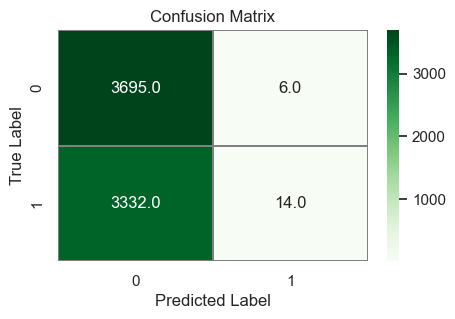

In [32]:
from sklearn.ensemble import RandomForestClassifier

start = time.time() 
# the parameters for initializing are called hyperprameters
#RF_clf = RandomForestClassifier(criterion='gini', max_depth=8, n_estimators=1000, random_state=420) # initialise your random forest classifier
RF_clf = RandomForestClassifier(random_state=420) 
RF_clf.fit(X_train_val, Y_train_val) 
elapsed = time.time() - start 
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

y_pred_RF = RF_clf.predict(X_test) # make predictions on the test data

print("Test accuracy:", accuracy_score(Y_test, y_pred_RF))
print("Classification report for the test set")
print(classification_report(Y_test.round(), y_pred_RF.round(), target_names=['anti up jets', 'up jets']))

accuracy_poly = accuracy_score(Y_val, Y_pred)
classification_rep_poly = classification_report(Y_val, Y_pred)
conf_matrix_poly = confusion_matrix(Y_val, Y_pred)
conf_matrix_poly = confusion_matrix(Y_val, Y_pred)
f,ax = plt.subplots(figsize=(5, 3))
sns.heatmap(conf_matrix_poly, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [33]:
rf_result = calculate_results(Y_test.round(), RF_clf.predict(X_test).reshape(-1).round())

In [ ]:
# Get numerical feature importances
VARS = list(final_df.columns)
feature_list = VARS
feature_list[-1] = 'NonSM Top mass'

importances = list(RF_clf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

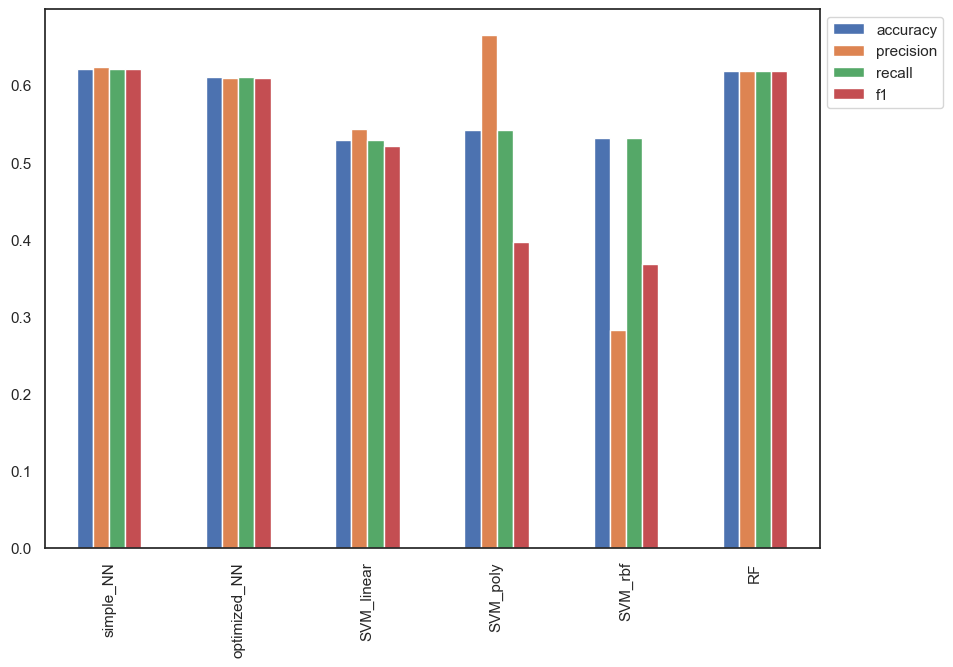

In [34]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"simple_NN": nn_result,
                                  "optimized_NN": opt_nn_result,
                                  "SVM_linear": svm_lin_result,
                                  "SVM_poly": svm_poly_result,
                                  "SVM_rbf": svm_rbf_result,
                                  "RF": rf_result})
all_model_results = all_model_results.transpose()
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

### other classifiers

C:\Users\meisa\AppData\Local\Temp\ipykernel_4788\639893783.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log = pd.concat([log, log_entry], ignore_index=True)


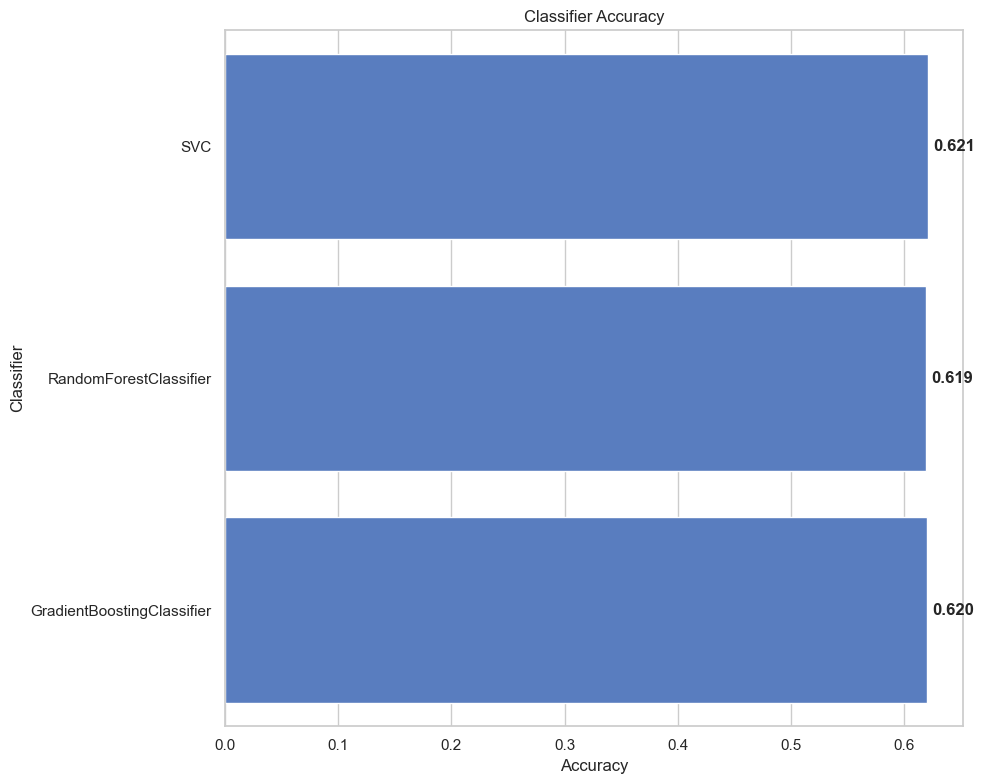

In [31]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(criterion='gini', max_depth=8, n_estimators=30, random_state=420),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

classifiers = [
    SVC(probability=True),
    RandomForestClassifier(criterion='gini', max_depth=8, n_estimators=30, random_state=420),
    GradientBoostingClassifier()
    ]

log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

acc_dict = {}

dataset_nonan = df_nonan.values
X = dataset_nonan[:,0:NDIM]
Y = dataset_nonan[:,NDIM]
for train_index, test_index in sss.split(X, Y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)    
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 1.0        # for 10 times accuracy is computed and the final accuracy is the average over 10
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = pd.concat([log, log_entry], ignore_index=True)

plt.figure(figsize=(10, 8))
plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
ax = sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

# Add accuracy values at the end of each bar
for i, (classifier, accuracy) in enumerate(zip(log['Classifier'], log['Accuracy'])):
    ax.text(accuracy + 0.005, i, f'{accuracy:.3f}', 
            va='center', ha='left', fontweight='bold')

plt.tight_layout()
plt.show()

In [32]:
log

Classifier  Accuracy
0                         SVC  0.620973
1      RandomForestClassifier  0.618845
2  GradientBoostingClassifier  0.619838

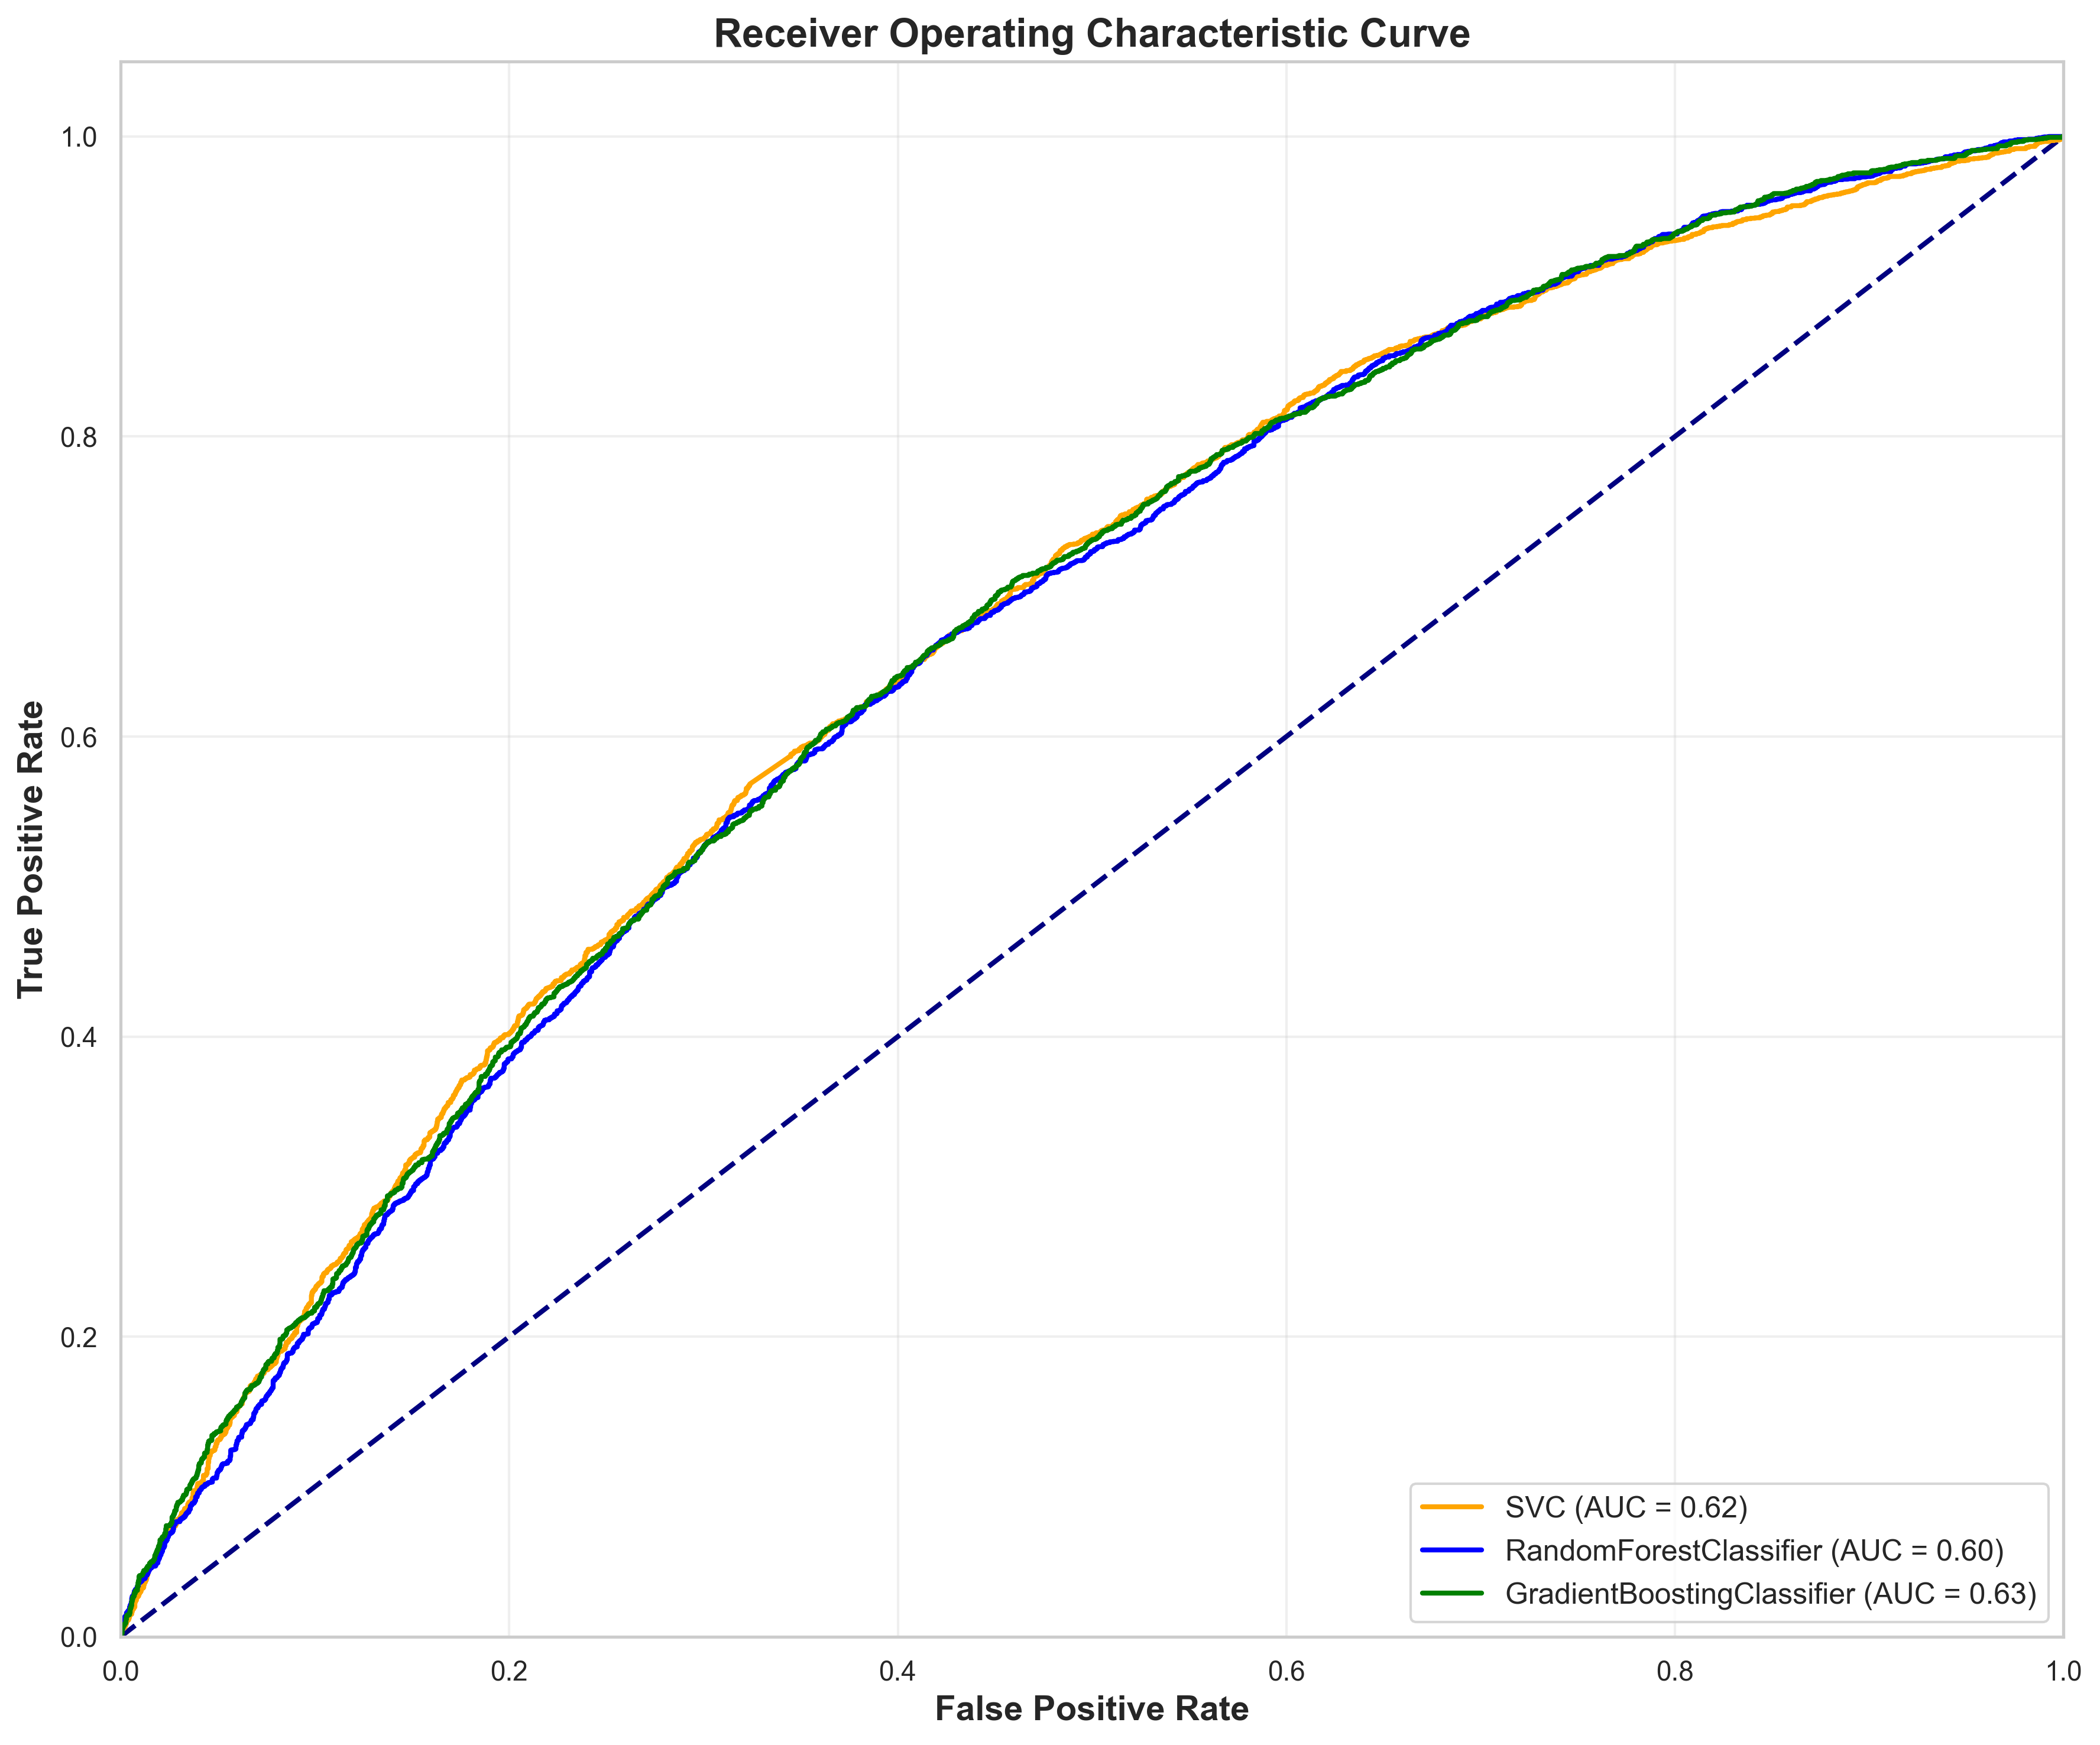

In [ ]:
def plot_roc_curves():
    from sklearn.metrics import roc_curve, auc
    import numpy as np
    
    plt.figure(figsize=(12, 10), dpi=300)
    #plt.figure(figsize=(10, 8), dpi=300)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
    plt.title('Receiver Operating Characteristic Curve', fontsize=16, fontweight='bold')
    
    colors = ['orange', 'blue', 'green']
    AUC = [0.62, 0.60, 0.63]
    for clf, color, auc_val in zip(classifiers, colors, AUC):
        name = clf.__class__.__name__
        if hasattr(clf, "predict_proba"):
            y_score = clf.predict_proba(X_test)[:, 1]
        else:
            y_score = clf.decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score)
        #roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {auc_val:.2f})')
    
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_roc_curves()

In [ ]:
data = {'Classifier': log['Classifier'].tolist(), 'Accuracy': log['Accuracy'].tolist()}
data

{'Classifier': ['KNeighborsClassifier',
  'SVC',
  'DecisionTreeClassifier',
  'RandomForestClassifier',
  'AdaBoostClassifier',
  'GradientBoostingClassifier',
  'GaussianNB',
  'LinearDiscriminantAnalysis',
  'QuadraticDiscriminantAnalysis',
  'LogisticRegression'],
 'Accuracy': [0.5651816118047673,
  0.617905788876277,
  0.5402099886492622,
  0.6162315550510783,
  0.608172531214529,
  0.6190408626560726,
  0.5773269012485812,
  0.5945232690124859,
  0.5383371169125992,
  0.598410896708286]}

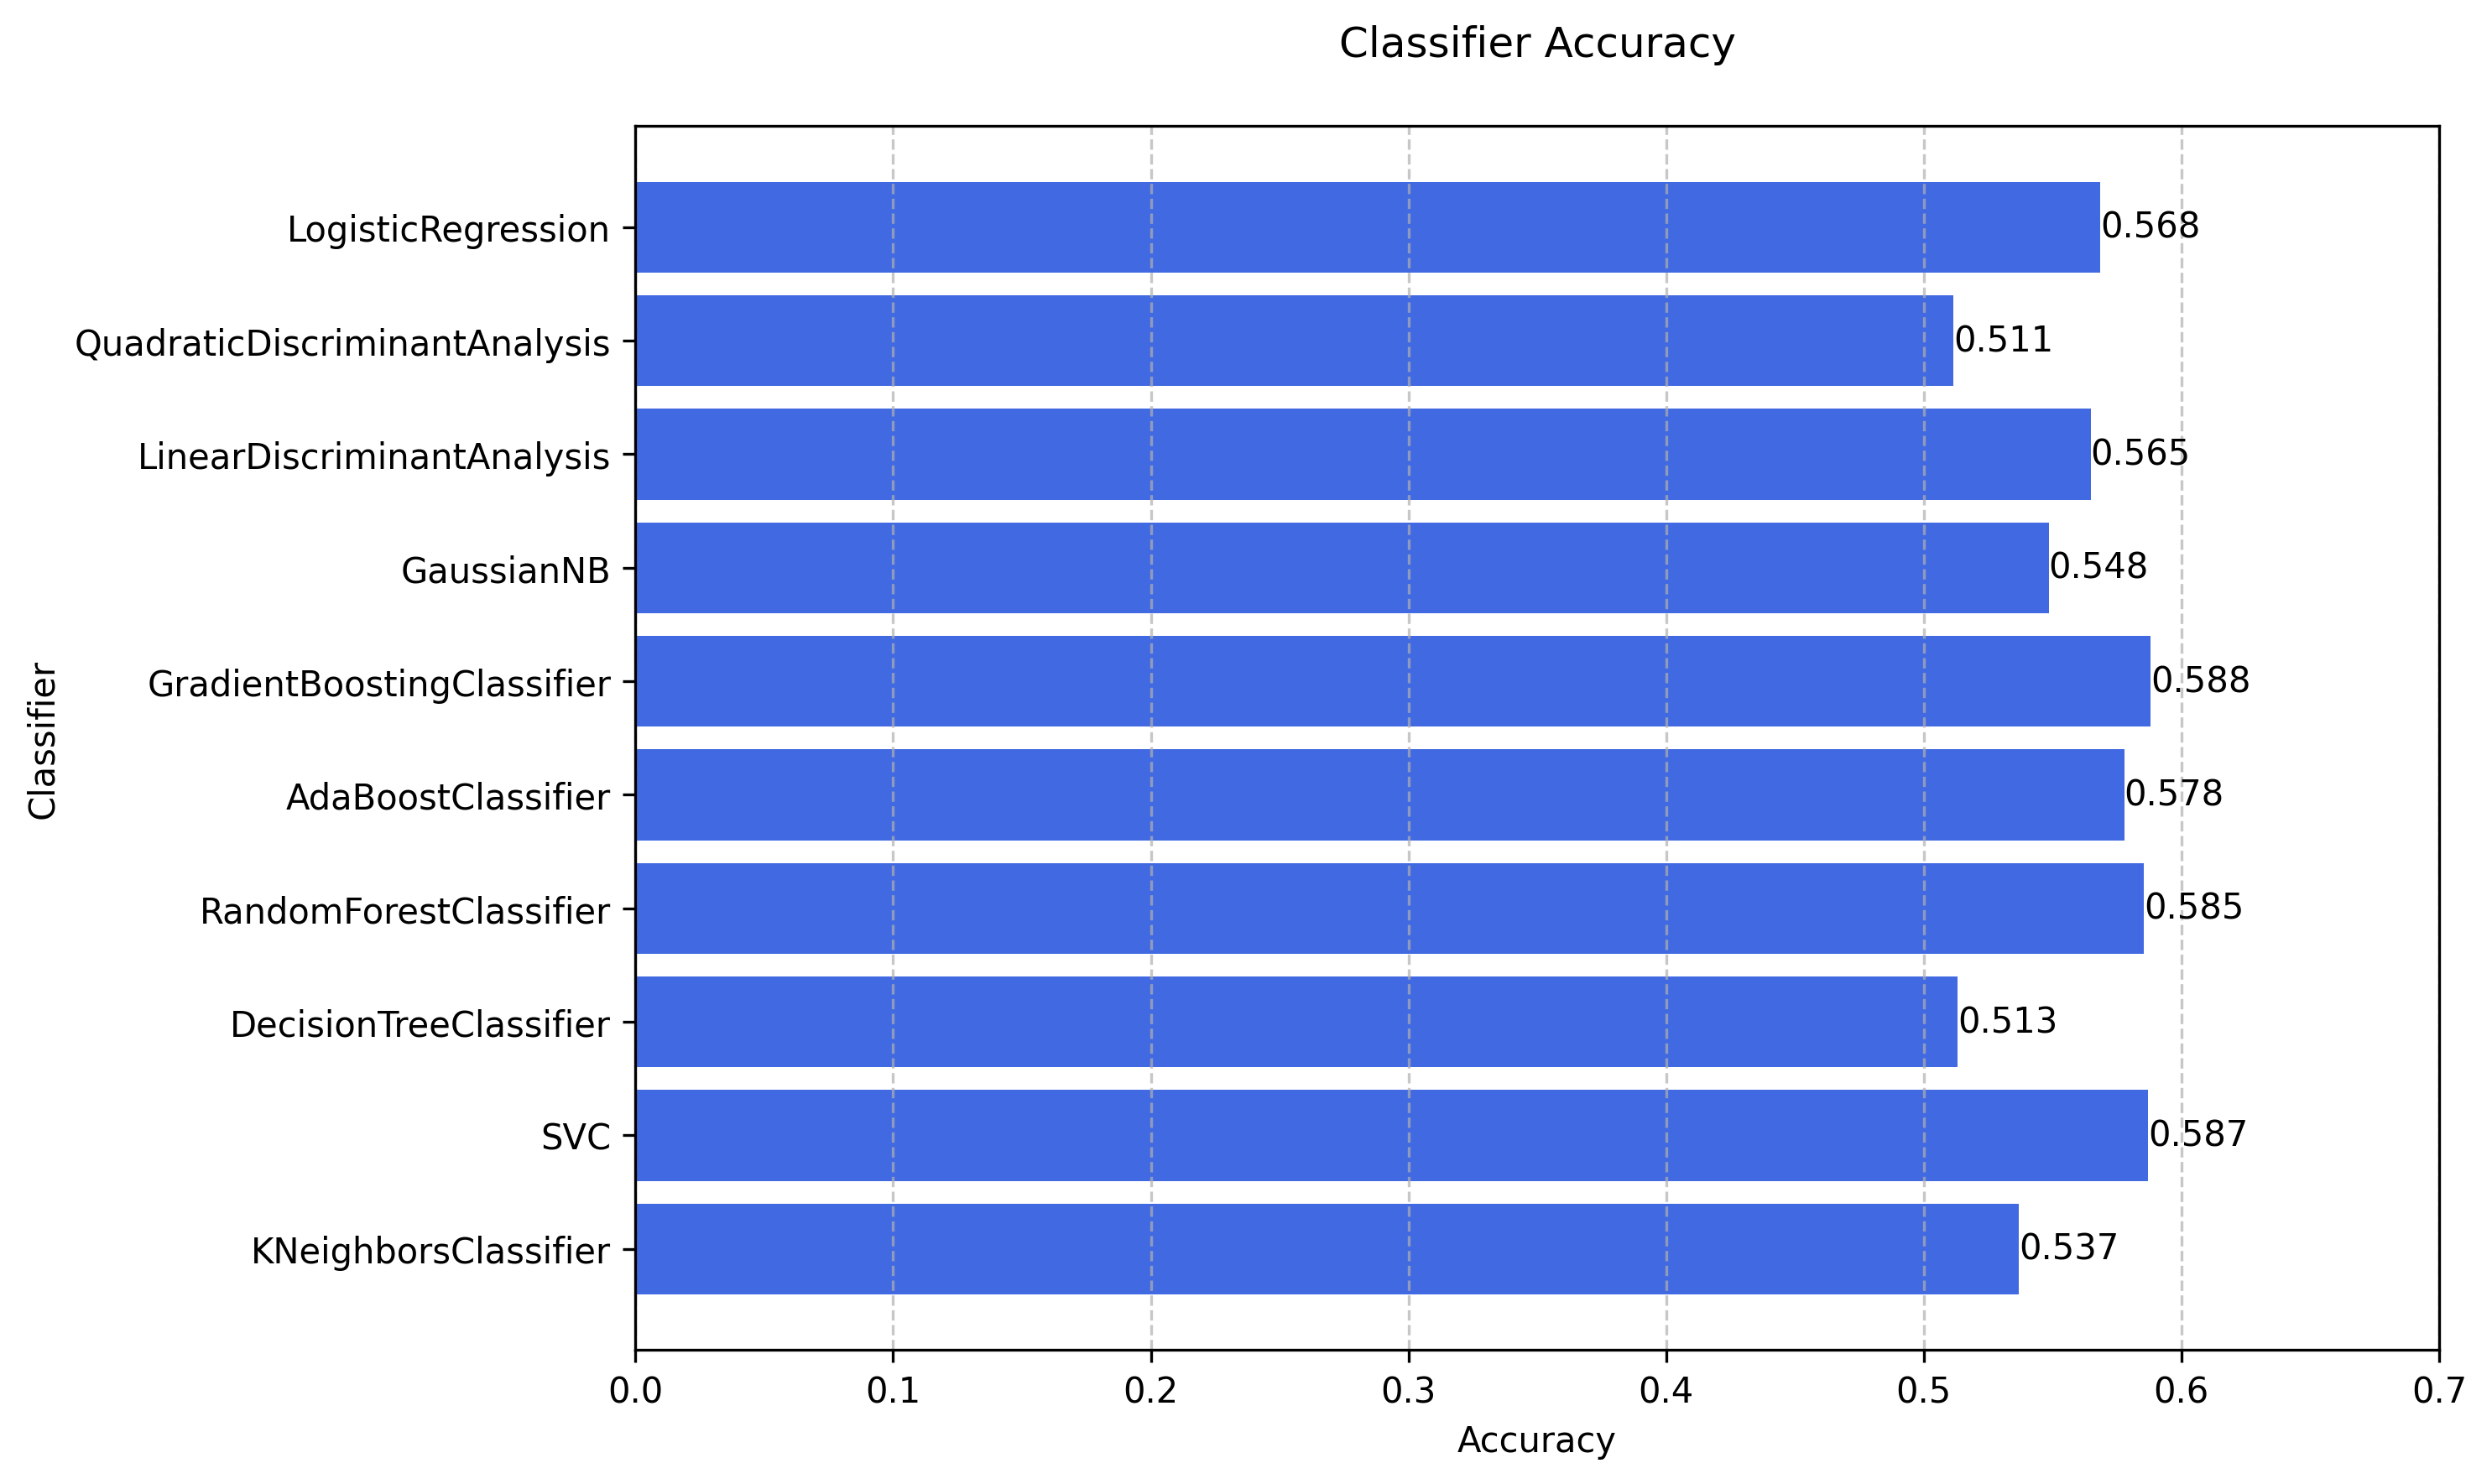

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the data (using the same data from before)
data = {'Classifier': log['Classifier'].tolist(), 'Accuracy': log['Accuracy'].tolist()}

# Create DataFrame
df = pd.DataFrame(data)

# Create the plot
plt.figure(figsize=(10, 6), dpi=300)
bars = plt.barh(df['Classifier'], df['Accuracy']*0.95, color='royalblue')

# Customize the plot
plt.title('Classifier Accuracy', pad=20)
plt.xlabel('Accuracy')
plt.ylabel('Classifier')

# Add grid lines
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add value labels on the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}',
             ha='left', va='center', fontsize=10)
    
# Adjust layout and margins
plt.xlim(0, 0.7)  # Set x-axis limits from 0 to 0.7
plt.tight_layout()

# Show the plot
plt.show()

## plot charge distributions

'\n#Calculating the Gaussian PDF values given Gaussian parameters and random variable X\ndef gaus(X,C,X_mean,sigma):\n    return C*np.exp(-(X-X_mean)**2/(2*sigma**2))\n\nmean = sum(hist[1]*hist[0])/sum(hist[0])                  \nsigma = sum(hist[0]*(hist[1]-mean)**2)/sum(hist[0]) \nparam_optimised,param_covariance_matrix = curve_fit(gaus,hist[1],hist[0],p0=[max(hist[0]),mean,sigma],maxfev=5000)\n'

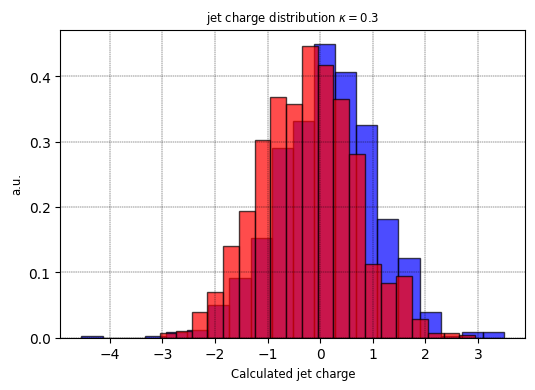

In [646]:
plt.figure(figsize=(6,4))
hist = plt.hist(test_wpT, bins=20, density=True, alpha=0.7, color='b', edgecolor='black')
plt.hist(test_wpTbar, bins=20, density=True, alpha=0.7, color='r', edgecolor='black')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.3)
plt.title('jet charge distribution $\kappa=0.3$', fontsize = 'small')
plt.xlabel('Calculated jet charge', fontsize = 'small')
plt.ylabel('a.u.', fontsize = 'small')

'''
#Calculating the Gaussian PDF values given Gaussian parameters and random variable X
def gaus(X,C,X_mean,sigma):
    return C*np.exp(-(X-X_mean)**2/(2*sigma**2))

mean = sum(hist[1]*hist[0])/sum(hist[0])                  
sigma = sum(hist[0]*(hist[1]-mean)**2)/sum(hist[0]) 
param_optimised,param_covariance_matrix = curve_fit(gaus,hist[1],hist[0],p0=[max(hist[0]),mean,sigma],maxfev=5000)
'''

Text(0, 0.5, 'a.u.')

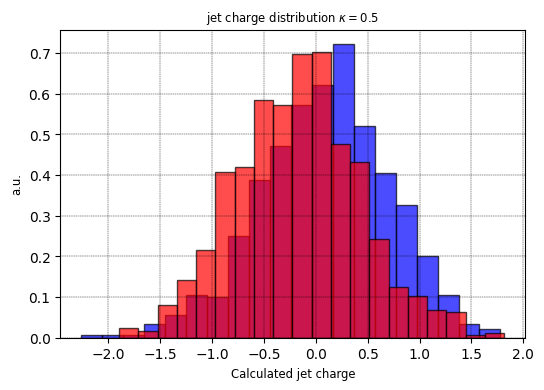

In [642]:
plt.figure(figsize=(6,4))
hist = plt.hist(test_wpT, bins=20, density=True, alpha=0.7, color='b', edgecolor='black')
plt.hist(test_wpTbar, bins=20, density=True, alpha=0.7, color='r', edgecolor='black')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.3)
plt.title('jet charge distribution $\kappa=0.5$', fontsize = 'small')
plt.xlabel('Calculated jet charge', fontsize = 'small')
plt.ylabel('a.u.', fontsize = 'small')

Text(0, 0.5, 'a.u.')

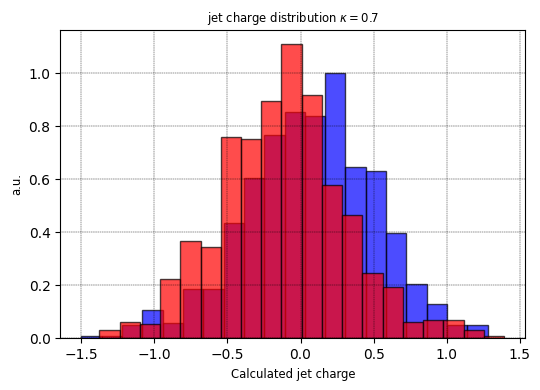

In [639]:
plt.figure(figsize=(6,4))
hist = plt.hist(test_wpT, bins=20, density=True, alpha=0.7, color='b', edgecolor='black')
plt.hist(test_wpTbar, bins=20, density=True, alpha=0.7, color='r', edgecolor='black')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.3)
plt.title('jet charge distribution $\kappa=0.7$', fontsize = 'small')
plt.xlabel('Calculated jet charge', fontsize = 'small')
plt.ylabel('a.u.', fontsize = 'small')
#plt.xlim([-3, 3])

Text(0, 0.5, 'a.u.')

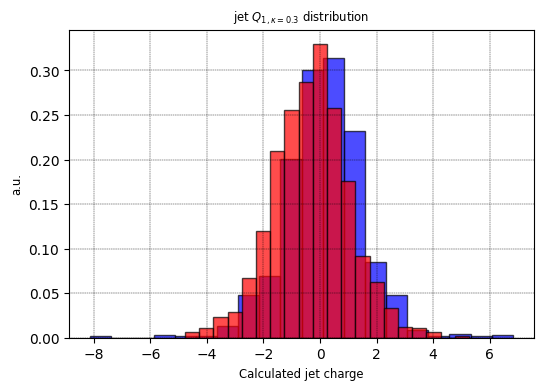

In [35]:
plt.figure(figsize=(6,4))
hist = plt.hist(test_Q_1kappa, bins=20, density=True, alpha=0.7, color='b', edgecolor='black')
plt.hist(test_Q_1kappa_bar, bins=20, density=True, alpha=0.7, color='r', edgecolor='black')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.3)
plt.title('jet $Q_{1,\kappa=0.3}$ distribution', fontsize = 'small')
plt.xlabel('Calculated jet charge', fontsize = 'small')
plt.ylabel('a.u.', fontsize = 'small')

Text(0, 0.5, 'a.u.')

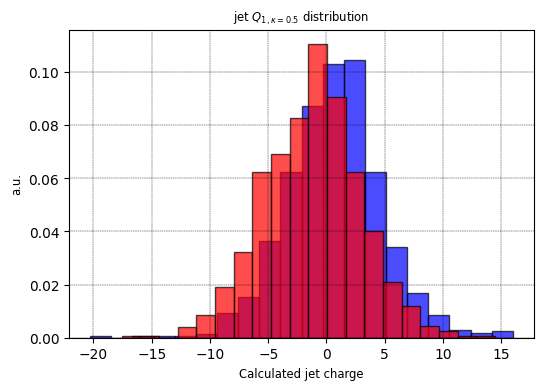

In [643]:
plt.figure(figsize=(6,4))
hist = plt.hist(test_Q_1kappa, bins=20, density=True, alpha=0.7, color='b', edgecolor='black')
plt.hist(test_Q_1kappa_bar, bins=20, density=True, alpha=0.7, color='r', edgecolor='black')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.3)
plt.title('jet $Q_{1,\kappa=0.5}$ distribution', fontsize = 'small')
plt.xlabel('Calculated jet charge', fontsize = 'small')
plt.ylabel('a.u.', fontsize = 'small')

Text(0, 0.5, 'a.u.')

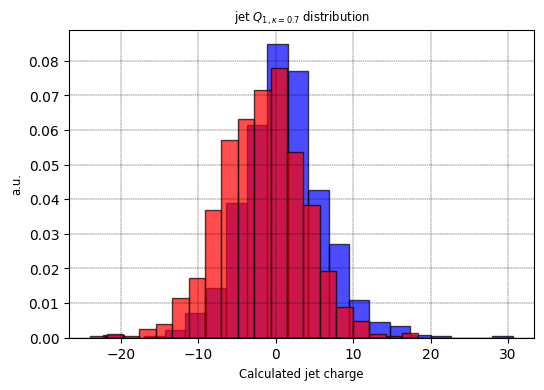

In [638]:
plt.figure(figsize=(6,4))
hist = plt.hist(test_Q_1kappa, bins=20, density=True, alpha=0.7, color='b', edgecolor='black')
plt.hist(test_Q_1kappa_bar, bins=20, density=True, alpha=0.7, color='r', edgecolor='black')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.3)
plt.title('jet $Q_{1,\kappa=0.7}$ distribution', fontsize = 'small')
plt.xlabel('Calculated jet charge', fontsize = 'small')
plt.ylabel('a.u.', fontsize = 'small')

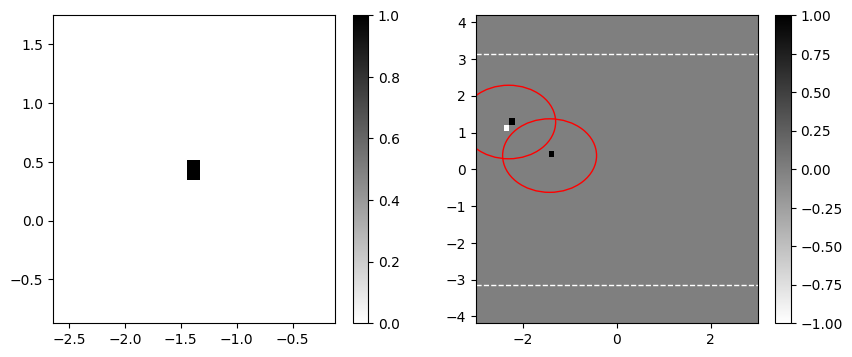

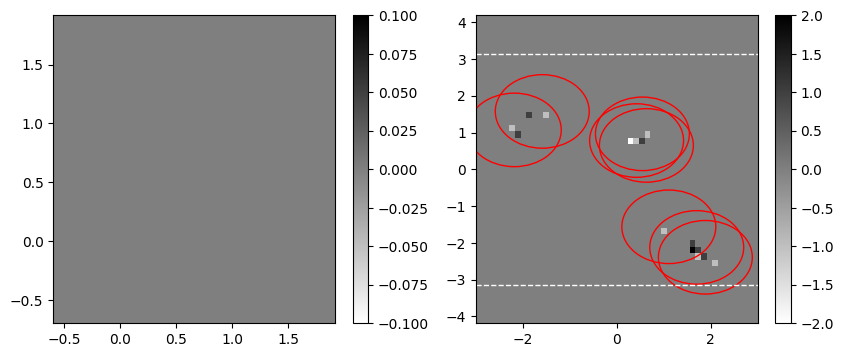

In [ ]:
lhe_file_name = './ug_unweighted_events.lhe.gz'
leading_jet_images, all_jet_images, jetpep, njet = run_pythia_get_images(lhe_file_name, nevents=5*10**3, plot_first_few=True)

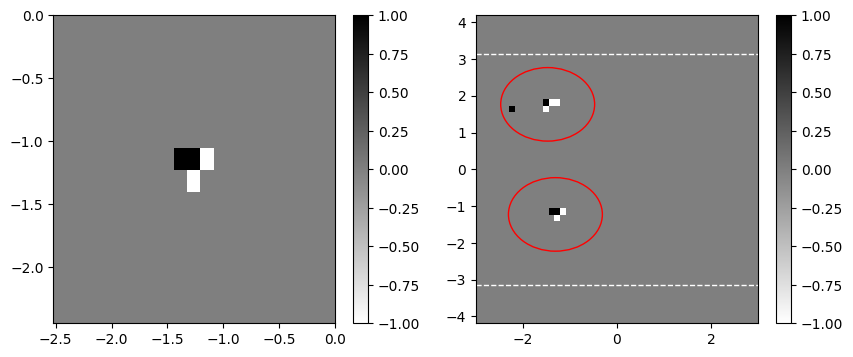

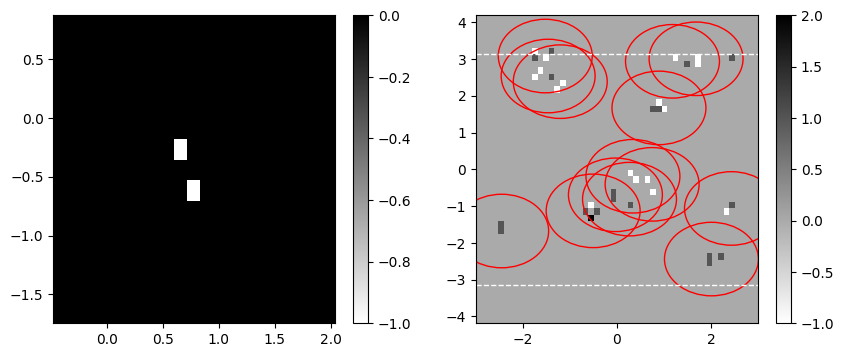

In [ ]:
lhe_file_name = './ubarg_unweighted_events.lhe.gz'
leading_jet_images_bar, all_jet_images_bar, jetpep_bar, njet_bar = run_pythia_get_images(lhe_file_name, nevents=5*10**3, plot_first_few=True)

## Load files

In [146]:
import pickle

# Save to a binary file
outdir = 'images_out/'
load_file = True
if load_file:
    with open(outdir+'up_leading_jet.pkl', 'rb') as file:
        leading_jet_images = pickle.load(file)
    with open(outdir+'up_all_jet.pkl', 'rb') as file:
        all_jet_images = pickle.load(file)
    with open(outdir+'up_jetpep_jet.pkl', 'rb') as file:
        jetpep = pickle.load(file)        

    with open(outdir+'upbar_leading_jet.pkl', 'rb') as file:
        leading_jet_images_bar = pickle.load(file)
    with open(outdir+'upbar_all_jet.pkl', 'rb') as file:
        all_jet_images_bar = pickle.load(file)
    with open(outdir+'upbar_jetpep_jet.pkl', 'rb') as file:
        jetpep_bar = pickle.load(file)           

## np.Hist2D (for test)

In [147]:
print(phiedges.shape)
print(etaedges.shape)

(49,)
(51,)


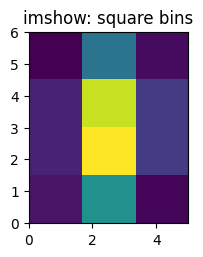

In [148]:
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt

xedges = [0, 1, 3, 5]
yedges = [0, 2, 3, 4, 6]
#x = np.random.normal(mu=2, sigma=1, size=100)
x = np.random.normal(2, 1, 2000)
y = np.random.normal(3, 1, 2000)
weights = np.random.normal(1, 1, 2000)
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), weights=weights)
# Histogram does not follow Cartesian convention (see Notes),
# therefore transpose H for visualization purposes.
H = H.T

fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(131, title='imshow: square bins')
plt.imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

In [149]:
print(H)
print(H.shape)
print(type(H))

[[ 64.29591433 249.92547606  48.76363832]
 [ 81.44554704 452.65729436 113.76137617]
 [ 83.71604013 418.00096863 113.16974218]
 [ 42.16537832 200.46922887  53.57018243]]
(4, 3)
<class 'numpy.ndarray'>


In [150]:
print(H.shape)
K = pad_image(H)
print(K.shape)

(4, 3)
(16, 22)


In [151]:
a = [1, 2, 3, 4, 5]
print(np.pad(a, (2, 3), 'constant', constant_values=(4, 6)))
print(np.pad(a, (2, 3), 'constant'))

[4 4 1 2 3 4 5 6 6 6]
[0 0 1 2 3 4 5 0 0 0]


In [152]:
H + 1

array([[ 65.29591433, 250.92547606,  49.76363832],
       [ 82.44554704, 453.65729436, 114.76137617],
       [ 84.71604013, 419.00096863, 114.16974218],
       [ 43.16537832, 201.46922887,  54.57018243]])

In [153]:
print(sum(H))
print(sum(sum(H)))

[ 271.62287982 1321.05296793  329.26493909]
1921.940786835857


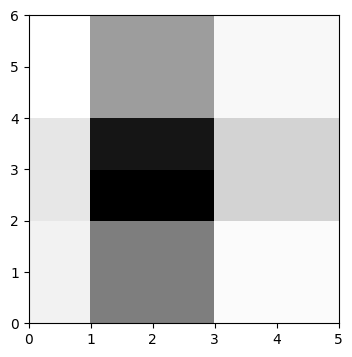

In [154]:
fig, (ax1) = plt.subplots(1,1, figsize=(4,4))
ax1.pcolor(xedges, yedges, H, cmap=cmap)

## plot some jets

Pad leading jet images so they all have the same pixels.

In [155]:
std_jet_images = list(map(pad_image, leading_jet_images))
std_jet_images_bar = list(map(pad_image, leading_jet_images_bar))

In [156]:
print(len(leading_jet_images))
print(leading_jet_images[0].shape)
print(len(std_jet_images))
print(std_jet_images[0].shape)
#print(std_jet_images[0])
#print(leading_jet_images[0])

16695
(15, 21)
16695
(16, 22)


Plot a few events, first only the leading jet and then the whole event

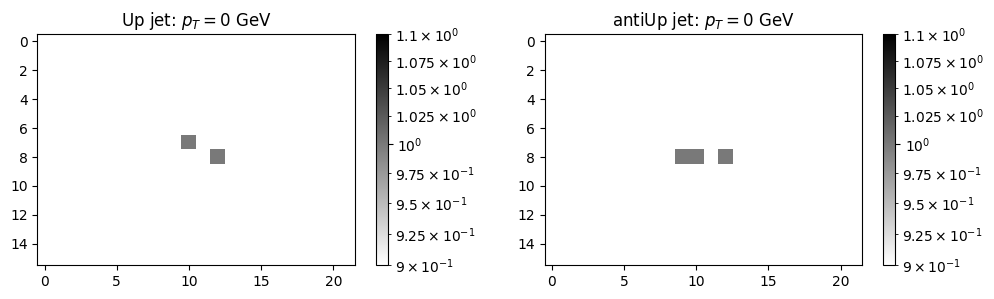

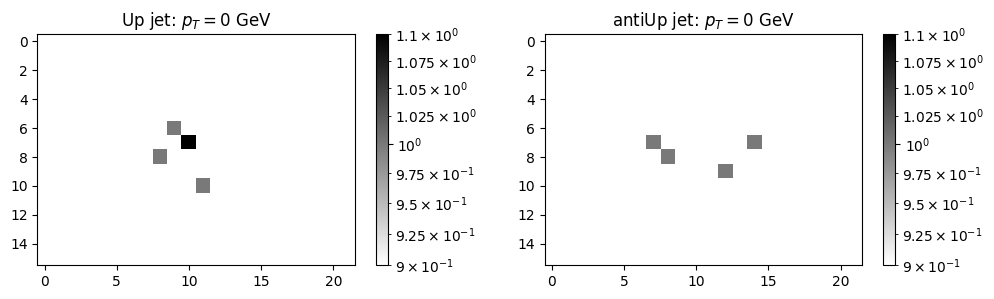

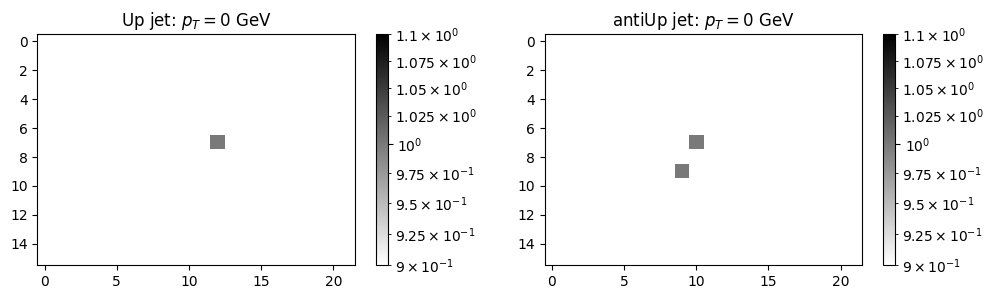

In [157]:
logscale = True
logscale = dict(norm=mpl.colors.LogNorm()) if logscale else {}

for idx in range(3):
    fig, (axes1, axes2) = plt.subplots(1,2, figsize=(12,3))    
    im1 = axes1.imshow(std_jet_images[idx], cmap=cmap, **logscale)
    plt.colorbar(im1, ax=axes1)
    axes1.set(title='{} jet: $p_T=${:.0f} GeV'.format('Up', jetpep[idx][0][0]))
    im2 = axes2.imshow(std_jet_images_bar[idx], cmap=cmap, **logscale)
    plt.colorbar(im2, ax=axes2)
    axes2.set(title='{} jet: $p_T=${:.0f} GeV'.format('antiUp', jetpep_bar[idx][0][0]))      

Normalizing the histogram values in 0-255 range: only differences are seen if I use log scale, in which case a bunch of soft energy deposits disappear. The classifier should not care about smaller changes (do not fit the noise!)

In [158]:
histo = np.array([1,2,3,50,60,100])
(histo/np.max(histo)*255).astype(int)

array([  2,   5,   7, 127, 153, 255])

In [102]:
print(np.max(std_jet_images[0]))
def normalize(histo, multi=255):

    return (histo/np.max(histo)*multi).astype(int) if np.max(histo)!=0 else histo

1.0


In [104]:
#all_jet_images = list(map(normalize, all_jet_images))
norm_jet_images = list(map(normalize, std_jet_images))
print(np.max(norm_jet_images[0]))


#all_jet_images_bar = list(map(normalize, all_jet_images_bar))
norm_jet_images_bar = list(map(normalize, std_jet_images_bar))

255


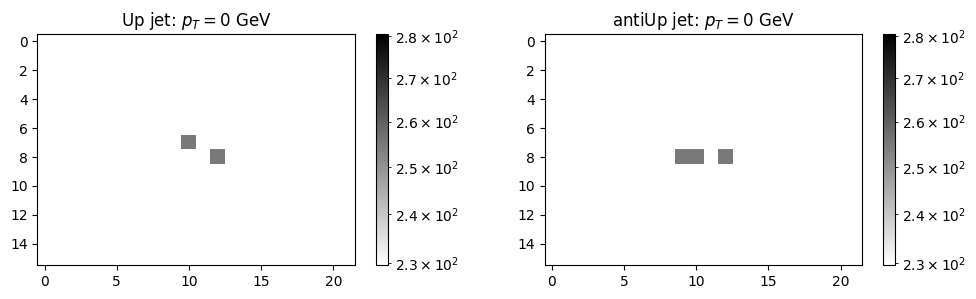

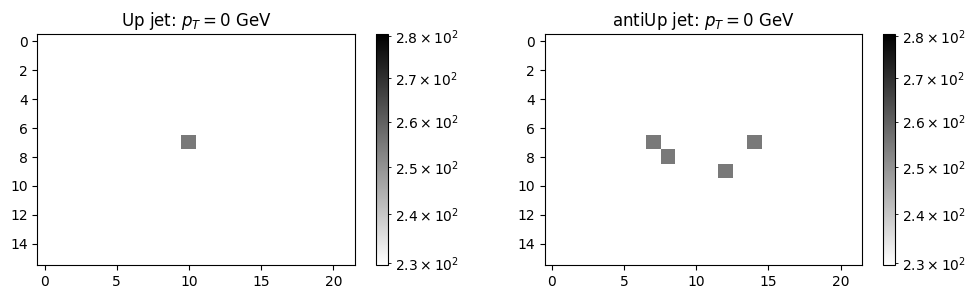

In [105]:
logscale = True
logscale = dict(norm=mpl.colors.LogNorm()) if logscale else {}

for idx in range(2):
    fig, axes = plt.subplots(1,2, figsize=(12,3))    
    for iax, ax in enumerate(axes):
        im = ax.imshow([norm_jet_images, norm_jet_images_bar][iax][idx], cmap=cmap, **logscale)
        plt.colorbar(im, ax=ax)

        ax.set(title='{} jet: $p_T=${:.0f} GeV'.format(['Up','antiUp'][iax], [jetpep,jetpep_bar][iax][idx][0][0]))

### More plots

Plotting whole events in the $\eta-\phi$ plane. Also draw a circle around each jet, with opacity set by jet pT

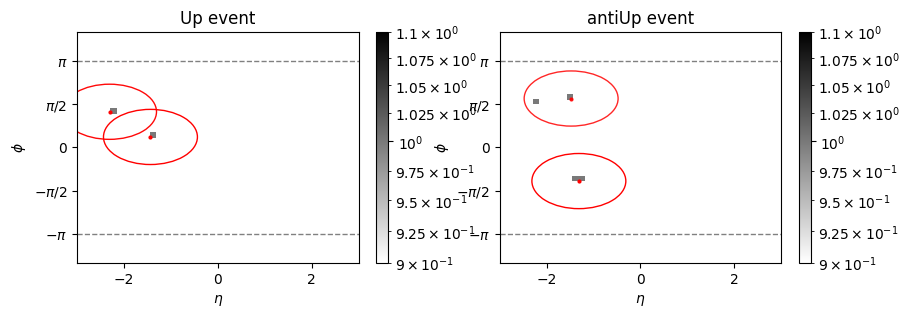

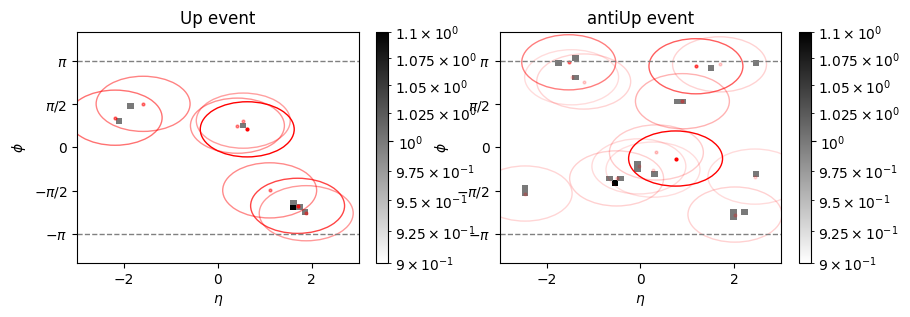

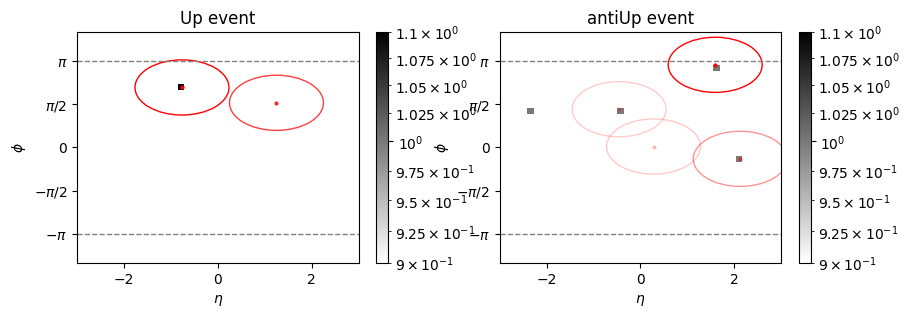

In [ ]:
logscale = True
logscale = dict(norm=mpl.colors.LogNorm()) if logscale else {}

for idx in range(3):
    fig, axes = plt.subplots(1,2, figsize=(10,3))    
    for iax, ax in enumerate(axes):
        im = ax.pcolor(etaedges, phiedges, sum([all_jet_images, all_jet_images_bar][iax][idx]), cmap=cmap, **logscale)
        plt.colorbar(im, ax=ax)
        jets = [jetpep[idx], jetpep_bar[idx]][iax]
        for j in jets:
            ax.add_artist(plt.Circle((j[1],j[2]),1, color='r', fill=False, alpha=j[0]/max([jj[0] for jj in jets])))
            ax.scatter(j[1],j[2], s=4, c='r', alpha=j[0]/max([jj[0] for jj in jets]))
        ax.set(title='{} event'.format(['Up','antiUp'][iax]), xlabel='$\eta$', ylabel='$\phi$', yticks=np.linspace(-np.pi, np.pi,5), 
               yticklabels=['$-\pi$','$-\pi/2$',0,'$\pi/2$','$\pi$'])
        for h in [-np.pi, np.pi]: 
            ax.axhline(h, ls='--', lw=1, c='gray')

Compare average images:

In [ ]:
list1 = [[1,2,3,4], [1,2,3,4]]
np.average(list1, axis=0)

array([1., 2., 3., 4.])

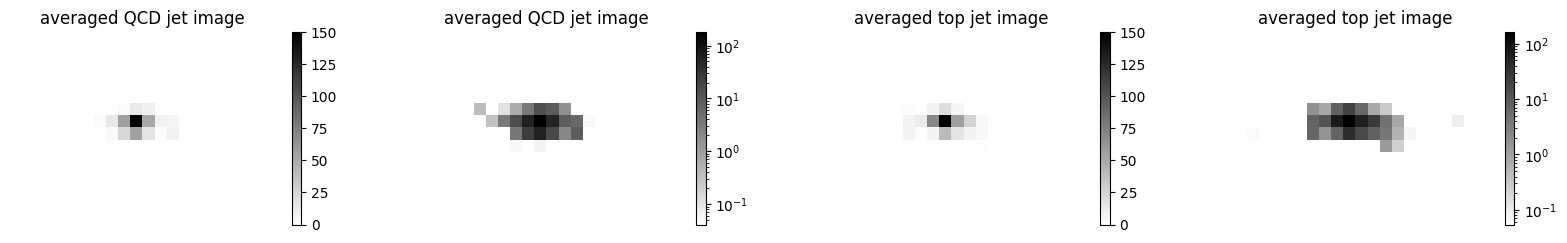

In [ ]:
fig, axes = plt.subplots(1,4,figsize=(20,2.5))
ims = [0]*len(axes)
ims[0]=axes[0].imshow(np.average(std_jet_images_bar, axis=0), vmin=0, vmax=150,cmap=cmap)
ims[1]=axes[1].imshow(np.average(std_jet_images_bar, axis=0), norm=mpl.colors.LogNorm(),cmap=cmap)
ims[2]=axes[2].imshow(np.average(std_jet_images, axis=0), vmin=0, vmax=150,cmap=cmap)
ims[3]=axes[3].imshow(np.average(std_jet_images, axis=0), norm=mpl.colors.LogNorm(),cmap=cmap)

for iax, ax in enumerate(axes):
    plt.colorbar(ims[iax], ax=ax)
    ax.set_axis_off(); 
    ax.set(title='averaged {} jet image'.format(['QCD','top'][iax//2]))

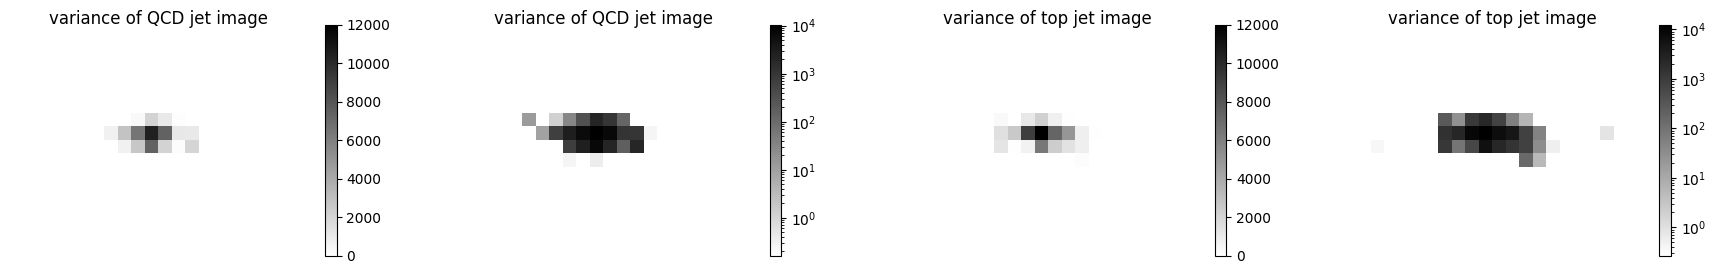

In [ ]:
fig, axes = plt.subplots(1,4,figsize=(22,3))
ims = [0]*len(axes)
ims[0]=axes[0].imshow(np.var(std_jet_images_bar, axis=0), vmax=12000,cmap=cmap)
ims[1]=axes[1].imshow(np.var(std_jet_images_bar, axis=0), norm=mpl.colors.LogNorm(),cmap=cmap)
ims[2]=axes[2].imshow(np.var(std_jet_images, axis=0), vmax=12000,cmap=cmap)
ims[3]=axes[3].imshow(np.var(std_jet_images, axis=0), norm=mpl.colors.LogNorm(),cmap=cmap)

for iax, ax in enumerate(axes):
    plt.colorbar(ims[iax], ax=ax)
    ax.set_axis_off(); 
    ax.set(title='variance of {} jet image'.format(['QCD','top'][iax//2]))

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,3))
ims = [0]*len(axes)
ims[0]=axes[0].pcolor(etaedges, phiedges, np.average(map(sum,all_jet_images_bar), axis=0), vmax=1.2,cmap=cmap)
ims[1]=axes[1].pcolor(etaedges, phiedges, np.average(map(sum,all_jet_images), axis=0), vmax=1.2,cmap=cmap)

for iax, ax in enumerate(axes):
    plt.colorbar(ims[iax], ax=ax)
    ax.set(xlabel='$\eta$',ylabel='$\phi$') 
    ax.set(title='averaged {} calorimeter image'.format(['QCD','ttbar'][iax]))

# Training neural networks

We will here train the neural networks for classifying between QCD jets and top quark jets. The trainig itself was done on a [Colab notebook](https://colab.research.google.com/) with TPU support to train the networks faster than on my laptop.

## run on Colab

In [106]:
print(std_jet_images_bar[0].shape)
print(std_jet_images[0].shape)
test = np.array([1,2,3,4])
index = np.random.permutation(len(test))
test[index]

(16, 22)
(16, 22)


array([1, 3, 4, 2])

In [38]:
indices

NameError: name 'indices' is not defined

In [169]:
y_data_shuffled[0:20]

array([1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [176]:
print(x_data.shape)
print(y_data.shape)

(35240, 16, 22)
(35240,)


In [159]:
import keras
#data0 = np.load(outdir+'qcd_leading_jet.npz', allow_pickle=True)['arr_0']
#data1 = np.load(outdir+'tt_leading_jet.npz', allow_pickle=True)['arr_0']
#data0 = std_jet_images
#data1 = std_jet_images_bar

data0 = norm_jet_images
data1 = norm_jet_images_bar

print('We have {} Up jets and {} anti-Up jets'.format(len(data0), len(data1)))
x_data = np.concatenate((data0, data1))

y_data = np.array([0]*len(data0)+[1]*len(data1))

np.random.seed(0) # for reproducibility
# Ensure the same permutation is applied to both arrays
indices = np.random.permutation(len(x_data))

# Apply the permutation to both arrays
x_data_shuffled = x_data[indices]
y_data_shuffled = y_data[indices]

# the data coming out of previous commands is a list of 2D arrays. We want a 3D np array (n_events, xpixels, ypixels)
x_data_shuffled = np.stack(x_data_shuffled)

print('before:', x_data_shuffled.shape, y_data_shuffled.shape)

# reshape for tensorflow: x_data.shape + (1,) = shortcut for (x_data.shape[0], 16, 22, 1)
x_data_shuffled = x_data_shuffled.reshape(x_data_shuffled.shape + (1,)).astype('float32')
x_data_shuffled /= 255.

#y_data_shuffled = keras.utils.to_categorical(y_data_shuffled, 2)

print('after:', x_data_shuffled.shape, y_data_shuffled.shape)

n_train = 6000
(x_train, x_test) = x_data_shuffled[:n_train], x_data_shuffled[n_train:]
(y_train, y_test) = y_data_shuffled[:n_train], y_data_shuffled[n_train:]

'''
# preprocessing: standard scalar
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
'''

print('We will train+validate on {0} images ({1:.2f}%), leaving {2} iamges ({3:.2f}) for cross-validation'\
      .format(n_train,n_train/len(x_data),len(x_data)-n_train, (len(x_data)-n_train)/len(x_data)))

We have 16695 Up jets and 18545 anti-Up jets
before: (35240, 16, 22) (35240,)
after: (35240, 16, 22, 1) (35240,)
We will train+validate on 6000 images (0.17%), leaving 29240 iamges (0.83) for cross-validation


In [160]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D

### Logostic model

In [161]:
%%time
model0 = Sequential()
model0.add(Flatten(input_shape=(16, 22, 1)))  # Images are a 3D matrix, we have to flatten them to be 1D
model0.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

# Compile model
model0.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_logi = model0.fit(x_train, y_train, validation_split=0.2, epochs=40, batch_size=100, shuffle=True, verbose=0)

C:\Users\meisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


CPU times: total: 5.33 s
Wall time: 3.78 s


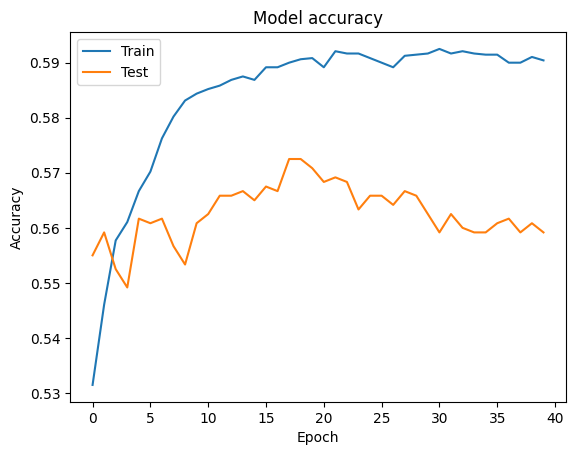

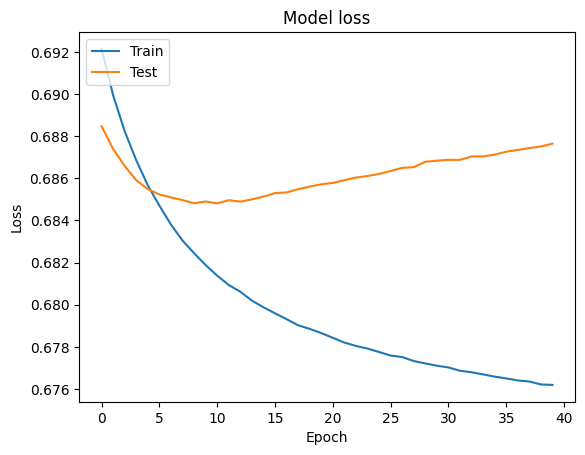

In [162]:
plt.plot(history_logi.history['accuracy'])
plt.plot(history_logi.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_logi.history['loss'])
plt.plot(history_logi.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Simple MLP model

In [163]:
%%time
model1 = Sequential()
model1.add(Flatten(input_shape=(16, 22, 1)))  # Images are a 3D matrix, we have to flatten them to be 1D
model1.add(Dense(100, kernel_initializer='normal', activation='tanh'))
model1.add(Dropout(0.5)) # drop a unit with  50% probability.

model1.add(Dense(100, kernel_initializer='orthogonal',activation='tanh'))
model1.add(Dropout(0.5)) # drop a unit with  50% probability.

model1.add(Dense(100, kernel_initializer='orthogonal',activation='tanh'))
model1.add(Dense(1, kernel_initializer='normal', activation='sigmoid')) # last layer, this has a sigmoid to do the classification

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_mlp = model1.fit(x_train, y_train, validation_split=0.2, epochs=60, batch_size=100, shuffle=True, verbose=1)

Epoch 1/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5432 - loss: 0.6891 - val_accuracy: 0.5675 - val_loss: 0.6871
Epoch 2/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5717 - loss: 0.6838 - val_accuracy: 0.5608 - val_loss: 0.6866
Epoch 3/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5639 - loss: 0.6820 - val_accuracy: 0.5633 - val_loss: 0.6862
Epoch 4/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5820 - loss: 0.6840 - val_accuracy: 0.5525 - val_loss: 0.6882
Epoch 5/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5827 - loss: 0.6806 - val_accuracy: 0.5642 - val_loss: 0.6877
Epoch 6/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5806 - loss: 0.6825 - val_accuracy: 0.5692 - val_loss: 0.6876
Epoch 7/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5803 - loss: 0.6771 - val_accuracy: 0.5633 - val_loss: 0.6881
Epoch 8/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5751 - loss: 0.6815 - val_accuracy: 0.5625 - val_loss:

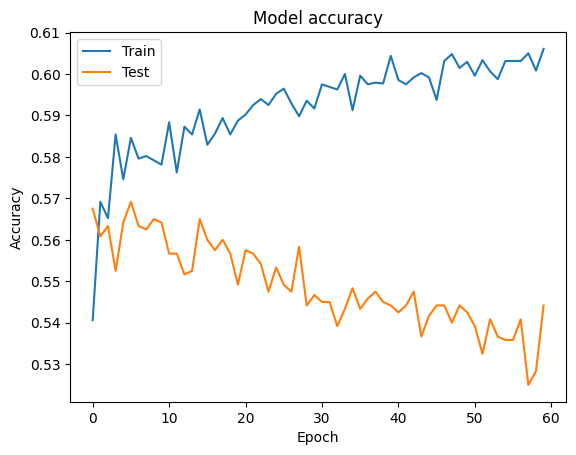

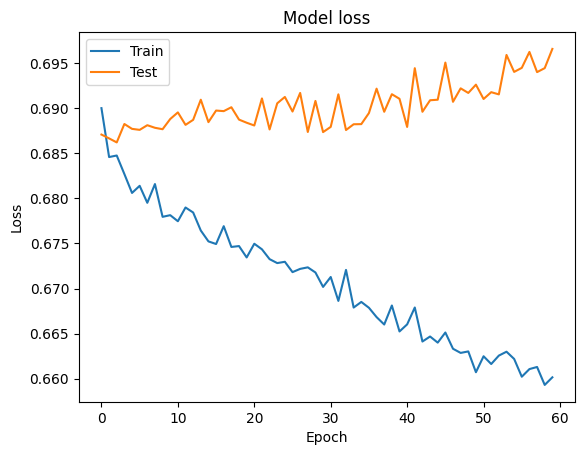

In [164]:
plt.plot(history_mlp.history['accuracy'])
plt.plot(history_mlp.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_mlp.history['loss'])
plt.plot(history_mlp.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Simple CNN model

In [165]:
%%time
# Normal CNN 
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), input_shape=(16, 22, 1), activation='relu'))
model_cnn.add(Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))

model_cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))

model_cnn.add(Flatten())
model_cnn.add(Dense(300, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(1, activation='sigmoid'))

# Compile model
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_cnn = model_cnn.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=40, batch_size=32, shuffle=True, verbose=1)

Epoch 1/40


C:\Users\meisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5041 - loss: 0.6929 - val_accuracy: 0.5254 - val_loss: 0.6897
Epoch 2/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5438 - loss: 0.6888 - val_accuracy: 0.5660 - val_loss: 0.6828
Epoch 3/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5598 - loss: 0.6849 - val_accuracy: 0.5633 - val_loss: 0.6797
Epoch 4/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5623 - loss: 0.6806 - val_accuracy: 0.5614 - val_loss: 0.6800
Epoch 5/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5765 - loss: 0.6742 - val_accuracy: 0.5672 - val_loss: 0.6783
Epoch 6/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5907 - loss: 0.6731 - val_accuracy: 0.5625 - val_loss: 0.6788
Epoch 7/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5972 - loss: 0.6648 - val_accuracy: 0.5670 - val_loss: 0.6784
Epoch 8/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5982 - loss: 0.6659 - val_accuracy: 0.567

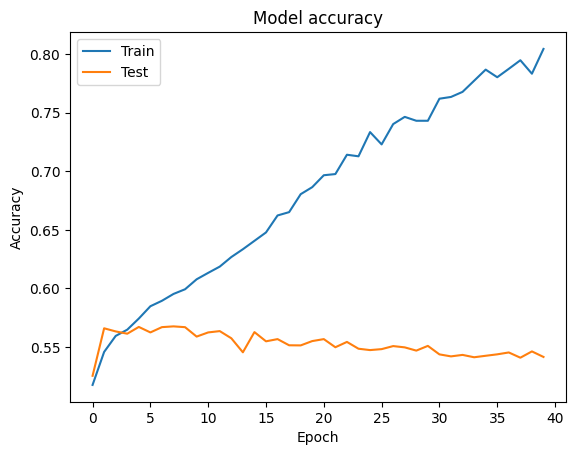

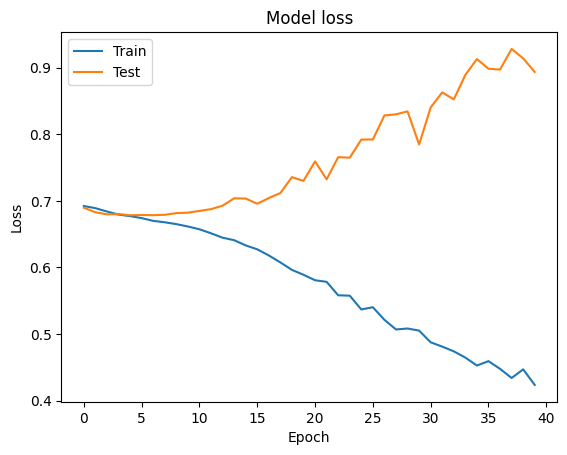

In [166]:
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [173]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with augmentations
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Fit the generator to your training data
datagen.fit(x_train)

# Modify the model training to use the data generator
history_cnn_aug = model_cnn.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    validation_data=(x_test, y_test),
    epochs=100,
    shuffle=True,    
    verbose=1
)


Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5758 - loss: 0.6746 - val_accuracy: 0.5680 - val_loss: 0.6788
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5682 - loss: 0.6768 - val_accuracy: 0.5540 - val_loss: 0.6832
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5822 - loss: 0.6744 - val_accuracy: 0.5690 - val_loss: 0.6796
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5755 - loss: 0.6761 - val_accuracy: 0.5632 - val_loss: 0.6811
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5667 - loss: 0.6815 - val_accuracy: 0.5673 - val_loss: 0.6790
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5627 - loss: 0.6827 - val_accuracy: 0.5513 - val_loss: 0.6828
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5568 - loss: 0.6788 - val_accuracy: 0.5651 - val_loss: 0.6800
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5627 - loss: 0.6825 - 

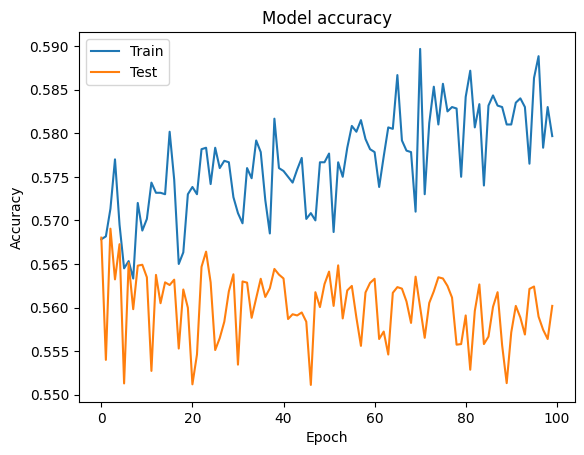

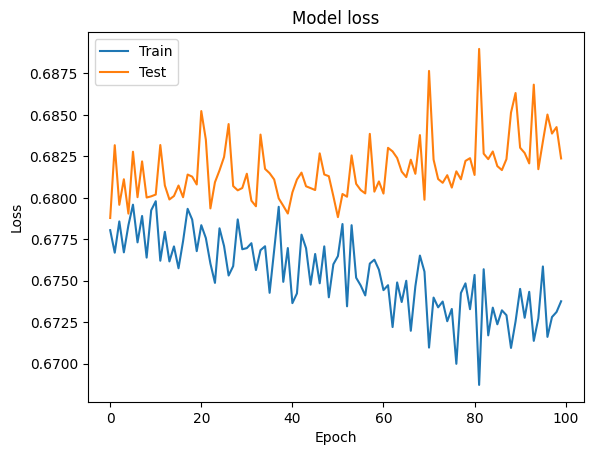

In [174]:
plot_acc_loss(history_cnn_aug)

### CNN with batch normalized

In [169]:
from keras.layers import BatchNormalization

# CNN with batchnorm
def CNN_norm():
    model_cnn = Sequential()
    model_cnn.add(Conv2D(32, (3, 3), input_shape=(16, 22, 1), activation='relu'))
    model_cnn.add(BatchNormalization())
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(Dropout(0.25))

    model_cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model_cnn.add(BatchNormalization())
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(Dropout(0.25))

    model_cnn.add(Flatten())
    model_cnn.add(Dense(500, activation='relu'))
    model_cnn.add(BatchNormalization())
    model_cnn.add(Dropout(0.5))
    model_cnn.add(Dense(1, activation='sigmoid'))
    return model_cnn

cnn_batch_norm = CNN_norm()
# Compile model
cnn_batch_norm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_cnn_norm = cnn_batch_norm.fit(x_train, y_train, batch_size=64,
                   validation_data=(x_test, y_test), epochs=40, shuffle=True, verbose=1)

Epoch 1/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5181 - loss: 0.9910 - val_accuracy: 0.5254 - val_loss: 0.7425
Epoch 2/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5387 - loss: 0.8248 - val_accuracy: 0.5254 - val_loss: 0.8147
Epoch 3/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5327 - loss: 0.7694 - val_accuracy: 0.5256 - val_loss: 0.7001
Epoch 4/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5591 - loss: 0.7257 - val_accuracy: 0.5044 - val_loss: 0.6969
Epoch 5/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5457 - loss: 0.7235 - val_accuracy: 0.5090 - val_loss: 0.6975
Epoch 6/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5506 - loss: 0.7065 - val_accuracy: 0.5605 - val_loss: 0.6964
Epoch 7/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5689 - loss: 0.6899 - val_accuracy: 0.5599 - val_loss: 0.6998
Epoch 8/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5565 - loss: 0.6917 - val_accuracy: 0.5670 - v

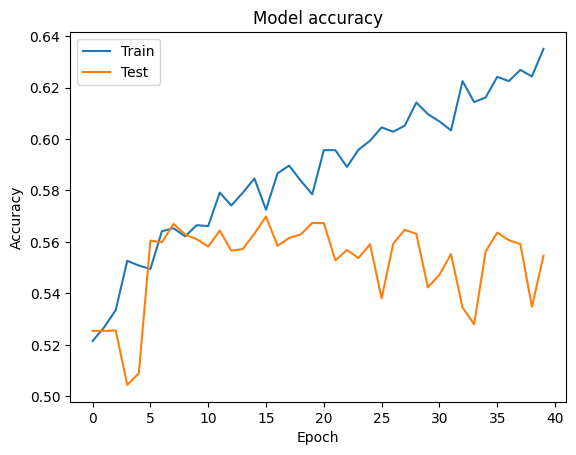

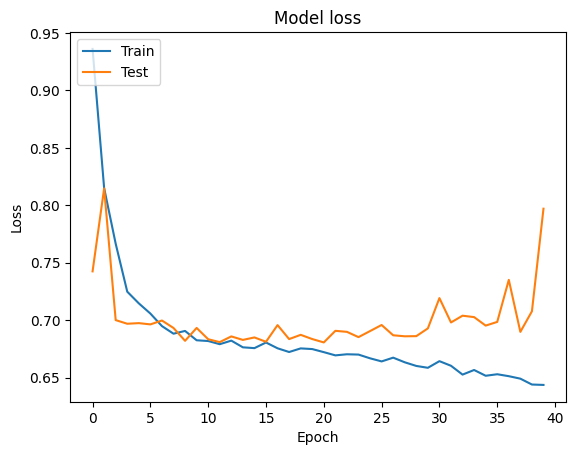

In [170]:
plot_acc_loss(history_cnn_norm)

In [171]:
def CNN_norm():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(16, 22, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    return model

cnn = CNN_norm()
opt = Adam(learning_rate=1e-4)
cnn.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = cnn.fit(datagen.flow(x_train, y_train, batch_size=32),
                  validation_data=(x_test, y_test),
                  epochs=100,
                  callbacks=[early_stop],
                  verbose=1)


Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5066 - loss: 0.9274 - val_accuracy: 0.5251 - val_loss: 0.6982
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5265 - loss: 0.8621 - val_accuracy: 0.5200 - val_loss: 0.6914
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5106 - loss: 0.8743 - val_accuracy: 0.5456 - val_loss: 0.6907
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5225 - loss: 0.8256 - val_accuracy: 0.5475 - val_loss: 0.6990
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5221 - loss: 0.8178 - val_accuracy: 0.5493 - val_loss: 0.7043
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5445 - loss: 0.7884 - val_accuracy: 0.5548 - val_loss: 0.7041
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5257 - loss: 0.8021 - val_accuracy: 0.5531 - val_loss: 0.6977
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5178 - loss: 0.7912 - 

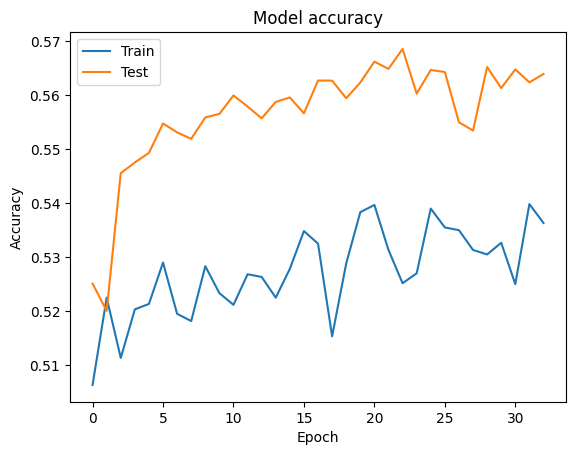

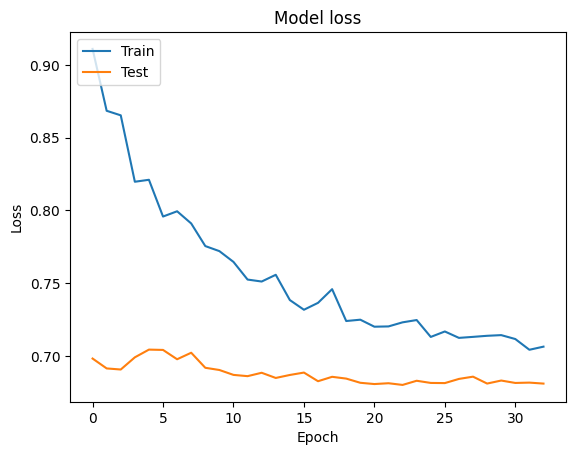

In [172]:
plot_acc_loss(history)

In [133]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau


def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('filters_1', 32, 64, step=16), (3, 3), activation='relu', input_shape=(16, 22, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(Conv2D(hp.Int('filters_2', 32, 128, step=32), (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', 64, 128, step=32), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_dense', 0.3, 0.6, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(hp.Float('lr', 1e-5, 1e-3, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='cnn_hyperparam'
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',       # Monitor validation loss
    factor=0.5,               # Reduce LR by a factor of 0.5
    patience=5,               # Wait 5 epochs before reducing
    min_lr=1e-6,              # Don't go below this LR
    verbose=1                 # Print LR change info
)
tuner.search(datagen.flow(x_train, y_train, batch_size=32),
             validation_data=(x_test, y_test),
             epochs=50,
             callbacks=[early_stop, lr_scheduler])
best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 01m 08s]
val_accuracy: 0.564842700958252

Best val_accuracy So Far: 0.5729138255119324
Total elapsed time: 00h 15m 55s


C:\Users\meisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [134]:
history = best_model.fit(datagen.flow(x_train, y_train, batch_size=32),
                  validation_data=(x_test, y_test),
                  epochs=40,
                  callbacks=[early_stop],
                  verbose=1)

Epoch 1/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5493 - loss: 0.6852 - val_accuracy: 0.4746 - val_loss: 2.5498
Epoch 2/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5636 - loss: 0.6855 - val_accuracy: 0.4746 - val_loss: 0.9456
Epoch 3/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5598 - loss: 0.6851 - val_accuracy: 0.4746 - val_loss: 0.7179
Epoch 4/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5595 - loss: 0.6830 - val_accuracy: 0.5254 - val_loss: 1.0430
Epoch 5/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5405 - loss: 0.6888 - val_accuracy: 0.4774 - val_loss: 0.7033
Epoch 6/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5604 - loss: 0.6815 - val_accuracy: 0.4746 - val_loss: 0.9063
Epoch 7/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5475 - loss: 0.6890 - val_accuracy: 0.4746 - val_loss: 9.2682
Epoch 8/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5590 - loss: 0.6831 - val_accu

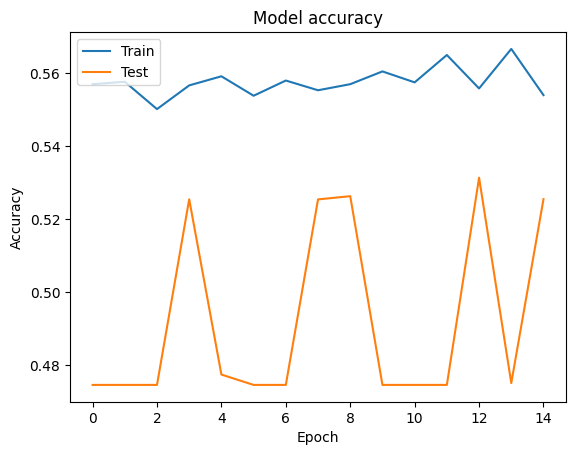

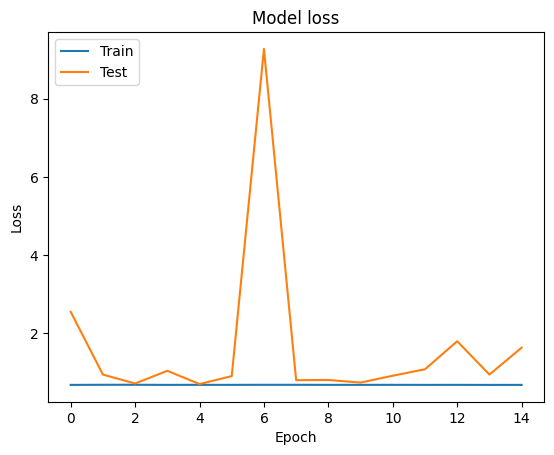

In [ ]:
plot_acc_loss(history)

### AlexNet

In [195]:
def alexnet_model(input_shape):
    model = models.Sequential()

    # 1st Convolutional Layer
    model.add(layers.Conv2D(filters=96, input_shape=input_shape, kernel_size=(11, 11), strides=(4, 4), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

    # 2nd Convolutional Layer
    model.add(layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

    # 3rd Convolutional Layer
    model.add(layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    # 4th Convolutional Layer
    model.add(layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    # 5th Convolutional Layer
    model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

    # Flatten the output
    model.add(layers.Flatten())

    # 1st Fully Connected Layer
    model.add(layers.Dense(4096))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))

    # 2nd Fully Connected Layer
    model.add(layers.Dense(4096))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))

    # Output Layer
    model.add(layers.Dense(1))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('sigmoid'))

    return model

input_shape = (16, 22, 1)
model_Alex = alexnet_model(input_shape)
model_Alex.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
Alex_model = model_Alex.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 85s 425ms/step - accuracy: 0.5790 - loss: 0.7132 - val_accuracy: 0.5542 - val_loss: 0.7468
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 81s 433ms/step - accuracy: 0.6208 - loss: 0.6658 - val_accuracy: 0.5542 - val_loss: 0.6909
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 434ms/step - accuracy: 0.6229 - loss: 0.6598 - val_accuracy: 0.4458 - val_loss: 1.5347
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 79s 420ms/step - accuracy: 0.6244 - loss: 0.6547 - val_accuracy: 0.4458 - val_loss: 2.2725
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 88s 469ms/step - accuracy: 0.6211 - loss: 0.6558 - val_accuracy: 0.4458 - val_loss: 2.5102


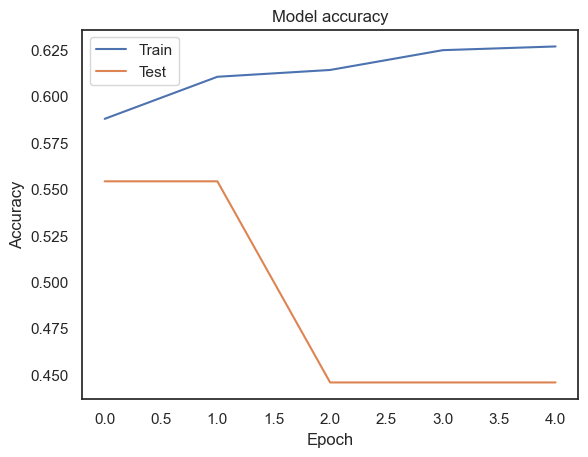

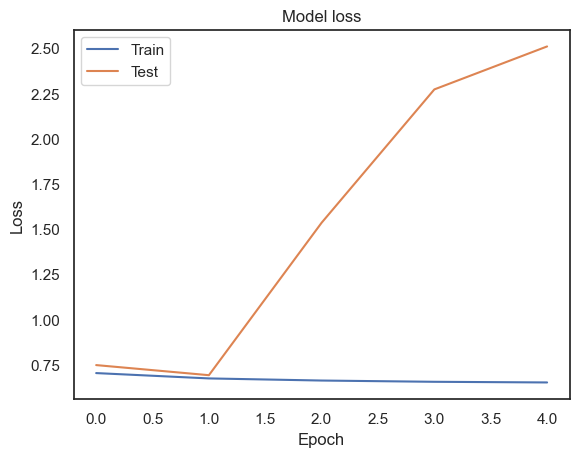

In [196]:
plt.plot(Alex_model.history['accuracy'])
plt.plot(Alex_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(Alex_model.history['loss'])
plt.plot(Alex_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Save NN models and training histories:

In [ ]:
model_dir='trained_models_low_pt/'
if not os.path.isdir(model_dir): os.system('mkdir '+model_dir)
model0.save(model_dir+'logi.h5')
model1.save(model_dir+'mlp.h5')
model_cnn.save(model_dir+'cnn.h5')
np.savez(model_dir+'training_histories.npz', [ history.history for history in [history_logi, history_mlp, history_cnn ]])
